![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Final Paper Submission
# By Tatiana Bakwenye, Sebastian Boxho, Mikel Gallo and Joaquin Ossa

## Table of Contents
- [Part 0: Dataset Selection](#part-0-dataset-selection)
- [Part 1: Setting Up the Problem](#part-1-setting-up-the-problem)
  - [a. Bibliography and SOA](#a-bibliography-and-soa)
  - [b. Dataset Description](#b-dataset-description)
  - [c. Random Classifier Performance](#c-random-classifier-performance)
  - [d. Baseline Implementation](#d-baseline-implementation)
- [Part 2: Data Scientist Challenge](#part-2-data-scientist-challenge)
  - [a. BERT Model with Limited Data](#a-bert-model-with-limited-data)
  - [b. Dataset Augmentation](#b-dataset-augmentation)
  - [c. Zero-Shot Learning with LLM](#c-zero-shot-learning-with-llm)
  - [d. Data Generation with LLM](#d-data-generation-with-llm)
  - [e. Optimal Technique Application](#e-optimal-technique-application)
- [Part 3: State of the Art Comparison](#part-3-state-of-the-art-comparison)
  - [a. Full Dataset Training](#a-full-dataset-training)
  - [b. Learning Curve](#b-learning-curve)
  - [c. Technique Comparison](#c-technique-comparison)
  - [d. Methodology Analysis](#d-methodology-analysis)
- [Part 4: Model Distillation](#part-4-model-distillation)
  - [a. Model Distillation](#a-model-distillation)
  - [b. Performance and Speed Comparison](#b-performance-and-speed-comparison)
  - [c. Analysis and Improvements](#c-analysis-and-improvements)


# Setting Up the Problem

#### Objective: Understand and establish the baseline for your chosen dataset

In [1]:
!pip install datasets
!pip install ekphrasis
!pip install langchain
!pip install transformers==4.37.2
!pip install tensorflow==2.15.0
#!pip install OpenAI

In [2]:
import datasets
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from transformers import TFDistilBertModel
from keras.utils import custom_object_scope
from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus
from scipy.sparse import csr_matrix
import random
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer
import spacy
sp = spacy.load('en_core_web_sm')
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

import string
from wordcloud import WordCloud
from collections import Counter, defaultdict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from spacy.matcher import Matcher, PhraseMatcher
from tensorflow.keras import regularizers
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from langchain.chat_models import ChatOpenAI
from jinja2 import Template
from langchain.prompts import (
    AIMessagePromptTemplate,
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [133]:
### Support Functions
#python -m spacy download en_core_web_sm - Run on Terminal
nlp = spacy.load("en_core_web_sm")

# Create a new Matcher
matcher = Matcher(nlp.vocab)

## Class Proportion

def class_prop(label):
    train_class = pd.Series(label).value_counts().reset_index()
    #Rename columns
    train_class.columns = ['class', 'count']
    train_class['total'] = train_class['count'].sum()
    train_class['perc'] = train_class['count']/train_class['total']
    print(train_class[['class','count','perc']].round(4))

## Function for Based-Rule classifier
def classify_text(text):
    doc = nlp(text)
    matches = matcher(doc)
    if matches:
        return matches  # Return the label of the first match
    else:
        return "UNKNOWN"  # If no match found

## Plot Metric Results

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='macro'):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Plot each metric
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            ax = axs[i//2, i%2]
            values = [res[metric] * 100 for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric)
            ax.set_ylim(0, 100)

            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

            ax.tick_params(axis='x', rotation=90)

        plt.tight_layout()
        plt.show()


### DATA EXPLORATION

def freq_table(df,label):
    train_class = df[label].value_counts().reset_index()
    #Rename columns
    train_class.columns = ['category', 'count']
    train_class['total'] = train_class['count'].sum()
    train_class['perc'] = train_class['count']/train_class['total']
    return train_class[['category','count','perc']].round(4)

# Part 0: Dataset Selection

In [4]:
df = load_dataset("carblacac/twitter-sentiment-analysis")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for carblacac/twitter-sentiment-analysis contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/carblacac/twitter-sentiment-analysis
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the ne

# Part 1: Setting Up the Problem

## a. Bibliography and SOA

## b. Dataset Description

##### TSATC: Twitter Sentiment Analysis Training Corpus     
Original DATASET contains 1,578,627 classified tweets (1 for positive and 0 for negative sentiment).

Our dataset has already been randomly sampled, cleaned, and split into training and testing sets. Both positive and negative classes are well balanced within each subset, and the training subset has been further divided into an 80% training set and a 20% validation set.  

This dataset is an aggregation of two twitter sentiment analysis datasets:  
- University of Michigan Sentiment Analysis competition on Kaggle: https://inclass.kaggle.com/c/si650winter11  
- Twitter Sentiment Corpus by Niek Sanders: http://www.sananalytics.com/lab/twitter-sentiment/

  
Languages: English

In [5]:
## Defining train, validation and test sets
train_data = df['train']['text']
train_labels = df['train']['feeling']

validation_data = df['validation']['text']
validation_labels = df['validation']['feeling']

test_data = df['test']['text']
test_labels = df['test']['feeling']

# Set the seed for reproducibility
np.random.seed(123)

# Define the percentage of data to use
sample_percentage = 0.05

# Sample 30% of the train data
sample_size = int(len(train_data) * sample_percentage)
train_sample_indices = random.sample(range(len(train_data)), sample_size)
train_data = [train_data[i] for i in train_sample_indices]
train_labels = [train_labels[i] for i in train_sample_indices]

# Sample 30% of the validation data
sample_size = int(len(validation_data) * sample_percentage)
validation_sample_indices = random.sample(range(len(validation_data)), sample_size)
validation_data = [validation_data[i] for i in validation_sample_indices]
validation_labels = [validation_labels[i] for i in validation_sample_indices]

# Sample 30% of the test data
sample_size = int(len(test_data) * sample_percentage)
test_sample_indices = random.sample(range(len(test_data)), sample_size)
test_data = [test_data[i] for i in test_sample_indices]
test_labels = [test_labels[i] for i in test_sample_indices]


## Creating Dataframes
df_train = pd.DataFrame({'text':train_data,'label':train_labels})
df_val = pd.DataFrame({'text':validation_data,'label':validation_labels})
df_test = pd.DataFrame({'text':test_data,'label':test_labels})

df

DatasetDict({
    train: Dataset({
        features: ['text', 'feeling'],
        num_rows: 119988
    })
    validation: Dataset({
        features: ['text', 'feeling'],
        num_rows: 29997
    })
    test: Dataset({
        features: ['text', 'feeling'],
        num_rows: 61998
    })
})

### Dataset size

In [6]:
total_rows = len(train_labels) + len(test_labels) + len(validation_labels)
# Calculate train size including validation
Train_size = len(train_labels) + len(validation_labels)
# Calculate Summary
summary_df = pd.DataFrame({'SET': ['TRAIN','TEST', 'TOTAL'], 'ROWS': [Train_size, len(test_labels), total_rows], 'SPLIT': [Train_size/total_rows, len(test_labels)/total_rows,total_rows/total_rows]})
print('Dataset Split [TRAIN, TEST]')
display(summary_df.round(3))

## TRAIN SPLIT
summary_df_train = pd.DataFrame({'SET': ['train','validation', 'TRAIN'], 'ROWS': [len(train_labels), len(validation_labels), Train_size], 'SPLIT': [len(train_labels)/Train_size, len(validation_labels)/Train_size,Train_size/Train_size]})
print('TRAIN Split [train, validation]')
display(summary_df_train.round(3))

Dataset Split [TRAIN, TEST]


,SET,ROWS,SPLIT
0,TRAIN,7498,0.708
1,TEST,3099,0.292
2,TOTAL,10597,1.000


TRAIN Split [train, validation]


,SET,ROWS,SPLIT
0,train,5999,0.8
1,validation,1499,0.2
2,TRAIN,7498,1.0


### Class distribution

In [7]:
## Class balance of our datasets
print('train')
class_prop(train_labels)
print('validation')
class_prop(validation_labels)
print('test')
class_prop(test_labels)

train
   class  count    perc
0      0   3007  0.5013
1      1   2992  0.4987
validation
   class  count    perc
0      1    756  0.5043
1      0    743  0.4957
test
   class  count    perc
0      0   1612  0.5202
1      1   1487  0.4798


### Distribution of text lengths (train set only)

In [8]:
df_train['text_length']= [len(i.split()) for i in df_train['text']]
df_val['text_length']= [len(i.split()) for i in df_val['text']]
df_test['text_length']= [len(i.split()) for i in df_test['text']]
#Calculating Answer Length

In [9]:
for i in df_train['text'][0:5]:
    print(i.split(),'length: ', len(i.split()) )

['Yes,', "I'm", 'still', 'awake.'] length:  4
['@katie_raygun', 'why', "can't", 'we', 'live', 'closer', 'to', 'one', 'another?', 'i', 'really', "don't", 'want', 'to', 'go', 'there', 'by', 'myself,', 'but', 'i', 'just', 'might', 'have', 'to.'] length:  24
['ahh,', 'stop...you', "shouldn't.", 'but', "i'm", 'very', 'curious', '~', 'even', 'tho', "i'm", 'not', 'that', 'excited', 'for', 'my', 'birthday'] length:  17
['Symantec', 'Ghost', 'image', 'corruption', 'is', 'making', 'me', 'cry'] length:  8
['Ran', '3', 'miles', 'this', 'morning', 'now', 'to', 'go', 'do', 'my', 'EA', 'Active.', "I've", 'been', 'slacking', 'on', 'it.', "I'll", 'have', 'help', 'from', 'the', 'sicko', 'so', "it'll", 'be', 'interesting!'] length:  27


Summary Statistics of text_length for positive(1) and negative(0) tweets
            mean  median       std  min  max
label                                       
0      13.752577    13.0  7.036071    1   32
1      12.786430    12.0  6.754632    1   36
   
Plot text_length distribution for positive(1) and negative(0) tweets


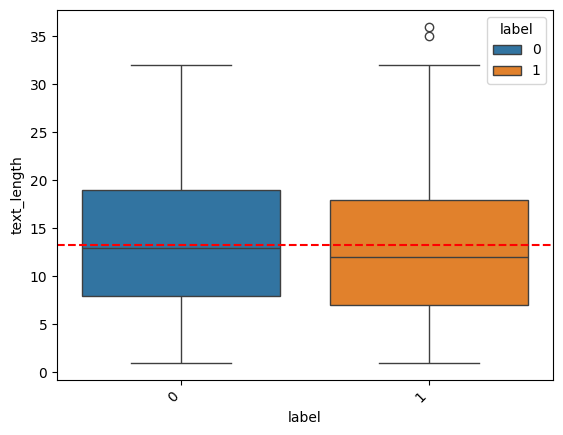

In [10]:
## Summary statistics for text_length
# Calculate multiple statistics
print('Summary Statistics of text_length for positive(1) and negative(0) tweets')
statistics = df_train.groupby('label')['text_length'].agg(['mean', 'median','std', 'min', 'max'])
# Display the result
print(statistics)

print('   ')

print('Plot text_length distribution for positive(1) and negative(0) tweets')
sns.boxplot(data=df_train, x='label', y='text_length',hue = 'label')
#plt.xlim(0, None)
plt.xticks(rotation=45, ha='right')
# Add a horizontal line at the mean of 'reply_length'
mean_reply_length = df_train['text_length'].mean()
plt.axhline(y=mean_reply_length, color='red', linestyle='--', label=f'Mean text Length ({mean_reply_length:.2f})')
# Show the plot
plt.show()

## Data Cleaning
Twitter text requires multiple transformations prior to Preprocessing

In [11]:
# Create a TextPreProcessor instance
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
               'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
              'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens

    # corpus from which the word statistics are going to be used for word segmentation
    segmenter="twitter",
    # corpus from which the word statistics are going to be used for spell correction
    corrector="twitter",

    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,

    # list of dictionaries, for replacing tokens extracted from the text, with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons],
    #Remove emoticon
    pre_processor=[lambda x: x.replace('＼(^o^)／', '')]
)

# Pre-process the sentence using TextPreProcessor

def extract_clean(text):
    cleaned_text = ' '.join([word.split('<')[0] for word in text])
    return cleaned_text

def extract_emotions(text):
    emoji_expressions = [token for token in text if token in emoticons.values()]
    return emoji_expressions

def clean_string(text):
    cleaned_text = re.sub(r'\s+', ' ', text)
    cleaned_text = cleaned_text.strip()
    return cleaned_text

def flatten_emotions(emotion_list):
    # Convert the list of emotions into a string
    emotion_string = ', '.join(emotion_list)
    # Use regular expression to find all words inside angle brackets
    emotions = re.findall(r'<([^>]*)>', emotion_string)
    unique_emotions = list(set(emotions))
    combined_emotions = ', '.join(unique_emotions)
    return combined_emotions


def clean_text(df):
# Pre-process all the sentences in df_train['text']
    df['preprocessed_text'] = [text_processor.pre_process_doc(text) for text in df['text']]
    df['clean_text'] = df['preprocessed_text'].apply(extract_clean).apply(clean_string)

    #Getting Hashtags
    df['hashtag'] = df['text'].apply(lambda x: re.findall(r'#(\w+)', x))
    df['hashtag'] = [' '.join(i) for i in df['hashtag']]

    # Iterate through the preprocessed text
    df['emotions'] = df['preprocessed_text'].apply(extract_emotions)
    df['clean_emotions'] = df['emotions'].apply(flatten_emotions)

    df = df[['text','label','text_length','clean_text','clean_emotions','hashtag']]
    return df

df_train = clean_text(df_train)
df_val = clean_text(df_val)
df_test = clean_text(df_test)


/usr/local/lib/python3.10/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...


/usr/local/lib/python3.10/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...


## DATA EXPLORATION

#### Hashtags

- 98% of the tweets have no hashtags. Most likely they have been already cleaned.
- Doesn't make sense to keep diving for more insigths.

In [12]:
hashtag_freq = freq_table(df_train,'hashtag')
hashtag_freq = hashtag_freq.sort_values(by='perc',ascending=False)
hashtag_freq['accum'] = hashtag_freq['perc'].cumsum()
print('top 10 hashtags')
display(hashtag_freq[0:10])

top 10 hashtags


,category,count,perc,accum
0,,5876,0.9795,0.9795
1,followfriday,9,0.0015,0.9810
2,squarespace,7,0.0012,0.9822
3,fb,7,0.0012,0.9834
7,musicmonday,2,0.0003,0.9837
8,FollowFriday,2,0.0003,0.9840
9,BSB,2,0.0003,0.9843
6,asot400,2,0.0003,0.9846
5,2,2,0.0003,0.9849
4,mmwanted,2,0.0003,0.9852


#### EMOTIONS

- 98% of the tweets have no emotions. Most likely have been already removed.
- Because they directly express the sentiment of the text, we'll concatenate them to our cleaned tweet corpus.

In [13]:
emotions_freq = freq_table(df_train,'clean_emotions')
emotions_freq = emotions_freq.sort_values(by='perc',ascending=False)
emotions_freq['accum'] = emotions_freq['perc'].cumsum()
print('top 10 emotions')
display(emotions_freq[0:10])

top 10 emotions


,category,count,perc,accum
0,,5867,0.9780,0.9780
1,wink,38,0.0063,0.9843
2,annoyed,25,0.0042,0.9885
3,sad,19,0.0032,0.9917
4,happy,15,0.0025,0.9942
5,tong,14,0.0023,0.9965
6,laugh,12,0.0020,0.9985
7,surprise,5,0.0008,0.9993
8,"surprise, annoyed",1,0.0002,0.9995
9,"laugh, annoyed",1,0.0002,0.9997


In [14]:
#Concatenate text with emotions
df_train['text_emotion'] = df_train['clean_text']+' '+df_train['clean_emotions']
df_val['text_emotion'] = df_val['clean_text']+' '+df_val['clean_emotions']
df_test['text_emotion'] = df_test['clean_text']+' '+df_test['clean_emotions']


<ipython-input-14-838d5037cb64>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['text_emotion'] = df_test['clean_text']+' '+df_test['clean_emotions']


### Preprocessor

In [15]:
#Defining preprocessing class to be included in Pipeline later.
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


## Text mining - Preprocessing, CountVectorizing and tf-idf

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.punctuations = set(string.punctuation)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        preprocessed_texts = []
        for text in X:
            # Convert text to lowercase
            #text = text.lower()
            text = "".join([char.lower() for char in text if char not in string.punctuation])
            # Tokenize text
            tokens = word_tokenize(text)
            # Remove stopwords and apply lemmatization
            filtered_tokens = [self.lemmatizer.lemmatize(word) for word in tokens if word not in self.stop_words]
            # Join tokens back into a string
            preprocessed_text = ' '.join(filtered_tokens)
            preprocessed_texts.append(preprocessed_text)

        return preprocessed_texts


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
sent = ['hello . ! my name is! test .. wuhoo']
pre =TextPreprocessor()
pre.fit(sent)
res = pre.transform(sent)
res

['hello name test wuhoo']

#### Exploring positive and negative words using WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


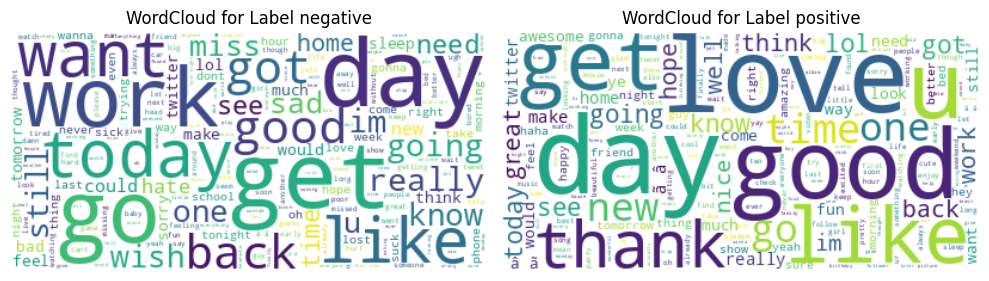

In [17]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


labels = {0: 'negative', 1: 'positive'}

# Prepare data for wordclouds
label_data = defaultdict(lambda: '')

for text, label in zip(df_train['clean_text'], df_train['label']):
    label_data[label] += text

# Generate and plot wordclouds for each label
fig, axs = plt.subplots(1, 2, figsize=(10, 6))  # Create 2x2 subplots
axs = axs.flatten()  # Flatten the axis array

for ax, (label, text) in zip(axs, label_data.items()):
    wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('WordCloud for Label {}'.format(labels.get(label)))
    ax.axis('off')

plt.tight_layout()
plt.show()

## Exploring positive and negative words using TF-IDF + LDA

In [18]:
## Preprocessing texts
pipeline = Pipeline([
        ('prepro', TextPreprocessor()),
        ("vect", CountVectorizer(ngram_range=(1, 2), min_df=0.005, max_df=0.97)),
        ("tfidf", TfidfTransformer(use_idf=True, norm='l1'))
    ]
)

# Fit the pipeline on the training data
pipeline.fit(df_train['clean_text'])



Pipeline(steps=[('prepro', TextPreprocessor()),
                ('vect',
                 CountVectorizer(max_df=0.97, min_df=0.005,
                                 ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(norm='l1'))])

### TF-IDF Score

In [19]:
def tfidf_term(pipeline,df,sentiment):
# Access the CountVectorizer step from the pipeline
    count_vectorizer = pipeline.named_steps['vect']
    # Fit and transform the data
    tf_idf_pos_matrix = pipeline.transform(df[df['label']==sentiment]['clean_text'])
    # Convert count matrix to DataFrame
    vec_fr_mtx = pd.DataFrame(data=tf_idf_pos_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())

    #Creating a dictionary of frequencies for our terms
    feature_names = count_vectorizer.get_feature_names_out()
    # Calculate Term frequency dictionary
    term_tfidf = np.mean(vec_fr_mtx, axis=0)
    #Store in a dictionary
    tfidf_dict = {i: n for i, n in zip(feature_names, term_tfidf)}
    print(len(term_tfidf))
    return feature_names, term_tfidf, tfidf_dict


def transform_to_dataframe(feature_names, score):
    # Create DataFrame with feature names and mean TF-IDF scores
    df = pd.DataFrame({'terms': feature_names, 'score': score})
    # Reset index
    df.reset_index(drop=True, inplace=True)
    return df

# Example usage:
def plot_freq_top(df,top,pos):
    df = df.sort_values(by='score',ascending = False)
    df = df.head(top)
    #We are going to set the

    # Plot the top N terms and their TF-IDF scores
    plt.figure(figsize=(10, 6))
    plt.barh(df['terms'], df['score'], align='center')
    plt.yticks(df['terms'])
    plt.xlabel('Frequency Score')
    plt.title(pos.format(top))
    #plt.xlim(0,0.010)
    plt.gca().invert_yaxis()  # Invert y-axis to display top terms at the top
    plt.show()

245


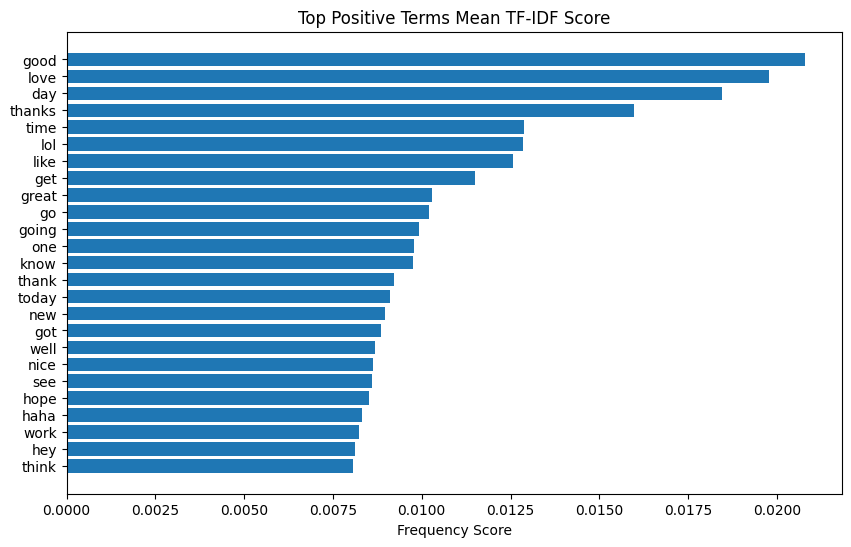

In [20]:
pos = f'Top Positive Terms Mean TF-IDF Score'
## Posive Terms
pos_feature_names, term_tfidf, tfidf_dict = tfidf_term(pipeline,df_train,1)
pos_tf_idf = transform_to_dataframe(pos_feature_names,term_tfidf)
plot_freq_top(pos_tf_idf,25,pos)

245


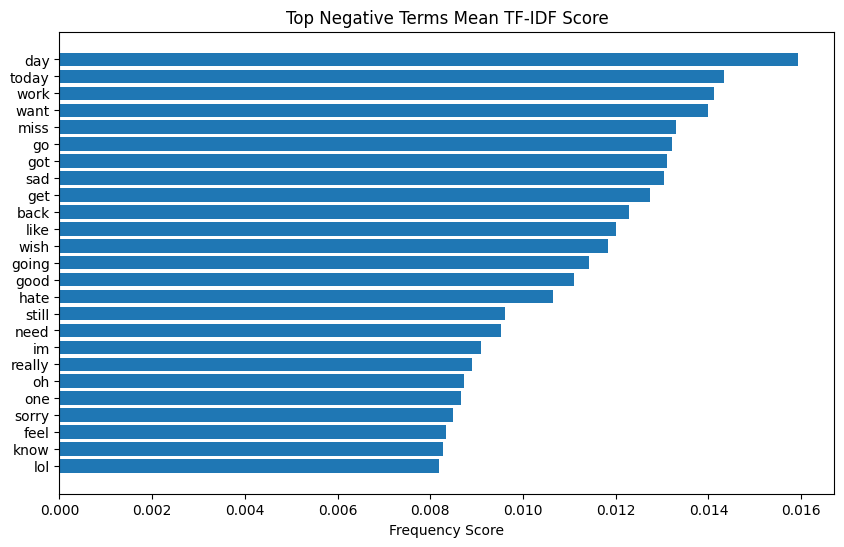

In [21]:
neg = f'Top Negative Terms Mean TF-IDF Score'
## Posive Terms
neg_feature_names, term_tfidf, tfidf_dict = tfidf_term(pipeline,df_train,0)
neg_tf_idf = transform_to_dataframe(neg_feature_names,term_tfidf)
plot_freq_top(neg_tf_idf,25,neg)

### Analyzing Both Positive and Negative Most Common Topics

In [22]:
# Specify the number of topics (adjust as needed)
num_topics = 10
# Initialize LDA model
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)

##Creating matrix
tf_idf_pos_matrix = pipeline.transform(df_train[df_train['label']==1]['clean_text'])
# Convert count matrix to DataFrame
tfidf_mtx = pd.DataFrame(data=tf_idf_pos_matrix.toarray(), columns=pos_feature_names)

# Fit the model to your TF-IDF matrix
lda.fit(tfidf_mtx)

LatentDirichletAllocation(random_state=42)

In [23]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")


# Print top words for each topic
print_top_words(lda, pos_feature_names, n_top_words=10)

Topic #1: good, watching, awesome, night, going, movie, people, enjoy, also, tell
Topic #2: lol, nice, morning, way, work, im, well, got, good, weekend
Topic #3: love, new, better, go, song, bed, watch, bit, feel, house
Topic #4: like, fun, yeah, twitter, look, amazing, need, video, eating, soon
Topic #5: thanks, yes, hope, tomorrow, always, coming, luck, party, cant, went
Topic #6: thank, friend, home, cute, much, excited, right, ur, never, pic
Topic #7: hey, time, haha, come, follow, please, hello, back, beautiful, game
Topic #8: great, day, one, music, week, pretty, hour, tonight, next, ever
Topic #9: get, today, looking, would, finally, hi, na, thing, follower, ya
Topic #10: know, see, happy, yay, let, think, wait, sure, check, cool


In [24]:
def get_top_words(model, feature_names, n_top_words):
    top_words_per_topic = []
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        top_words_per_topic.append(top_words)
    return top_words_per_topic

# Get top words for each topic
top_words_per_topic = get_top_words(lda, pos_feature_names, n_top_words=10)
# Extract words from list of lists
top_pos_words = [word for sublist in top_words_per_topic for word in sublist]

# Remove duplicates using set()
unique_pos = set(top_pos_words)

In [25]:
# Specify the number of topics (adjust as needed)
num_topics = 10
# Initialize LDA model
lda2 = LatentDirichletAllocation(n_components=num_topics, random_state=42)

##Creating matrix
tf_idf_neg_matrix = pipeline.transform(df_train[df_train['label']==0]['clean_text'])
# Convert count matrix to DataFrame
tfidf_mtx = pd.DataFrame(data=tf_idf_neg_matrix.toarray(), columns=neg_feature_names)

# Fit the model to your TF-IDF matrix
lda2.fit(tfidf_mtx)

LatentDirichletAllocation(random_state=42)

In [26]:
# Print top words for each topic
print_top_words(lda2, neg_feature_names, n_top_words=10)

Topic #1: sad, got, going, missing, poor, good, bored, missed, people, watching
Topic #2: work, think, lol, tired, well, feeling, already, away, come, go
Topic #3: still, new, right, say, anything, tweet, something, bit, big, without
Topic #4: wish, like, twitter, last, yeah, day, look, way, guess, found
Topic #5: hate, sorry, feel, tomorrow, let, cant, coming, better, soon, love
Topic #6: need, sleep, much, left, long, hard, find, boo, wan, wan na
Topic #7: miss, bad, suck, sick, ugh, really, please, time, baby, morning
Topic #8: want, tonight, one, day, though, working, never, hurt, week, oh
Topic #9: today, back, lost, phone, get, head, damn, school, gon, thing
Topic #10: could, make, getting, dont, see, go, room, said, know, hour


In [27]:
# Get top words for each topic
topneg_words_per_topic = get_top_words(lda2, pos_feature_names, n_top_words=10)
# Extract words from list of lists
top_neg_words = [word for sublist in topneg_words_per_topic for word in sublist]

# Remove duplicates using set()
unique_neg = set(top_neg_words)

## c. Random Classifier Performance

**pending**: include preprocessing in the pipeline to properly treat tweets.

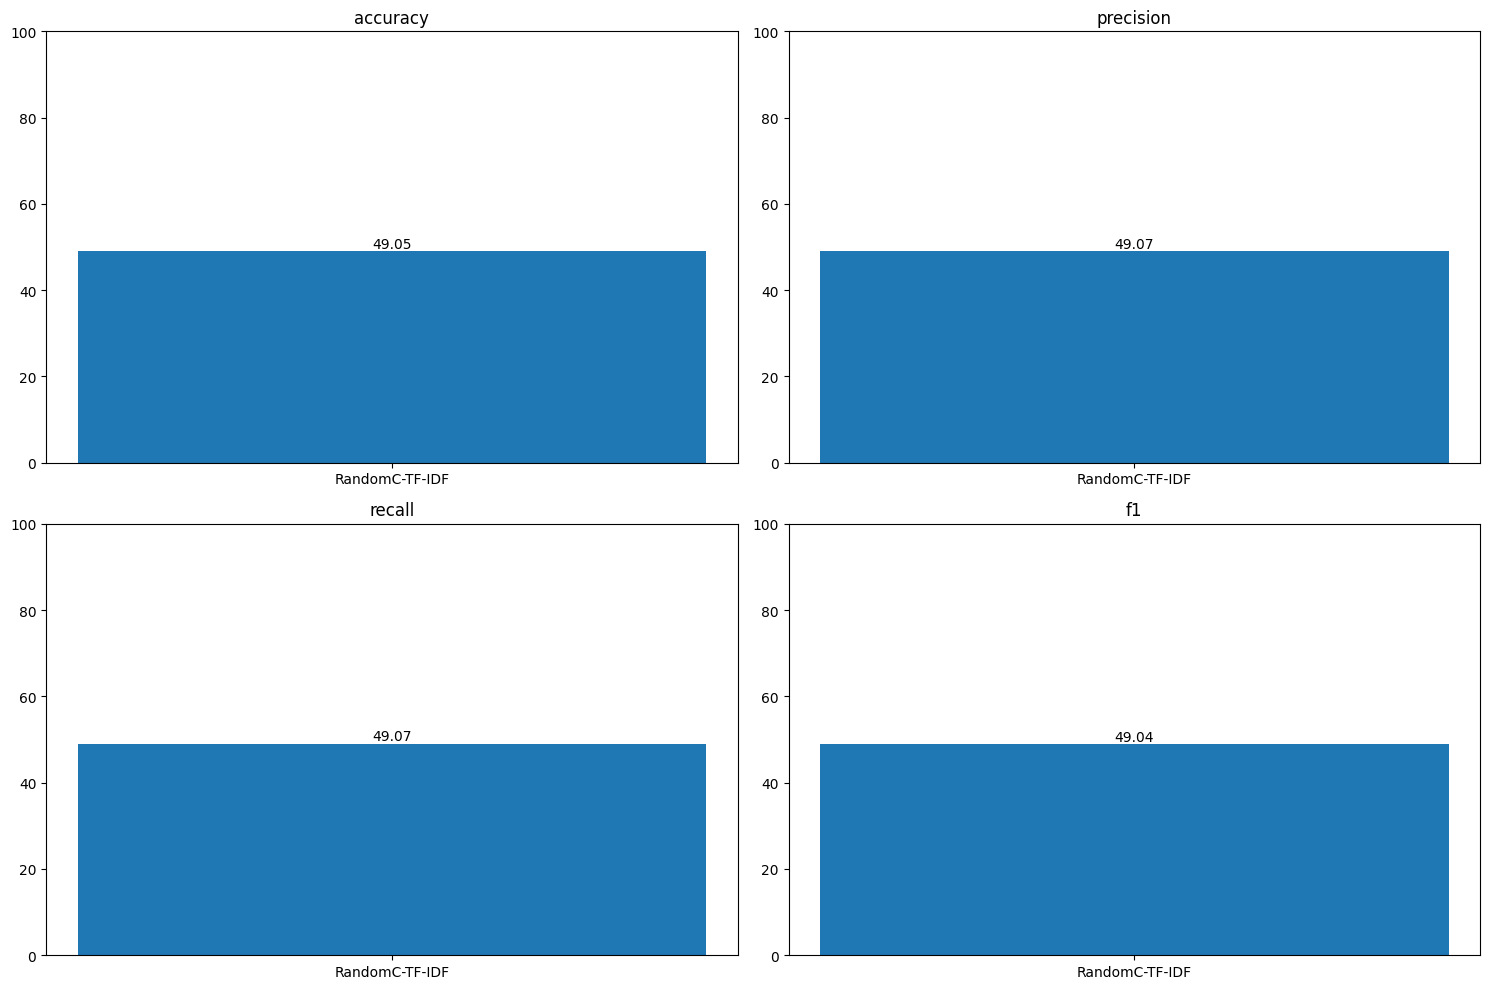

In [28]:
pipeline = Pipeline([
        ('prepro', TextPreprocessor()),
        ("vect", CountVectorizer(ngram_range=(1, 2), min_df=0.005, max_df=0.97)),
        ("tfidf", TfidfTransformer(use_idf=True, norm='l1'))
    ]
)

# Fit the classifier to the training data
pipeline.fit(df_train['clean_text'])
##Creating matrix
tf_idf_matrix = pipeline.transform(df_train['clean_text'])
val_idf_matrix = pipeline.transform(df_test['clean_text']) #Changed validation for test
# Convert count matrix to DataFrame
tfidf_mtx = pd.DataFrame(data=tf_idf_matrix.toarray(), columns=pipeline.named_steps['vect'].get_feature_names_out())
val_mtx = pd.DataFrame(data=val_idf_matrix.toarray(), columns=pipeline.named_steps['vect'].get_feature_names_out())

##Innitializing RandomClassifier
dummy_classifier = DummyClassifier(strategy='uniform')
# Fit the classifier to the training data
dummy_classifier.fit(tfidf_mtx, df_train['label'])

# Make predictions on the testing data
y_pred = dummy_classifier.predict(val_mtx)

# Calculate accuracy (or any other metric)
metrics_val= Metrics()
metrics_val.run(test_labels, y_pred, "RandomC-TF-IDF")
metrics_val.plot()


## d. Baseline Implementation

### Rule-Based using Spacy Matcher

In [29]:
## Call positive words from Positive LDA
print(unique_pos)

{'please', 'feel', 'time', 'think', 'game', 'like', 'yeah', 'get', 'always', 'awesome', 'na', 'look', 'cute', 'looking', 'would', 'excited', 'ever', 'better', 'twitter', 'back', 'love', 'finally', 'tell', 'fun', 'eating', 'come', 'im', 'wait', 'well', 'hope', 'thank', 'watching', 'went', 'day', 'people', 'week', 'pretty', 'new', 'yay', 'hour', 'cant', 'good', 'happy', 'never', 'tonight', 'party', 'soon', 'going', 'let', 'luck', 'follower', 'go', 'see', 'work', 'bed', 'ya', 'way', 'sure', 'friend', 'tomorrow', 'hey', 'know', 'much', 'ur', 'hi', 'watch', 'nice', 'home', 'cool', 'got', 'pic', 'next', 'thanks', 'house', 'morning', 'coming', 'right', 'haha', 'today', 'yes', 'lol', 'enjoy', 'weekend', 'also', 'beautiful', 'thing', 'one', 'bit', 'night', 'song', 'hello', 'amazing', 'video', 'movie', 'great', 'follow', 'need', 'music', 'check'}


In [30]:
## Get all the most relevant positive terms
positives = ['cute','aw','best','happy','haha',
             'amazing','fun','great','yay','love',
             'lol','excited','awesome','wow','nice','beautiful',
             'cool','glad','good']

print(positives)

['cute', 'aw', 'best', 'happy', 'haha', 'amazing', 'fun', 'great', 'yay', 'love', 'lol', 'excited', 'awesome', 'wow', 'nice', 'beautiful', 'cool', 'glad', 'good']


In [31]:
## Call negative words from Negative LDA
print(unique_neg)

{'please', 'feel', 'time', 'phone', 'head', 'think', 'tweet', 'like', 'yeah', 'get', 'wish', 'feeling', 'guess', 'wan', 'sleep', 'suck', 'bad', 'look', 'better', 'boo', 'twitter', 'back', 'love', 'bored', 'come', 'make', 'without', 'well', 'watching', 'oh', 'day', 'people', 'week', 'new', 'miss', 'hour', 'though', 'left', 'already', 'away', 'sorry', 'cant', 'good', 'could', 'never', 'still', 'find', 'ugh', 'soon', 'tonight', 'going', 'gon', 'found', 'let', 'hurt', 'go', 'see', 'work', 'anything', 'really', 'getting', 'dont', 'way', 'long', 'damn', 'tomorrow', 'know', 'much', 'missing', 'lost', 'poor', 'sad', 'school', 'something', 'baby', 'say', 'got', 'right', 'coming', 'morning', 'today', 'lol', 'thing', 'one', 'working', 'bit', 'tired', 'room', 'wan na', 'want', 'hate', 'sick', 'said', 'missed', 'need', 'big', 'last', 'hard'}


In [32]:
## Get all the most relevant negative terms
negatives = ['sick','hurt','tired','hate','bad',
             'damn','never','miss','suck','sorry',
             'ugh','sad','lost', 'bored']

print(negatives)

['sick', 'hurt', 'tired', 'hate', 'bad', 'damn', 'never', 'miss', 'suck', 'sorry', 'ugh', 'sad', 'lost', 'bored']


### Implement rule-based conditions for our baseline model

In [33]:
#loading and initializing nlp object
nlp = spacy.load('en_core_web_sm')
## Initializing Matcher
matcher = Matcher(nlp.vocab)

In [34]:
## Initializing Matcher
matcher = Matcher(nlp.vocab)

# based on word cloud
positive_patterns = [
    [{'LOWER': 'cute'}],
    [{'LOWER': 'aw'}],
    [{'LOWER': 'best'}],
    [{'LOWER': 'happy'}],
    [{'LOWER': 'haha'}],
    [{'LOWER': 'amazing'}],
    [{'LOWER': 'fun'}],
    [{'LOWER': 'great'}],
    [{'LOWER': 'yay'}],
    [{'LOWER': 'love'}],
    [{'LOWER': 'lol'}],
    [{'LOWER': 'excited'}],
    [{'LOWER': 'awesome'}],
    [{'LOWER': 'wow'}],
    [{'LOWER': 'nice'}],
    [{'LOWER': 'beautiful'}],
    [{'LOWER': 'cool'}],
    [{'LOWER': 'glad'}],
    [{'LOWER': 'good'}]
]


# based on word cloud
negative_patterns = [
    [{'LOWER': 'sick'}],
    [{'LOWER': 'hurt'}],
    [{'LOWER': 'tired'}],
    [{'LOWER': 'hate'}],
    [{'LOWER': 'bad'}],
    [{'LOWER': 'damn'}],
    [{'LOWER': 'never'}],
    [{'LOWER': 'miss'}],
    [{'LOWER': 'suck'}],
    [{'LOWER': 'sorry'}],
    [{'LOWER': 'ugh'}],
    [{'LOWER': 'sad'}],
    [{'LOWER': 'lost'}],
    [{'LOWER': 'bored'}]
]


## Adding patterns to matcher
matcher.add('positives',positive_patterns)
matcher.add('negatives',negative_patterns)


In [35]:
#Matching elements in documents
## Matching VALIDATION
docs_v = [nlp(doc) for doc in df_test['clean_text']]
matches_v = [matcher(d) for d in docs_v]

In [36]:
def matching_func(d,ms):
    #Return the index and the total number of matches per row
    rows_data = []
    for (i, match),doc in zip(enumerate(ms),d):
        #variables for defining current row/index
        row = 0
        row=i
        # positive variables
        positives = 0
        pos_w = []
        # negative variables
        negatives = 0
        neg_w = []

        diction = {'index':0,'total':0, 'positive':0 ,'negative':0,'pos_words':[],'neg_words':[]}
        # Filling dictionary
        diction['index'] = row
        diction['total'] = len(match)

        for match_id, start, end in match:
            if nlp.vocab.strings[match_id] == "positives":
                # store positive matched words
                pos_words = doc[start:end].text
                pos_w.append(pos_words)
                #diction['pos_words'] = pos_w
                # store number of positive words
                positives = len(pos_w)
                diction['positive'] = positives
            elif nlp.vocab.strings[match_id] == "negatives":
                # store negative matched words
                neg_words = doc[start:end].text
                neg_w.append(neg_words)
                #diction['neg_words'] = neg_w
                # store number of negative words
                negatives = len(neg_w)
                diction['negative'] = negatives

        #Add words matched to dictionary
        diction['pos_words'] = pos_w
        #diction['positive'] = positives
        diction['neg_words'] = neg_w
        #diction['negative'] = negatives

        diction = {k: np.nan if (not v and v != 0) else v for k, v in diction.items()}

        rows_data.append(diction)

    df = pd.DataFrame(rows_data)
    return df
        #print(diction['index'],' ',diction['total'],' ',diction['pos_words'],' ',diction['positive'],' ',diction['neg_words'],' ',diction['negative'])

In [37]:
va_df = matching_func(docs_v,matches_v)
va_df

,index,total,positive,negative,pos_words,neg_words
0,0,1,0,1,NaN,[tired]
1,1,1,0,1,NaN,[tired]
2,2,1,0,1,NaN,[bad]
3,3,0,0,0,NaN,NaN
4,4,0,0,0,NaN,NaN
...,...,...,...,...,...,...
3094,3094,1,1,0,[excited],NaN
3095,3095,0,0,0,NaN,NaN
3096,3096,0,0,0,NaN,NaN
3097,3097,1,1,0,[awesome],NaN


In [38]:
# Create a new column 'proba' where 1 is returned if positives are greater than negatives, else 0
threshold = 0.5

va_df['proba'] = np.where(va_df['total'] != 0, (va_df['positive'] / va_df['total']) > threshold, 0)
va_df

,index,total,positive,negative,pos_words,neg_words,proba
0,0,1,0,1,NaN,[tired],0
1,1,1,0,1,NaN,[tired],0
2,2,1,0,1,NaN,[bad],0
3,3,0,0,0,NaN,NaN,0
4,4,0,0,0,NaN,NaN,0
...,...,...,...,...,...,...,...
3094,3094,1,1,0,[excited],NaN,1
3095,3095,0,0,0,NaN,NaN,0
3096,3096,0,0,0,NaN,NaN,0
3097,3097,1,1,0,[awesome],NaN,1


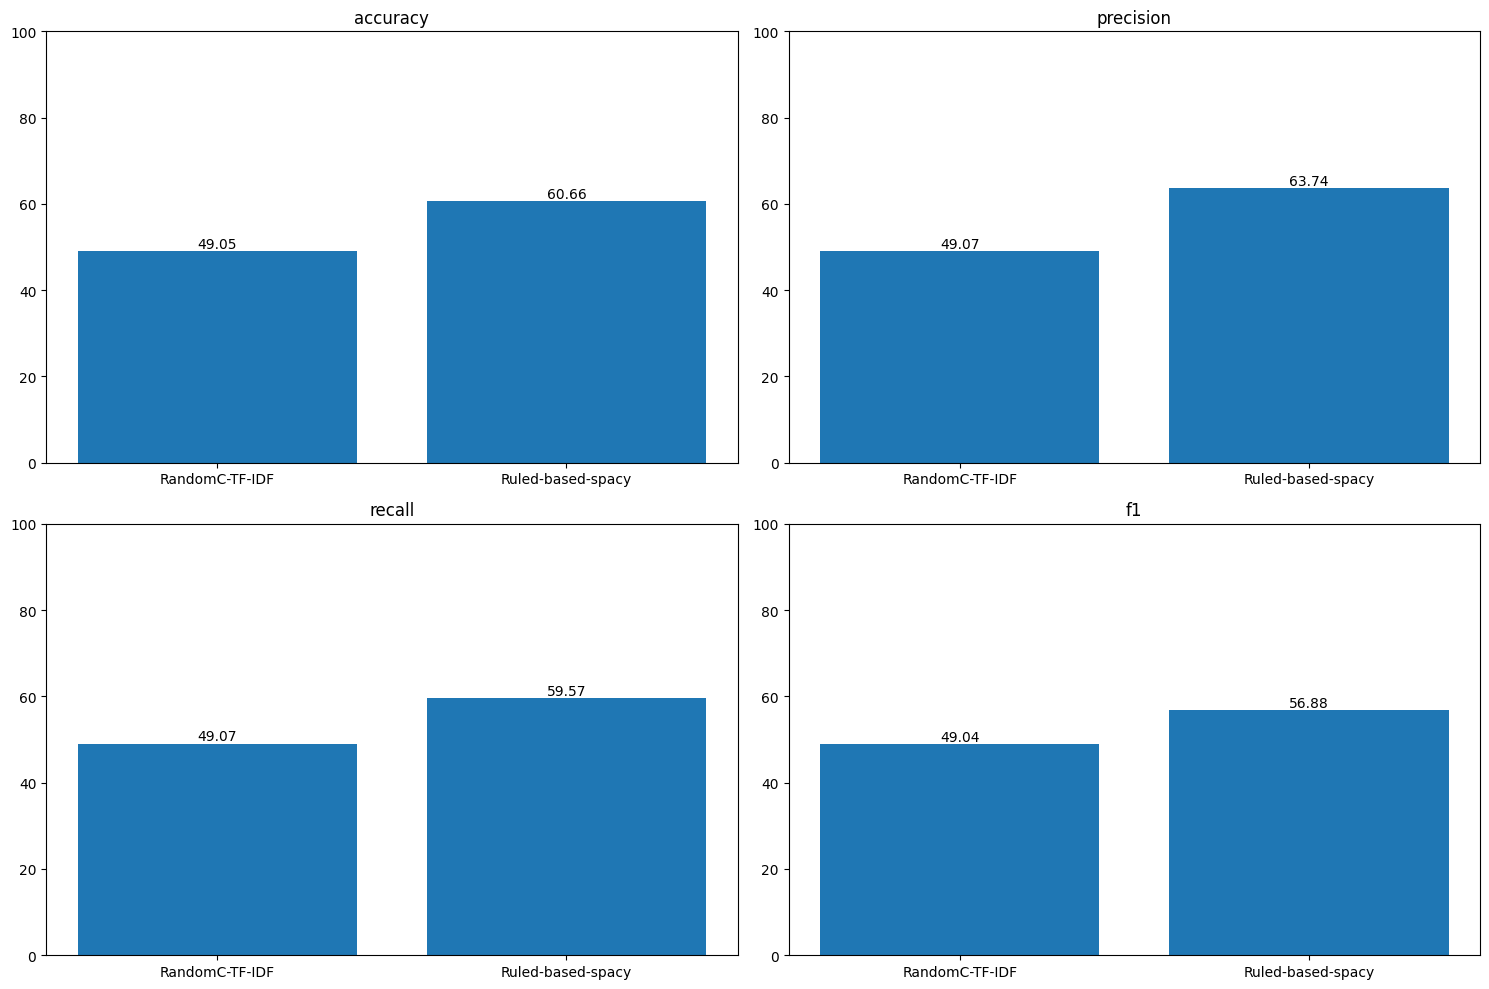

In [39]:
## Comparing with real

metrics_val.run(test_labels, va_df['proba'], "Ruled-based-spacy")
metrics_val.plot()

### Error Analysis

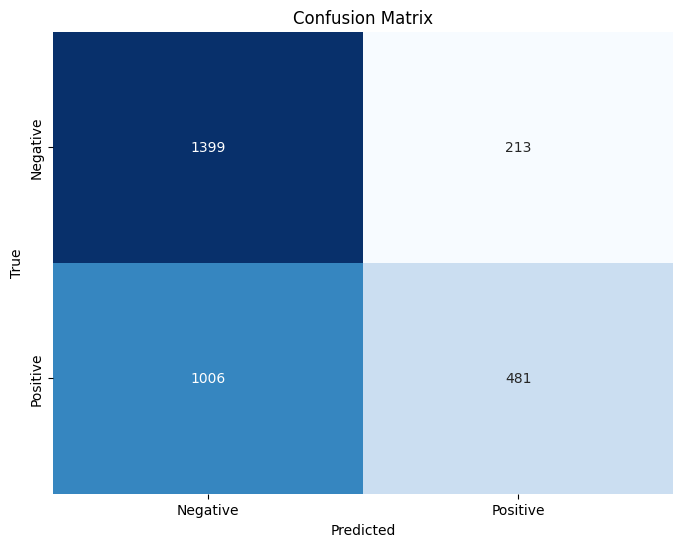

In [40]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels, va_df['proba'])

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [41]:
df_val2 = df_test.copy()

#Create an index column to join with our prediction results
df_val2 = df_val2.reset_index()

## Merge with new data
merged_data = df_val2.merge(va_df[['index','proba']],how='left',left_on='index',right_on='index',suffixes=['_tr','_df'])
merged_data.head()

,index,text,label,text_length,clean_text,clean_emotions,hashtag,text_emotion,proba
0,0,very tired this morning. I guess I shouldn't ...,0,21,very tired this morning . i guess i should not...,,,very tired this morning . i guess i should not...,0
1,1,is wanting some lunch but i to tired to make it,0,11,is wanting some lunch but i to tired to make it,,,is wanting some lunch but i to tired to make it,0
2,2,@SallyD well it was from soccer today. it hurt...,0,23,well it was from soccer today . it hurts so ba...,,,well it was from soccer today . it hurts so ba...,0
3,3,@chictopia I really am inspired. I've just rec...,1,23,i really am inspired . i have just recently ta...,,,i really am inspired . i have just recently ta...,0
4,4,Youngin wants to 'redesign' our backyard so I'...,1,18,youngin wants to ' redesign ' our backyard so ...,,,youngin wants to ' redesign ' our backyard so ...,0


In [42]:
## Printing False Negatives
print('MISSCLASSIFIED TWEETS EXPLORATION')
for i in merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['clean_text'][0:25]:
    print(i)

MISSCLASSIFIED TWEETS EXPLORATION
i really am inspired . i have just recently taken a closer look at my wardrobe and thought , " why haven ' t i worn this lately ? "
youngin wants to ' redesign ' our backyard so i am helping her take measurements ; not sure where this is going .
i have not seen it thus far , so i am looking forward to it
thats right ! go , go , go go .
birthday on tuesdayy
with mak . ( the one that cant ride the bike ) jk jk
its karl wolf then isnt it ? virgin mega guess
victoria got " stage fright " during her hip hop moment in chapel unlike
oh nevermind i read isla ' s tweet about it .
nah wasn ' t too bad ! i was in david matthew ' s team wbu ? good luck for tomorrow !
i am an online shopper
re : bulletin . . . made that three days ago
welcome ! namaste
i exercised everday this week . i feel fit hahaha . and yes u r a nerd doesnt have to be books
sos - jonas brothers
ã  â ¿ ã  â¾ã  â   ã  â¾ã  â¼ã  æ  ã  â  ¡ ã  â   ã  â¾ ã  â   ã  â   ã  â § ã

#### How can we reduce the amount of false negatives?

Twitter data presents certain challenges:

- Frequently, we encounter questions that lack clear sentiment expression.
- Sometimes, the count of positive and negative instances is equal, leading to classification as negatives based on our threshold.
- Given the intricate variety of positive patterns, we won't be able to cover all possibilities, therefore increasing the number of false negatives.
- Positive and negative sarcasm further complicates accurate classification, as seen in examples like: "I live in a basement. That's why I am so mysterious."


Proposal to reduce False negatives  

To address the issue of false negatives, we suggest a strategy suited to the complexity of tweets, characterized by informal language. Our plan involves conducting regular error analyses and augmenting our matcher patterns with new positive patterns. This iterative approach aims to develop a robust classifier capable of capturing all positive patterns accurately over time. However, we must also devise methods to handle neutral tweets and positive/negative sarcasm.

- Our initial step entails identifying missing positive patterns within misclassified tweets and incorporating them into our matcher.





245


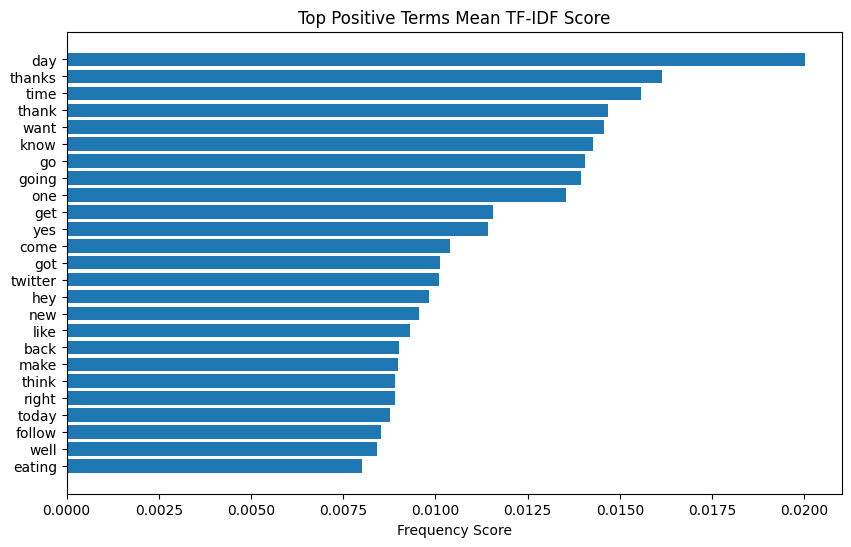

In [43]:
## Plot TFIDF identify missing positive patterns
pos = f'Top Positive Terms Mean TF-IDF Score'
## Posive Terms
pos_feature_names, term_tfidf, tfidf_dict = tfidf_term(pipeline,merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)],1)
pos_tf_idf = transform_to_dataframe(pos_feature_names,term_tfidf)
plot_freq_top(pos_tf_idf,25,pos)

In [44]:
#Identifying positive patterns:
positives2 = ['thanks','new','like','thank','well']

print(positives2)

['thanks', 'new', 'like', 'thank', 'well']


In [45]:
## Adding new patterns to matcher
# based on word cloud
positive_patterns2 = [
    [{'LOWER': 'thanks'}],
    [{'LOWER': 'new'}],
    [{'LOWER': 'like'}],
    [{'LOWER': 'thank'}],
    [{'LOWER': 'well'}]
]

## Adding patterns to matcher
matcher.add('positives',positive_patterns2)

In [46]:
#Matching elements in documents
## Matching VALIDATION
docs_v2 = [nlp(doc) for doc in merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['clean_text']]
matches_v2 = [matcher(d) for d in docs_v2]

In [47]:
va_df2 = matching_func(docs_v2,matches_v2)
va_df2

,index,total,positive,negative,pos_words,neg_words
0,0,0,0,0,NaN,NaN
1,1,0,0,0,NaN,NaN
2,2,0,0,0,NaN,NaN
3,3,0,0,0,NaN,NaN
4,4,0,0,0,NaN,NaN
...,...,...,...,...,...,...
1001,1001,0,0,0,NaN,NaN
1002,1002,0,0,0,NaN,NaN
1003,1003,0,0,0,NaN,NaN
1004,1004,1,1,0,[like],NaN


In [48]:
va_df2['proba'] = np.where(va_df2['total'] != 0, (va_df2['positive'] / va_df2['total']) > threshold, 0)
va_df2

,index,total,positive,negative,pos_words,neg_words,proba
0,0,0,0,0,NaN,NaN,0
1,1,0,0,0,NaN,NaN,0
2,2,0,0,0,NaN,NaN,0
3,3,0,0,0,NaN,NaN,0
4,4,0,0,0,NaN,NaN,0
...,...,...,...,...,...,...,...
1001,1001,0,0,0,NaN,NaN,0
1002,1002,0,0,0,NaN,NaN,0
1003,1003,0,0,0,NaN,NaN,0
1004,1004,1,1,0,[like],NaN,1


In [49]:
## Checking That lens for both results match
print(len(merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['proba']) == len(va_df2['proba']))
print(len(merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['proba']))
print(len(va_df2['proba']))


True
1006
1006


In [50]:
#check if missing values
print(merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['proba'].isna().mean())
print(va_df2['proba'].isna().mean())


0.0
0.0


In [51]:
# Different indexes
print(merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)].index)
print(va_df2.index)

Int64Index([   3,    4,   14,   16,   22,   25,   26,   32,   34,   37,
            ...
            3069, 3070, 3073, 3074, 3080, 3084, 3092, 3095, 3096, 3098],
           dtype='int64', length=1006)
RangeIndex(start=0, stop=1006, step=1)


In [52]:
# Make copies of the dataframes
merged_data_copy = merged_data.copy()
va_df2_copy = va_df2.copy()

# Find the subset indices in the copied dataframe


df_merge = pd.DataFrame({'index':merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)].index,
                         'proba1':(merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['proba']).tolist(),
                         'proba2':va_df2['proba'].tolist()
                         })

df_merge['proba3'] = np.where(df_merge['proba1'] != df_merge['proba2'], df_merge['proba2'], df_merge['proba1'])
df_merge.set_index('index', inplace=True)
df_merge


,proba1,proba2,proba3
index,,,
3,0,0,0
4,0,0,0
14,0,0,0
16,0,0,0
22,0,0,0
...,...,...,...
3084,0,0,0
3092,0,0,0
3095,0,0,0


In [53]:
#Now that we made sure that indexes will match, replace in merged data:
for index, value in zip(merged_data_copy[(merged_data_copy['label'] == 1) & (merged_data_copy['proba'] == 0)].index, df_merge['proba3']):
    merged_data_copy.loc[index, 'proba'] = value

---

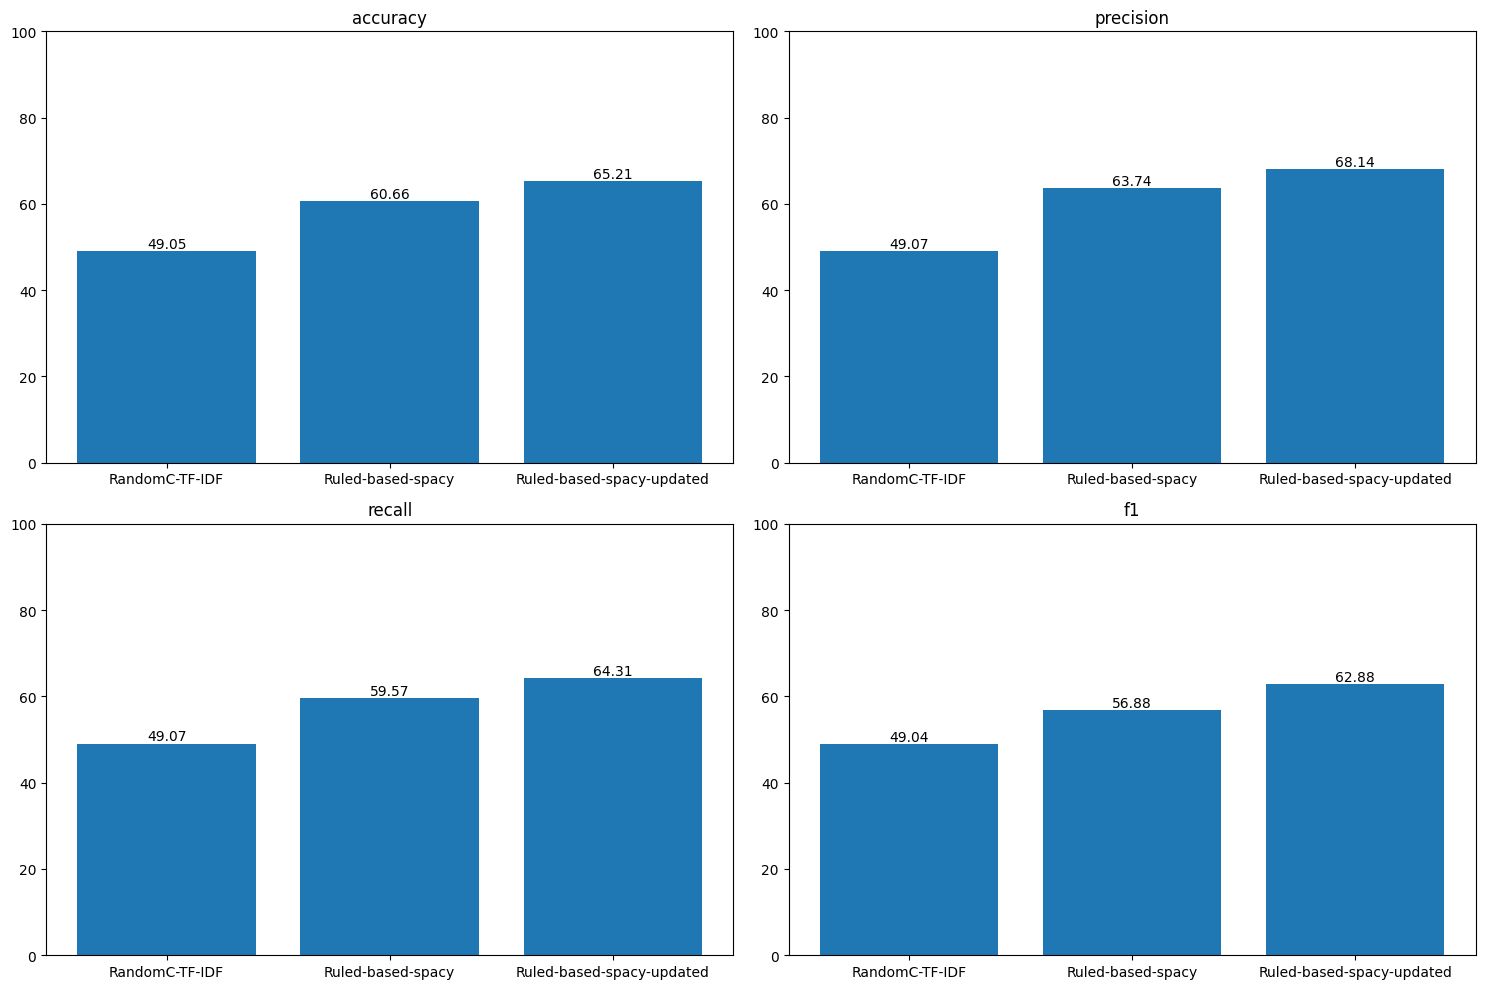

In [54]:
metrics_val.run(test_labels, merged_data_copy['proba'], "Ruled-based-spacy-updated")
metrics_val.plot()

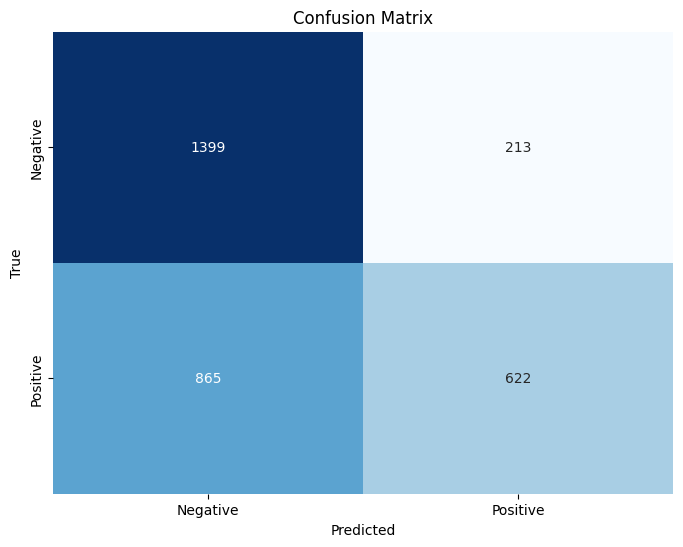

In [55]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels,  merged_data_copy['proba'])

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [56]:
## Reduction of False Negatives
((17495 / 20656) -1) * 100

-15.303059643687067

#### We managed to reduce the number of false negatives by 15% after incorporating the new batch of positive patterns learned from the error analysis

### Rule-Based Benchmark with Vader

In [57]:
# Initialize the SentimentIntensityAnalyzer.
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

# Apply lambda function to get compound scores.
function = lambda title: vader.polarity_scores(title)['compound']

# Calculate compound score and get tweet length
df_test['sentiment'] = df_test['clean_text'].apply(function)
df_test['clean_length'] = [len(i.split()) for i in df_test['clean_text']]

test = df_test[['clean_text','clean_length','sentiment']]

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [58]:
#Adding Sentiment Label
def getAnalysis(score):
 if score < 0:
    return 'Negative'
 elif score == 0:
    return 'Neutral'
 else:
    return 'Positive'

df_test['sentiment_label'] = df_test['sentiment'].apply(getAnalysis)

#Scaling score to the length of the review
df_test.head(5)

,text,label,text_length,clean_text,clean_emotions,hashtag,text_emotion,sentiment,clean_length,sentiment_label
0,very tired this morning. I guess I shouldn't ...,0,21,very tired this morning . i guess i should not...,,,very tired this morning . i guess i should not...,-0.7089,24,Negative
1,is wanting some lunch but i to tired to make it,0,11,is wanting some lunch but i to tired to make it,,,is wanting some lunch but i to tired to make it,-0.5927,11,Negative
2,@SallyD well it was from soccer today. it hurt...,0,23,well it was from soccer today . it hurts so ba...,,,well it was from soccer today . it hurts so ba...,-0.7772,25,Negative
3,@chictopia I really am inspired. I've just rec...,1,23,i really am inspired . i have just recently ta...,,,i really am inspired . i have just recently ta...,0.3134,30,Positive
4,Youngin wants to 'redesign' our backyard so I'...,1,18,youngin wants to ' redesign ' our backyard so ...,,,youngin wants to ' redesign ' our backyard so ...,0.1322,23,Positive


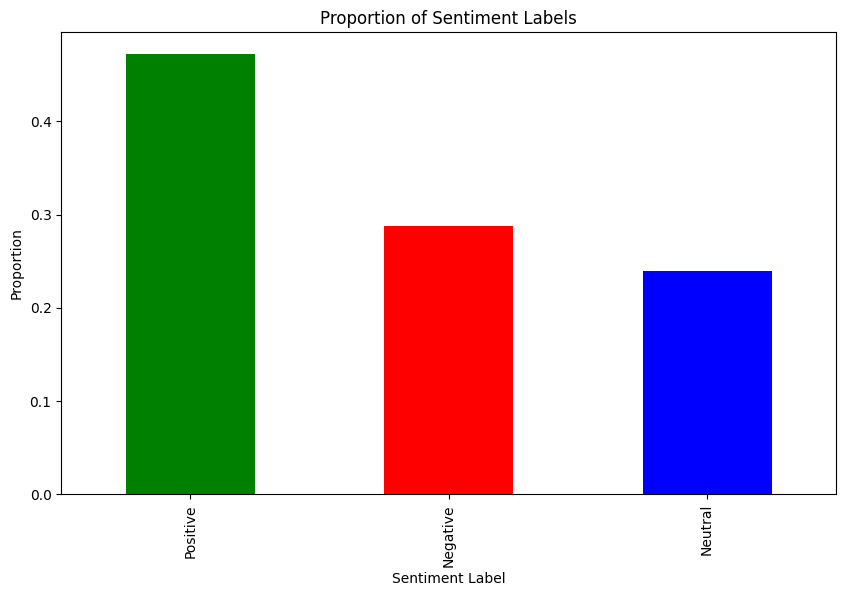

In [59]:
# Get counts of each category in 'sentiment_label'
sentiment_counts = df_test['sentiment_label'].value_counts()

# Calculate proportion of each category
total_samples = len(df_test)
sentiment_proportions = sentiment_counts / total_samples

# Define colors for each sentiment
colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'}

# Plot bar chart with colors
sentiment_proportions.plot(kind='bar', figsize=(10, 6), color=[colors[label] for label in sentiment_proportions.index])

# Set labels and title
plt.xlabel('Sentiment Label')
plt.ylabel('Proportion')
plt.title('Proportion of Sentiment Labels')

# Show plot
plt.show()


## Looking at WordCloud for inspection of Neutral Words

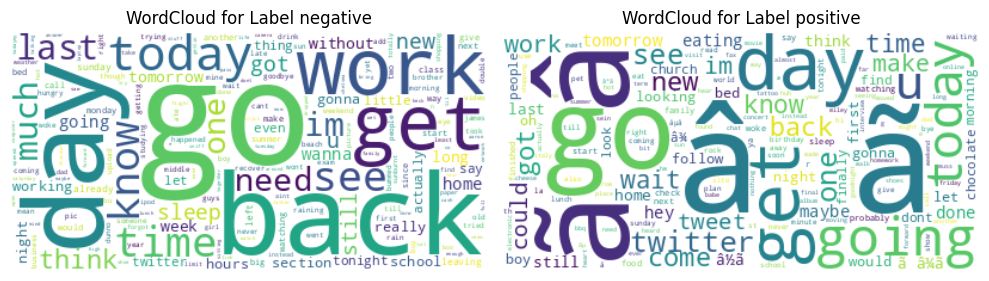

In [60]:
## Looking at a WordCloud to inspect the words in neutral
labels = {0: 'negative', 1: 'positive'}

# Prepare data for wordclouds
label_data = defaultdict(lambda: '')

for text, label in zip(df_test[df_test['sentiment_label']=='Neutral']['clean_text'], df_test[df_test['sentiment_label']=='Neutral']['label']):
    label_data[label] += text

# Generate and plot wordclouds for each label
fig, axs = plt.subplots(1, 2, figsize=(10, 6))  # Create 2x2 subplots
axs = axs.flatten()  # Flatten the axis array

for ax, (label, text) in zip(axs, label_data.items()):
    wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('WordCloud for Label {}'.format(labels.get(label)))
    ax.axis('off')

plt.tight_layout()
plt.show()

### Classifying Neutral tweets

In [61]:
#Clasifying neutral
# Iterate over rows of DataFrame where 'sentiment_label' is 'Neutral'
for index, row in df_test[df_test['sentiment_label'] == 'Neutral'].iterrows():
    # Analyze sentiment of the text
    score = vader.polarity_scores(row['clean_text'])
    if score['compound'] == 0:  # Positive sentiment
        df_test.at[index, 'sentiment_label'] = 'Negative' ##Any tweet that has no good emotion will be treated as negative
    else:  # Neutral sentiment
        df_test.at[index, 'sentiment_label'] = 'Positive'


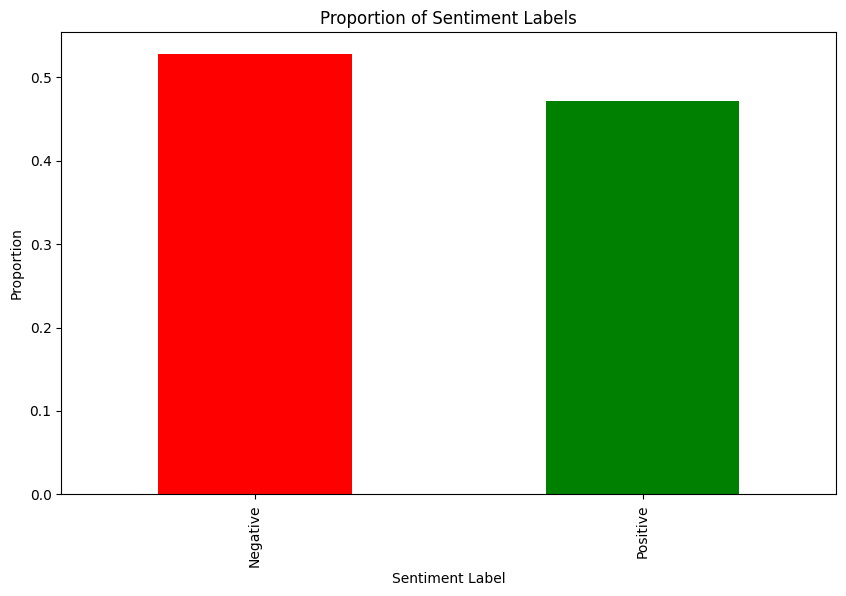

In [62]:
# Get counts of each category in 'sentiment_label'
sentiment_counts = df_test['sentiment_label'].value_counts()

# Calculate proportion of each category
total_samples = len(df_test)
sentiment_proportions = sentiment_counts / total_samples

# Define colors for each sentiment
colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'}

# Plot bar chart with colors
sentiment_proportions.plot(kind='bar', figsize=(10, 6), color=[colors[label] for label in sentiment_proportions.index])

# Set labels and title
plt.xlabel('Sentiment Label')
plt.ylabel('Proportion')
plt.title('Proportion of Sentiment Labels')

# Show plot
plt.show()

### Rule-Based Model Performance

In [63]:
#Convert to binary
df_test['sentiment_label'] = [1 if x == 'Positive' else 0 for x in df_test['sentiment_label']]
y_pred = df_test['sentiment_label']
original_labels = df_test['label']

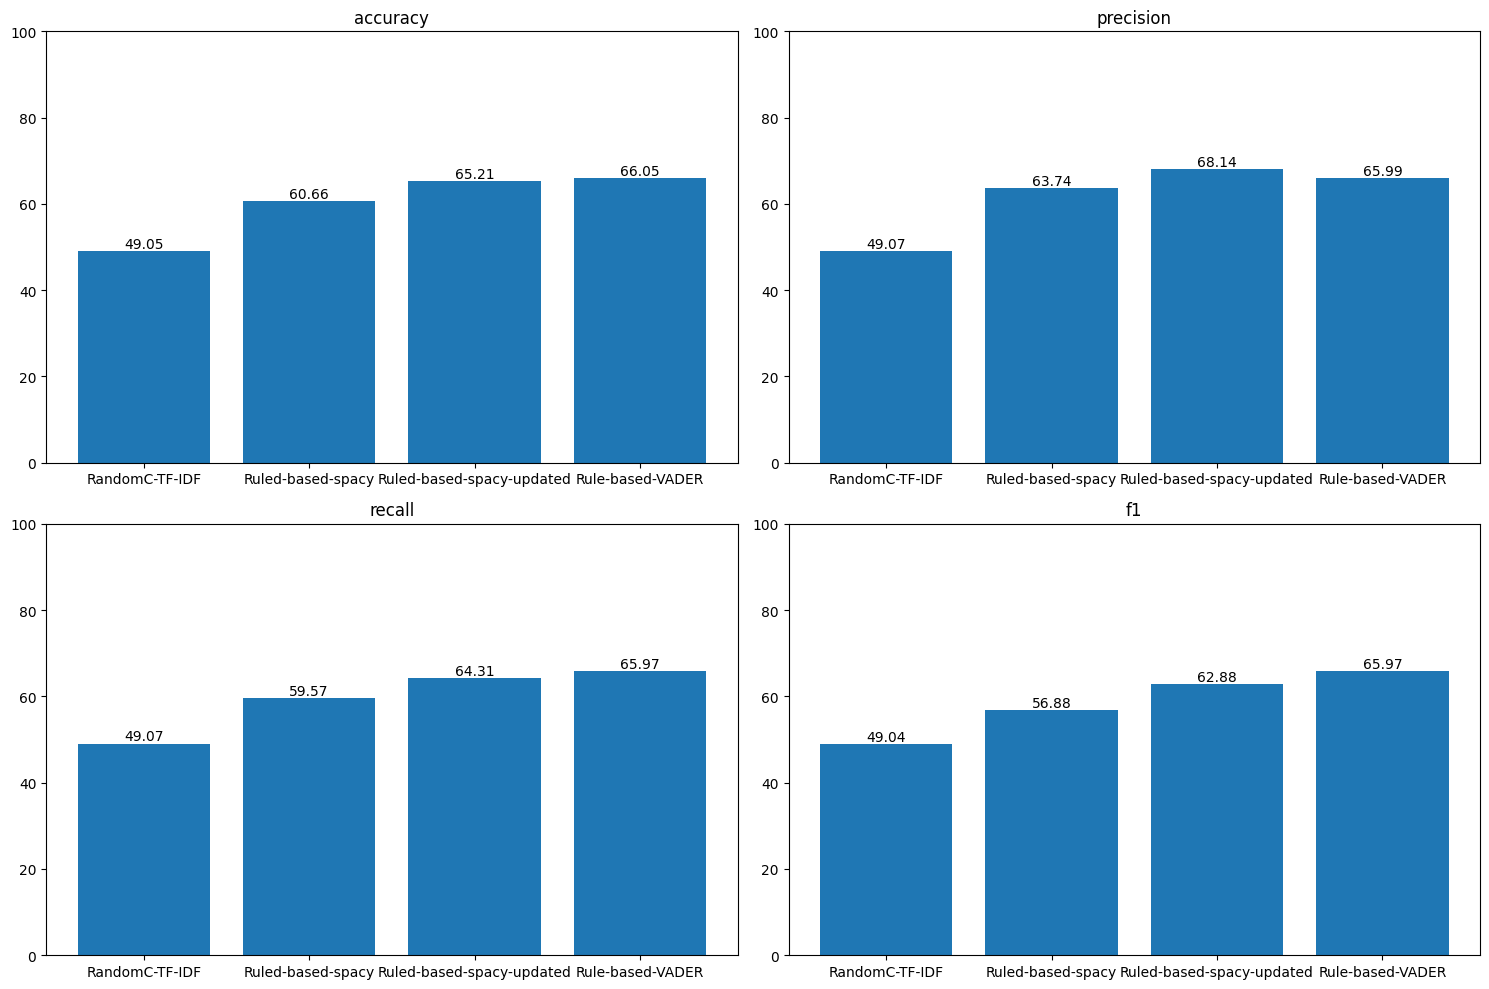

In [64]:
## Model Performance
metrics_val.run(original_labels, y_pred, "Rule-based-VADER")
metrics_val.plot()

---

# Part 2: Data Scientist Challenge
## a. BERT Model with Limited Data

In the following exercises we will work with clean text.

In [65]:
train_data_clean = df_train['clean_text']
validation_data_clean = df_val['clean_text']
test_data_clean = df_test['clean_text']

In [66]:
# First, we'll select 32 random rows from the DataFrame using the sample method.
df_train_32 = df_train.sample(n=32)

In [67]:
train_data_32 = df_train_32['clean_text']
train_labels_32 = df_train_32['label']

### BERT SETUP

In [68]:
checkpoint="cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint)

batch_size=8 # impossible to have bigger batch as far as we have just 32 observations in the train
max_length=40 # fine for the length of the sentences in our dataset - changed it according to the distribution
rate = 0.5 # dropout parameters - tried different options, 0.5 still performs better
num_labels = len(np.unique(validation_labels))

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [69]:
## Input
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Embedding layers
embedding_layer = model(input_ids=input_ids_in, attention_mask=input_masks_in)
# we need only the first token representation nothing else from the last layer
final_embedding_layer = embedding_layer[0] #last layer of BERT
# Extract only the [CLS] token's embeddings
cls_token_embeddings = final_embedding_layer[:, 0, :]
# First dimension is the number of rows
# Second dimension is the number of tokens (in our case 64)
# The last dimension is the embedding size, in this case 768

# Let's add some dropout to reduce overfitting
output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(cls_token_embeddings)

# One dense layer to process the last layer
output = tf.keras.layers.Dense(num_labels,
                               kernel_initializer="glorot_uniform",
                               activation='softmax')(output_layer)


bert_model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)

bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 40)]                 0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_token[0][0]',         
 aModel)                     ngAndCrossAttentions(last_   32         'masked_token[0][0]']        
                             hidden_state=(None, 40, 76                                           
                             8),                                                              

In [70]:
def get_batches(X_train, y_train, tokenizer, batch_size, max_length):
    """
    Objective: Create a generator that yields batches of tokenized text and corresponding labels.
               The data is shuffled and looped through indefinitely.

    Inputs:
        - X_train (np.array): Array of text data (features).
        - y_train (np.array): Array of labels.
        - tokenizer (DistilBertTokenizer): Tokenizer for text data.
        - batch_size (int): Size of each batch.
        - max_length (int): Maximum length of tokenized sequences.
    Outputs:
        - Generator yielding batches of (inputs, targets).
    """

    # Pre-tokenize the entire dataset
    inputs = tokenizer.batch_encode_plus(list(X_train), add_special_tokens=True, max_length=max_length,
                                         padding='max_length', return_attention_mask=True,
                                         return_token_type_ids=True, truncation=True,
                                         return_tensors="np")

    input_ids = np.asarray(inputs['input_ids'], dtype='int32')
    attention_masks = np.asarray(inputs['attention_mask'], dtype='int32')

    # Shuffle and yield batches
    while True:
        X_train, y_train, input_ids, attention_masks = shuffle(X_train, y_train, input_ids, attention_masks, random_state=11)

        for i in range(0, len(X_train), batch_size):
            yield [input_ids[i:i + batch_size], attention_masks[i:i + batch_size]], y_train[i:i + batch_size]

In [71]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(train_labels_32).reshape(-1, 1)).toarray()

In [72]:
# Define a custom generator function that yields batches and updates the tqdm progress bar
def tqdm_generator(generator, steps_per_epoch):
    for batch in tqdm(generator, total=steps_per_epoch, desc="Epoch"):
        yield batch

X_train = np.array(train_data_32)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# Wrap the batches generator with tqdm
batches_with_progress = tqdm_generator(batches, steps_per_epoch)

bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# Now, pass the wrapped generator to fit
bert_model.fit(batches_with_progress, epochs=2, steps_per_epoch=steps_per_epoch)


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/2


Epoch:  25%|██▌       | 1/4 [00:30<01:32, 30.94s/it]

1/4 [======>.......................] - ETA: 1:34 - loss: 2.7105 - recall: 0.1250 - precision: 0.1250

Epoch:  75%|███████▌  | 3/4 [00:31<00:08,  8.31s/it]

2/4 [==============>...............] - ETA: 1s - loss: 1.8300 - recall: 0.3750 - precision: 0.3750  

Epoch: 100%|██████████| 4/4 [00:32<00:00,  5.71s/it]

3/4 [=====================>........] - ETA: 0s - loss: 1.3893 - recall: 0.5000 - precision: 0.5000

Epoch: 5it [00:33,  4.08s/it]                       

4/4 [==============================] - 34s 806ms/step - loss: 1.2808 - recall: 0.5000 - precision: 0.5000
Epoch 2/2


Epoch: 6it [00:34,  3.04s/it]

1/4 [======>.......................] - ETA: 2s - loss: 0.6493 - recall: 0.7500 - precision: 0.7500

Epoch: 7it [00:34,  2.33s/it]

2/4 [==============>...............] - ETA: 1s - loss: 0.9240 - recall: 0.6250 - precision: 0.6250

Epoch: 8it [00:35,  1.86s/it]

3/4 [=====================>........] - ETA: 0s - loss: 0.7308 - recall: 0.7083 - precision: 0.7083

Epoch: 9it [00:36,  1.53s/it]

4/4 [==============================] - 3s 806ms/step - loss: 0.7377 - recall: 0.6875 - precision: 0.6875


In [73]:
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(test_data_clean),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
valid_preds = bert_model.predict(inputs_valid)
valid_preds = np.argmax(valid_preds, axis=1)


97/97 [==============================] - 41s 392ms/step


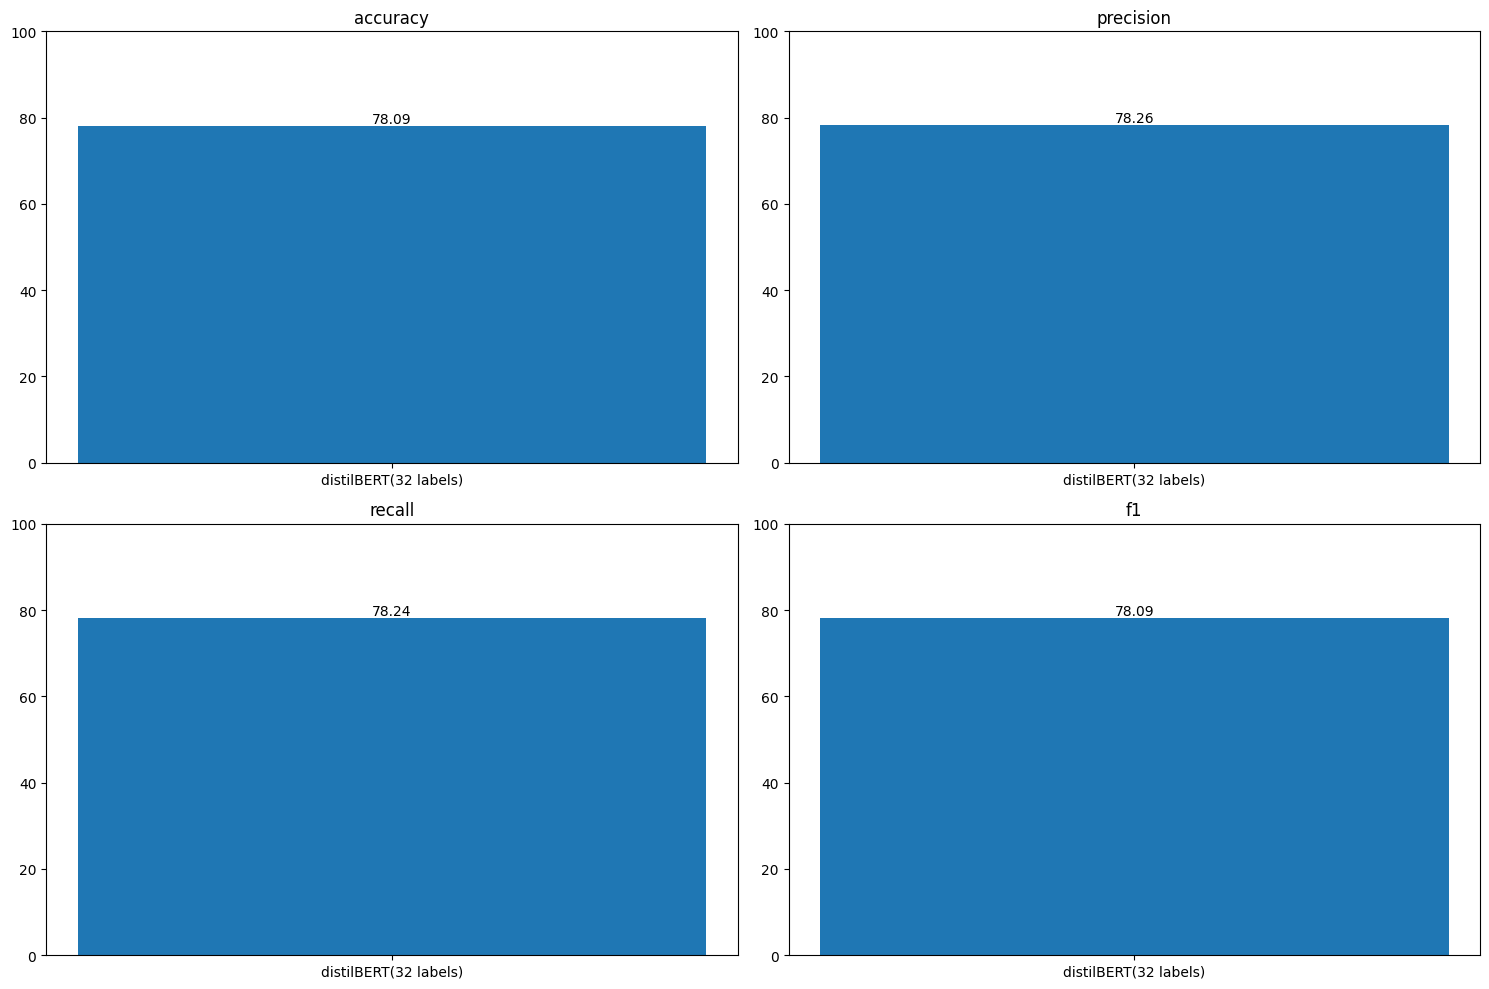

In [74]:
# get the final metrics
metrics_val= Metrics()
metrics_val.run(test_labels, valid_preds, "distilBERT(32 labels)")
metrics_val.plot()
tf.keras.backend.clear_session()

As we see, BERT trained on 32 labels performs slightly better than random. Note that metrics vary in the range [0.52, 0.62], depending on the run, as all batches are randomly assigned.

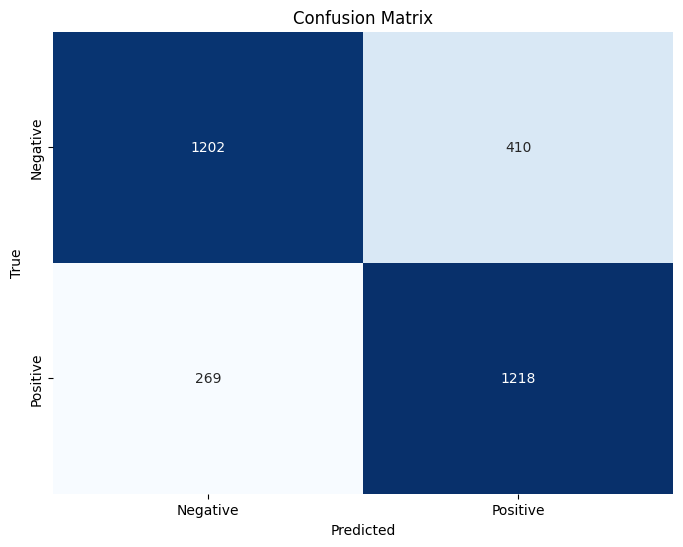

In [75]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels, valid_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## b. Dataset Augmentation

Text data augmentation approaches include:

+ Synonym Replacement: Replace words with their synonyms.
+ Random Insertion: Insert random words into the text.
+ Random Deletion: Randomly delete words from the text.
+ Random Swap: Swap two words randomly in the text.
+ Text Masking: Replace words or phrases with a mask token.

As far as we have very small dataset (DTM is of shape 32:305) I chose not to work with deletion or masking, but rather with synonyms. I thought of two approaches to do so:

### Data Augmentation: Manually Gathered Synonyms

First approach was to analyse the most common words associated with positive and negative sentiments and manually create a dictionary with synonyms. Then, I augmented data with 50 (tried more, but performance was worse, probably bacause of the limited variety of the changes and the fact, that probably misclassified observations could be misclassified now twice) observations and trained the same BERT with augmented data.

In [76]:
# I had slightly different approach, but changed it to Mikel's so to have the same logic throughout the notebook. Will have to move this and next cell to the first exercise later on.
## Preprocessing texts
pipeline = Pipeline([
        ('prepro', TextPreprocessor()),
        ("vect", CountVectorizer(ngram_range=(1, 2), min_df=0.005, max_df=0.97)),
        ("tfidf", TfidfTransformer(use_idf=True, norm='l1'))
    ]
)

# Fit the pipeline on the training data
pipeline.fit(df_train_32['clean_text'])

Pipeline(steps=[('prepro', TextPreprocessor()),
                ('vect',
                 CountVectorizer(max_df=0.97, min_df=0.005,
                                 ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(norm='l1'))])

368


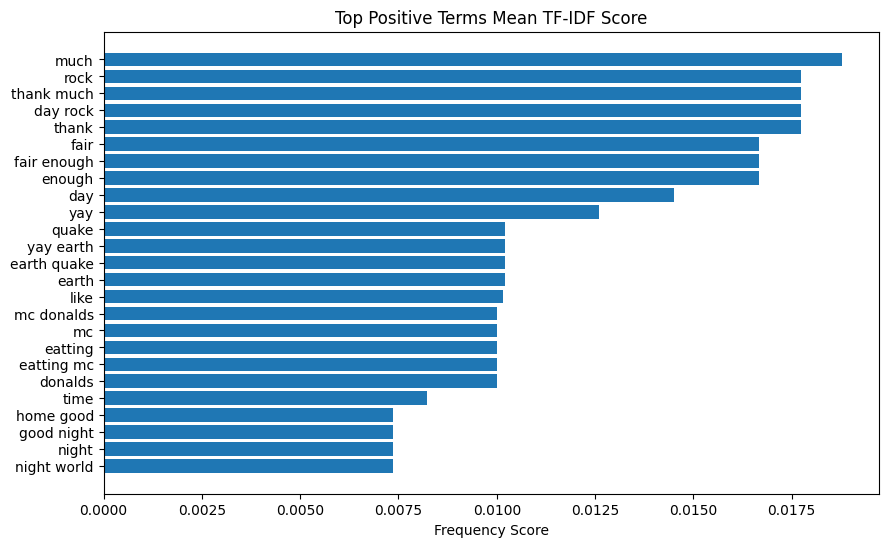

In [77]:
pos = f'Top Positive Terms Mean TF-IDF Score'
## Posive Terms
pos_feature_names, term_tfidf, tfidf_dict = tfidf_term(pipeline,df_train_32,1)
pos_tf_idf = transform_to_dataframe(pos_feature_names,term_tfidf)
plot_freq_top(pos_tf_idf,25,pos)

368


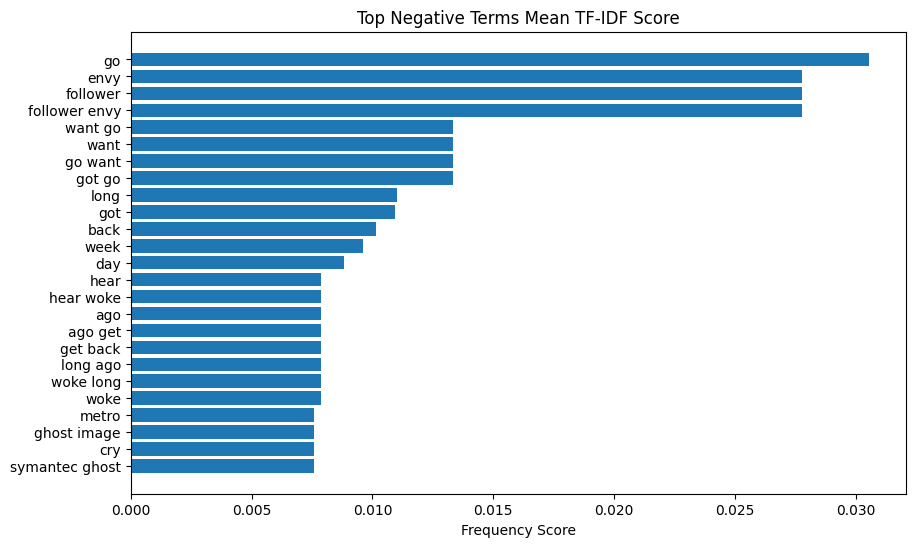

In [78]:
neg = f'Top Negative Terms Mean TF-IDF Score'
## Posive Terms
neg_feature_names, term_tfidf, tfidf_dict = tfidf_term(pipeline,df_train_32,0)
neg_tf_idf = transform_to_dataframe(neg_feature_names,term_tfidf)
plot_freq_top(neg_tf_idf,25,neg)

I got top 'most positive' and 'most negative' terms, manually chose some of them and assigned synonyms.

In [79]:
# Sort the dataframe by the 'score' column in decreasing order
neg_tf_idf_sorted = neg_tf_idf.sort_values(by='score', ascending=False)
pos_tf_idf_sorted = pos_tf_idf.sort_values(by='score', ascending=False)

# Extract the top 25 terms from the sorted dataframe
top_terms_neg = neg_tf_idf_sorted['terms'].head(25).tolist()
top_terms_pos = pos_tf_idf_sorted['terms'].head(25).tolist()

# Print the list of top 25 terms
print(top_terms_neg)
print(top_terms_pos)

['go', 'envy', 'follower', 'follower envy', 'want go', 'want', 'go want', 'got go', 'long', 'got', 'back', 'week', 'day', 'hear', 'hear woke', 'ago', 'ago get', 'get back', 'long ago', 'woke long', 'woke', 'metro', 'ghost image', 'cry', 'symantec ghost']
['much', 'rock', 'thank much', 'day rock', 'thank', 'fair', 'fair enough', 'enough', 'day', 'yay', 'quake', 'yay earth', 'earth quake', 'earth', 'like', 'mc donalds', 'mc', 'eatting', 'eatting mc', 'donalds', 'time', 'home good', 'good night', 'night', 'night world']


In [80]:
synonyms = {
    'go': ['move', 'travel', 'proceed', 'advance'],
    'envy': ['jealousy', 'resentment', 'desire'],
    'follower': ['adherent', 'disciple', 'supporter', 'devotee'],
    'want': ['desire', 'wish', 'crave', 'yearn'],
    'long': ['lengthy', 'extended', 'prolonged', 'distant'],
    'got': ['obtained', 'acquired', 'received', 'possessed'],
    'back': ['rear', 'behind', 'spine', 'reverse'],
    'hear': ['listen', 'perceive', 'catch', 'comprehend'],
    'woke': ['awake','conscious', 'comprehend'],
    'ago': ['in the past', 'back', 'before', 'previously'],
    'get back': ['retrieve', 'return', 'reclaim', 'regain'],
    'long ago': ['many years ago', 'ages ago', 'centuries ago'],
    'ghost image': ['phantom picture', 'spirit image'],
    'cry': ['weep', 'sob', 'shed tears'],
    'much': ['a lot', 'many', 'plenty', 'abundant'],
    'rock': ['stone', 'boulder', 'pebble', 'rocky'],
    'thank': ['express gratitude', 'show appreciation', 'give thanks', 'acknowledge'],
    'fair': ['just', 'acceptable', 'impartial', 'reasonable'],
    'enough': ['sufficient', 'adequate', 'plenty'],
    'like': ['enjoy', 'admire', 'favor', 'approve of'],
    'night': ['evening', 'darkness', 'nighttime', 'nocturnal'],
}

In [81]:
# Function to replace key word with a random synonym
def replace_with_synonym(text, synonyms_dict):
    words = text.split()
    for i, word in enumerate(words):
        if word in synonyms_dict:
            synonyms = synonyms_dict[word]
            # Randomly select a synonym
            new_word = random.choice(synonyms)
            # Replace the key word with the selected synonym
            words[i] = new_word
    return ' '.join(words)

# Initialize an empty DataFrame to store new observations
new_rows = pd.DataFrame(columns=df_train_32.columns)

# Generate additional 50 rows
while len(new_rows) < 50:
    # Identify rows with words from synonyms dictionary
    relevant_rows = df_train_32[df_train_32['clean_text'].apply(lambda x: any(word in synonyms for word in x.split()))]
    # Duplicate each relevant row and replace key word with synonym
    for idx, row in relevant_rows.iterrows():
        new_row = row.copy()
        new_row['clean_text'] = replace_with_synonym(row['clean_text'], synonyms)
        new_rows = new_rows.append(new_row, ignore_index=True)
        if len(new_rows) >= 50:
            break

# Display the new DataFrame with 50 new rows
print(new_rows)

                                                 text label text_length  \
0                     just 10 days for the rockkkkkkk     1           6   
1   @jen004 I hear u! Woke up not long ago &amp; c...     0          13   
2             @TwistedMacSista thank you sooooo much!     1           5   
3   Listening to Slipknot for the first time in ye...     1          25   
4   let's have a moment of silence for our childho...     0          21   
5    Symantec Ghost image corruption is making me cry     0           8   
6   Ugh!!! I'm still at the office.  2 more days t...     0          17   
7                             @DebsSweet fair enough.     1           3   
8                                i have follower envy     0           4   
9   @AdamGoldston My site is gonna be kinda like P...     1          15   
10  @revious thanks  if I can figure out what they...     1          16   
11           I got to go!! But I don't WANT to go....     0          10   
12  @SaraSAFC sounds like

<ipython-input-81-5dc4f9f0cb87>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_rows = new_rows.append(new_row, ignore_index=True)


In [82]:
# Add new_rows to df_train_32
augmented_df = pd.concat([df_train_32, new_rows], ignore_index=True)

# Display the augmented DataFrame shape
print(augmented_df.shape)

(82, 7)


In [83]:
# Define data and labels
augmented_df_data = augmented_df['clean_text']
augmented_df_label = augmented_df['label']

Note, that we will work with the same BERT model, so I will not change anything in the model architecture.

In [84]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(augmented_df_label).reshape(-1, 1)).toarray()

In [85]:
X_train = np.array(augmented_df_data)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# Wrap the batches generator with tqdm
batches_with_progress = tqdm_generator(batches, steps_per_epoch)

from keras.callbacks import EarlyStopping
bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# # Now, pass the wrapped generator to fit
history = bert_model.fit(batches_with_progress, epochs=2, steps_per_epoch=steps_per_epoch)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/2



Epoch:  10%|█         | 1/10 [00:31<04:44, 31.59s/it]

 1/10 [==>...........................] - ETA: 4:50 - loss: 0.4430 - recall: 0.7500 - precision: 0.7500


Epoch:  30%|███       | 3/10 [00:32<00:59,  8.47s/it]

 2/10 [=====>........................] - ETA: 6s - loss: 0.5662 - recall: 0.7500 - precision: 0.7500  


Epoch:  40%|████      | 4/10 [00:33<00:34,  5.81s/it]

 3/10 [========>.....................] - ETA: 5s - loss: 0.6121 - recall: 0.7083 - precision: 0.7083


Epoch:  50%|█████     | 5/10 [00:33<00:20,  4.15s/it]

 4/10 [===========>..................] - ETA: 4s - loss: 0.6420 - recall: 0.6875 - precision: 0.6875


Epoch:  60%|██████    | 6/10 [00:34<00:12,  3.07s/it]

 5/10 [==============>...............] - ETA: 3s - loss: 0.5723 - recall: 0.7500 - precision: 0.7500


Epoch:  70%|███████   | 7/10 [00:35<00:07,  2.34s/it]

 6/10 [=================>............] - ETA: 3s - loss: 0.5440 - recall: 0.7500 - precision: 0.7500


Epoch:  80%|████████  | 8/10 [00:36<00:03,  1.86s/it]

 7/10 [====================>.........] - ETA: 2s - loss: 0.4900 - recall: 0.7679 - precision: 0.7679


Epoch:  90%|█████████ | 9/10 [00:37<00:01,  1.53s/it]

 8/10 [=======================>......] - ETA: 1s - loss: 0.4484 - recall: 0.7969 - precision: 0.7969


Epoch: 100%|██████████| 10/10 [00:37<00:00,  1.30s/it]

 9/10 [==========================>...] - ETA: 0s - loss: 0.4065 - recall: 0.8194 - precision: 0.8194


Epoch: 11it [00:38,  1.14s/it]                        

10/10 [==============================] - 39s 781ms/step - loss: 0.3991 - recall: 0.8250 - precision: 0.8250
Epoch 2/2



Epoch: 12it [00:39,  1.03s/it]

 1/10 [==>...........................] - ETA: 5s - loss: 0.2972 - recall: 1.0000 - precision: 1.0000


Epoch: 13it [00:39,  1.12it/s]

 2/10 [=====>........................] - ETA: 6s - loss: 0.0700 - recall: 1.0000 - precision: 1.0000


Epoch: 14it [00:40,  1.13it/s]

 3/10 [========>.....................] - ETA: 5s - loss: 0.1340 - recall: 0.9444 - precision: 0.9444


Epoch: 15it [00:41,  1.17it/s]

 4/10 [===========>..................] - ETA: 4s - loss: 0.1491 - recall: 0.9231 - precision: 0.9231


Epoch: 16it [00:42,  1.21it/s]

 5/10 [==============>...............] - ETA: 3s - loss: 0.2859 - recall: 0.8824 - precision: 0.8824


Epoch: 17it [00:43,  1.24it/s]

 6/10 [=================>............] - ETA: 3s - loss: 0.2342 - recall: 0.9048 - precision: 0.9048


Epoch: 18it [00:43,  1.27it/s]

 7/10 [====================>.........] - ETA: 2s - loss: 0.1979 - recall: 0.9200 - precision: 0.9200


Epoch: 19it [00:44,  1.28it/s]

 8/10 [=======================>......] - ETA: 1s - loss: 0.2062 - recall: 0.9138 - precision: 0.9138


Epoch: 20it [00:45,  1.30it/s]

 9/10 [==========================>...] - ETA: 0s - loss: 0.1824 - recall: 0.9242 - precision: 0.9242


Epoch: 21it [00:46,  1.29it/s]

10/10 [==============================] - 8s 774ms/step - loss: 0.2061 - recall: 0.9054 - precision: 0.9054


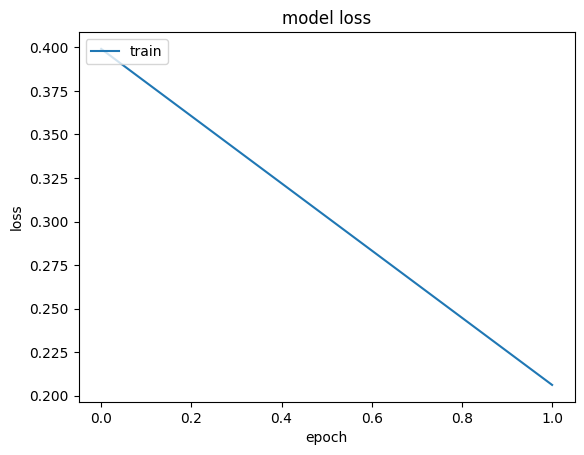

In [86]:
# Skip the first 10 epochs (index 0 to 9) and start plotting from the 11th epoch (index 10)
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# Adjusted the legend to include both 'train' and 'val' for clarity
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [87]:
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(test_data),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
valid_preds = bert_model.predict(inputs_valid)
valid_preds = np.argmax(valid_preds, axis=1)

97/97 [==============================] - 40s 383ms/step


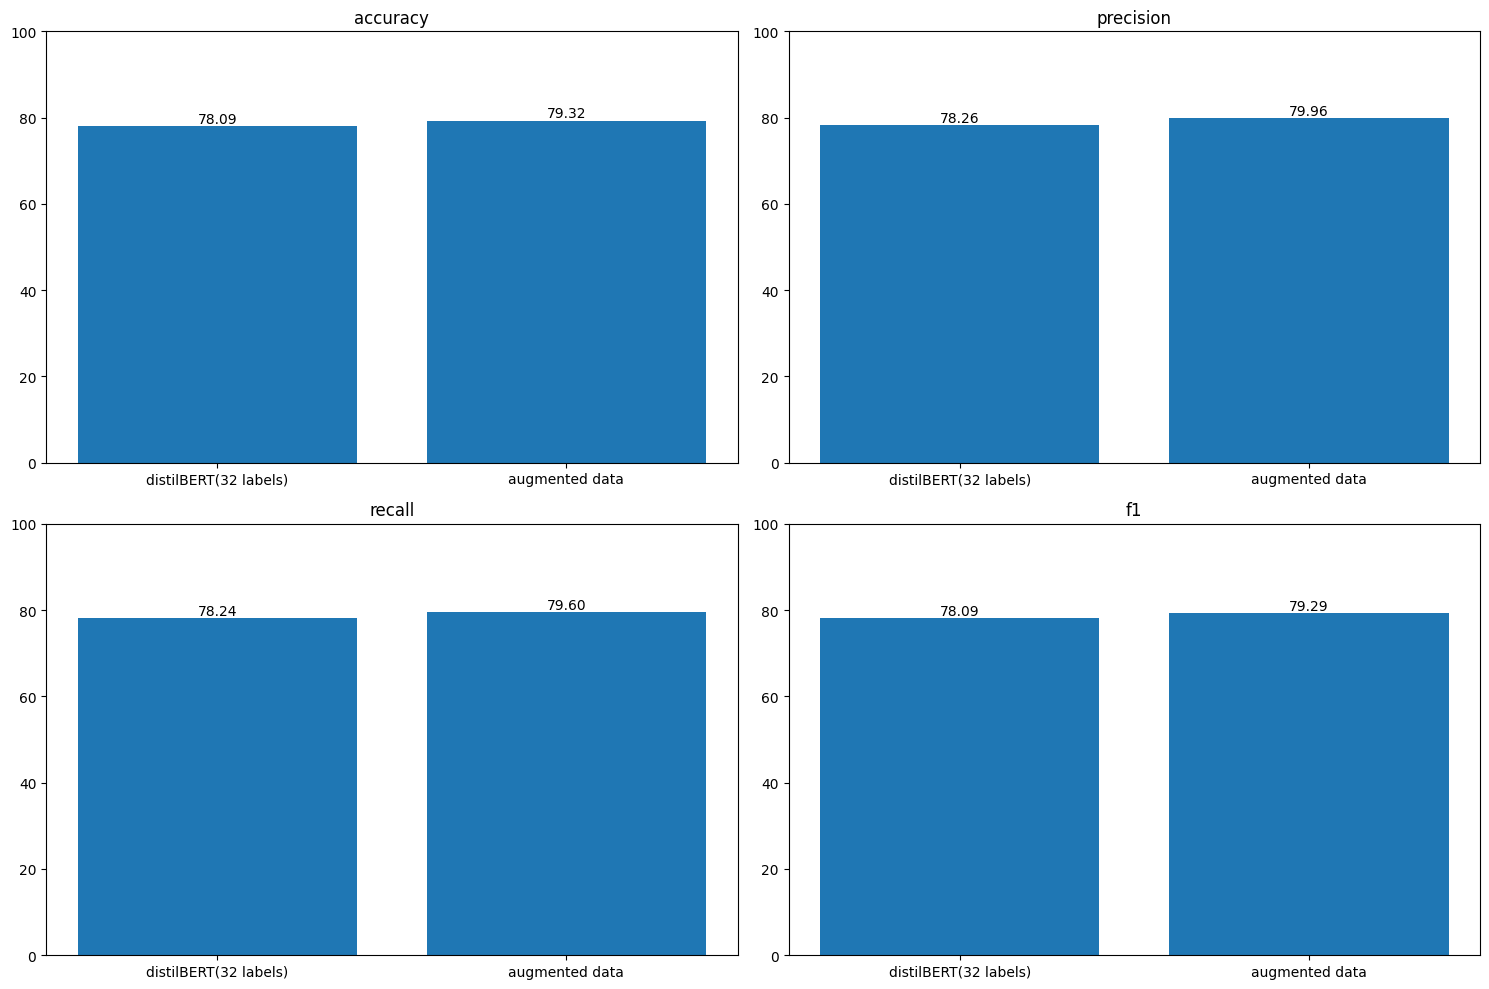

In [88]:
# get the final metrics
metrics_val.run(test_labels, valid_preds, "augmented data")
metrics_val.plot()
tf.keras.backend.clear_session()

### Data Augmentation: Synonyms from WordNet

I didn't choose to work with WordNet packages in the beginning, as far as synonyms look kind of random and don't usually properly reflect the meaning of the word (probably because of multiple meanings) and don't consider the context. But as far as I couldn't manually assign synonyms to all (or at least many) tokens, I decided to try WordNet as well.

So the second approach is to rendomly change 30% of the tokens in the comments (I tried different shares, 30% performed better) and add 32*20 (tried different numbers as well) new rows.

In [89]:
# Function to get synonyms from WordNet
def get_wordnet_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
    return synonyms

# Function to replace random words with WordNet synonyms
def replace_with_synonym_wordnet(text):
    words = text.split()
    for i, word in enumerate(words):
        # Randomly decide whether to replace the word with a synonym
        if random.random() < 0.3:  # Adjust the probability as needed
            # Get WordNet synonyms for the word
            synonyms = get_wordnet_synonyms(word)
            if synonyms:
                # Randomly select a synonym
                new_word = random.choice(synonyms)
                # Replace the word with the selected synonym
                words[i] = new_word
    return ' '.join(words)

# Duplicate each row and replace random words with WordNet synonyms
new_rows = pd.DataFrame(columns=df_train_32.columns)
for idx, row in df_train_32.iterrows():
    for _ in range(20):  # Duplicate 20 times - can be adjusted as needed
        # Duplicate the row
        new_row = row.copy()
        # Replace random words in the 'clean_text' column with WordNet synonyms
        new_row['clean_text'] = replace_with_synonym_wordnet(row['clean_text'])
        # Append the new row to the DataFrame
        new_rows = new_rows.append(new_row, ignore_index=True)

# Display the new DataFrame with duplicated rows and random word replacements
print(new_rows.head())


<ipython-input-89-a44f8c0859a0>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_rows = new_rows.append(new_row, ignore_index=True)


                              text label text_length  \
0  just 10 days for the rockkkkkkk     1           6   
1  just 10 days for the rockkkkkkk     1           6   
2  just 10 days for the rockkkkkkk     1           6   
3  just 10 days for the rockkkkkkk     1           6   
4  just 10 days for the rockkkkkkk     1           6   

                  clean_text clean_emotions hashtag             text_emotion  
0     just days for the rock                         just days for the rock   
1  exactly days for the rock                         just days for the rock   
2      just day for the rock                         just days for the rock   
3      just day for the rock                         just days for the rock   
4     just days for the rock                         just days for the rock   


From the printed first rows you actually may see (comparing text and clean text, which was duplicated), that synonyms are kind of weird.

In [90]:
# Add new_rows to df_train_32
augmented_df = pd.concat([df_train_32, new_rows], ignore_index=True)

# Display the augmented DataFrame
print(augmented_df.shape)

(672, 7)


In [91]:
augmented_df_data = augmented_df['clean_text']
augmented_df_label = augmented_df['label']

In [92]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(augmented_df_label).reshape(-1, 1)).toarray()

In [93]:
X_train = np.array(augmented_df_data)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# Wrap the batches generator with tqdm
batches_with_progress = tqdm_generator(batches, steps_per_epoch)

bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# Now, pass the wrapped generator to fit

history = bert_model.fit(batches_with_progress, epochs=2, steps_per_epoch=steps_per_epoch)



Epoch:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 1/2




Epoch:   1%|          | 1/84 [00:30<42:26, 30.68s/it]

 1/84 [..............................] - ETA: 43:18 - loss: 0.0023 - recall: 1.0000 - precision: 1.0000



Epoch:   4%|▎         | 3/84 [00:31<11:06,  8.23s/it]

 2/84 [..............................] - ETA: 1:05 - loss: 0.1589 - recall: 0.9375 - precision: 0.9375 



Epoch:   5%|▍         | 4/84 [00:32<07:32,  5.66s/it]

 3/84 [>.............................] - ETA: 1:04 - loss: 0.1074 - recall: 0.9583 - precision: 0.9583



Epoch:   6%|▌         | 5/84 [00:33<05:19,  4.05s/it]

 4/84 [>.............................] - ETA: 1:03 - loss: 0.1098 - recall: 0.9688 - precision: 0.9688



Epoch:   7%|▋         | 6/84 [00:33<03:54,  3.00s/it]

 5/84 [>.............................] - ETA: 1:01 - loss: 0.0900 - recall: 0.9750 - precision: 0.9750



Epoch:   8%|▊         | 7/84 [00:34<02:56,  2.30s/it]

 6/84 [=>............................] - ETA: 1:00 - loss: 0.0764 - recall: 0.9792 - precision: 0.9792



Epoch:  10%|▉         | 8/84 [00:35<02:18,  1.82s/it]

 7/84 [=>............................] - ETA: 59s - loss: 0.0658 - recall: 0.9821 - precision: 0.9821 



Epoch:  11%|█         | 9/84 [00:36<01:52,  1.49s/it]

 8/84 [=>............................] - ETA: 59s - loss: 0.0650 - recall: 0.9844 - precision: 0.9844



Epoch:  12%|█▏        | 10/84 [00:36<01:34,  1.28s/it]

 9/84 [==>...........................] - ETA: 58s - loss: 0.0764 - recall: 0.9722 - precision: 0.9722



Epoch:  13%|█▎        | 11/84 [00:37<01:22,  1.13s/it]

10/84 [==>...........................] - ETA: 57s - loss: 0.0741 - recall: 0.9750 - precision: 0.9750



Epoch:  14%|█▍        | 12/84 [00:38<01:13,  1.02s/it]

11/84 [==>...........................] - ETA: 56s - loss: 0.0715 - recall: 0.9773 - precision: 0.9773



Epoch:  15%|█▌        | 13/84 [00:39<01:06,  1.06it/s]

12/84 [===>..........................] - ETA: 55s - loss: 0.0703 - recall: 0.9792 - precision: 0.9792



Epoch:  17%|█▋        | 14/84 [00:39<01:02,  1.13it/s]

13/84 [===>..........................] - ETA: 54s - loss: 0.0754 - recall: 0.9712 - precision: 0.9712



Epoch:  18%|█▊        | 15/84 [00:40<00:58,  1.18it/s]

14/84 [====>.........................] - ETA: 54s - loss: 0.0720 - recall: 0.9732 - precision: 0.9732



Epoch:  19%|█▉        | 16/84 [00:41<00:56,  1.21it/s]

15/84 [====>.........................] - ETA: 53s - loss: 0.0674 - recall: 0.9750 - precision: 0.9750



Epoch:  20%|██        | 17/84 [00:42<00:54,  1.24it/s]

16/84 [====>.........................] - ETA: 52s - loss: 0.0678 - recall: 0.9766 - precision: 0.9766



Epoch:  21%|██▏       | 18/84 [00:43<00:52,  1.25it/s]

17/84 [=====>........................] - ETA: 51s - loss: 0.0639 - recall: 0.9779 - precision: 0.9779



Epoch:  23%|██▎       | 19/84 [00:43<00:51,  1.26it/s]

18/84 [=====>........................] - ETA: 50s - loss: 0.1092 - recall: 0.9722 - precision: 0.9722



Epoch:  24%|██▍       | 20/84 [00:44<00:49,  1.28it/s]

19/84 [=====>........................] - ETA: 50s - loss: 0.1157 - recall: 0.9671 - precision: 0.9671



Epoch:  25%|██▌       | 21/84 [00:45<00:48,  1.29it/s]

20/84 [======>.......................] - ETA: 49s - loss: 0.1100 - recall: 0.9688 - precision: 0.9688



Epoch:  26%|██▌       | 22/84 [00:46<00:47,  1.30it/s]

21/84 [======>.......................] - ETA: 48s - loss: 0.1050 - recall: 0.9702 - precision: 0.9702



Epoch:  27%|██▋       | 23/84 [00:46<00:47,  1.29it/s]

22/84 [======>.......................] - ETA: 47s - loss: 0.1020 - recall: 0.9716 - precision: 0.9716



Epoch:  29%|██▊       | 24/84 [00:47<00:46,  1.30it/s]

23/84 [=======>......................] - ETA: 47s - loss: 0.0983 - recall: 0.9728 - precision: 0.9728



Epoch:  30%|██▉       | 25/84 [00:48<00:45,  1.30it/s]

24/84 [=======>......................] - ETA: 46s - loss: 0.0943 - recall: 0.9740 - precision: 0.9740



Epoch:  31%|███       | 26/84 [00:49<00:44,  1.30it/s]

25/84 [=======>......................] - ETA: 45s - loss: 0.0917 - recall: 0.9750 - precision: 0.9750



Epoch:  32%|███▏      | 27/84 [00:49<00:43,  1.30it/s]

26/84 [========>.....................] - ETA: 44s - loss: 0.0887 - recall: 0.9760 - precision: 0.9760



Epoch:  33%|███▎      | 28/84 [00:50<00:42,  1.32it/s]

27/84 [========>.....................] - ETA: 43s - loss: 0.0901 - recall: 0.9769 - precision: 0.9769



Epoch:  35%|███▍      | 29/84 [00:51<00:41,  1.33it/s]

28/84 [=========>....................] - ETA: 43s - loss: 0.0871 - recall: 0.9777 - precision: 0.9777



Epoch:  36%|███▌      | 30/84 [00:52<00:41,  1.30it/s]

29/84 [=========>....................] - ETA: 42s - loss: 0.0851 - recall: 0.9784 - precision: 0.9784



Epoch:  37%|███▋      | 31/84 [00:52<00:40,  1.31it/s]

30/84 [=========>....................] - ETA: 41s - loss: 0.0831 - recall: 0.9792 - precision: 0.9792



Epoch:  38%|███▊      | 32/84 [00:53<00:39,  1.30it/s]

31/84 [==========>...................] - ETA: 40s - loss: 0.0816 - recall: 0.9798 - precision: 0.9798



Epoch:  39%|███▉      | 33/84 [00:54<00:39,  1.31it/s]

32/84 [==========>...................] - ETA: 40s - loss: 0.0792 - recall: 0.9805 - precision: 0.9805



Epoch:  40%|████      | 34/84 [00:55<00:38,  1.29it/s]

33/84 [==========>...................] - ETA: 39s - loss: 0.0770 - recall: 0.9811 - precision: 0.9811



Epoch:  42%|████▏     | 35/84 [00:56<00:38,  1.28it/s]

34/84 [===========>..................] - ETA: 38s - loss: 0.0800 - recall: 0.9816 - precision: 0.9816



Epoch:  43%|████▎     | 36/84 [00:56<00:36,  1.30it/s]

35/84 [===========>..................] - ETA: 37s - loss: 0.0794 - recall: 0.9821 - precision: 0.9821



Epoch:  44%|████▍     | 37/84 [00:57<00:36,  1.30it/s]

36/84 [===========>..................] - ETA: 36s - loss: 0.0774 - recall: 0.9826 - precision: 0.9826



Epoch:  45%|████▌     | 38/84 [00:58<00:35,  1.29it/s]

37/84 [============>.................] - ETA: 36s - loss: 0.0754 - recall: 0.9831 - precision: 0.9831



Epoch:  46%|████▋     | 39/84 [00:59<00:34,  1.29it/s]

38/84 [============>.................] - ETA: 35s - loss: 0.0764 - recall: 0.9803 - precision: 0.9803



Epoch:  48%|████▊     | 40/84 [00:59<00:34,  1.27it/s]

39/84 [============>.................] - ETA: 34s - loss: 0.0938 - recall: 0.9776 - precision: 0.9776



Epoch:  49%|████▉     | 41/84 [01:00<00:33,  1.28it/s]

40/84 [=============>................] - ETA: 33s - loss: 0.0915 - recall: 0.9781 - precision: 0.9781



Epoch:  50%|█████     | 42/84 [01:01<00:32,  1.30it/s]

41/84 [=============>................] - ETA: 33s - loss: 0.0893 - recall: 0.9787 - precision: 0.9787



Epoch:  51%|█████     | 43/84 [01:02<00:31,  1.30it/s]

42/84 [==============>...............] - ETA: 32s - loss: 0.0873 - recall: 0.9792 - precision: 0.9792



Epoch:  52%|█████▏    | 44/84 [01:03<00:30,  1.29it/s]

43/84 [==============>...............] - ETA: 31s - loss: 0.0854 - recall: 0.9797 - precision: 0.9797



Epoch:  54%|█████▎    | 45/84 [01:03<00:30,  1.27it/s]

44/84 [==============>...............] - ETA: 30s - loss: 0.0836 - recall: 0.9801 - precision: 0.9801



Epoch:  55%|█████▍    | 46/84 [01:04<00:30,  1.25it/s]

45/84 [===============>..............] - ETA: 30s - loss: 0.0820 - recall: 0.9806 - precision: 0.9806



Epoch:  56%|█████▌    | 47/84 [01:05<00:29,  1.25it/s]

46/84 [===============>..............] - ETA: 29s - loss: 0.0803 - recall: 0.9810 - precision: 0.9810



Epoch:  57%|█████▋    | 48/84 [01:06<00:28,  1.26it/s]

47/84 [===============>..............] - ETA: 28s - loss: 0.0788 - recall: 0.9814 - precision: 0.9814



Epoch:  58%|█████▊    | 49/84 [01:07<00:27,  1.27it/s]

48/84 [================>.............] - ETA: 27s - loss: 0.0772 - recall: 0.9818 - precision: 0.9818



Epoch:  60%|█████▉    | 50/84 [01:07<00:26,  1.29it/s]

49/84 [================>.............] - ETA: 27s - loss: 0.0842 - recall: 0.9796 - precision: 0.9796



Epoch:  61%|██████    | 51/84 [01:08<00:25,  1.30it/s]

50/84 [================>.............] - ETA: 26s - loss: 0.0992 - recall: 0.9775 - precision: 0.9775



Epoch:  62%|██████▏   | 52/84 [01:09<00:24,  1.30it/s]

51/84 [=================>............] - ETA: 25s - loss: 0.0973 - recall: 0.9779 - precision: 0.9779



Epoch:  63%|██████▎   | 53/84 [01:10<00:24,  1.28it/s]

52/84 [=================>............] - ETA: 24s - loss: 0.0954 - recall: 0.9784 - precision: 0.9784



Epoch:  64%|██████▍   | 54/84 [01:10<00:23,  1.28it/s]

53/84 [=================>............] - ETA: 23s - loss: 0.0938 - recall: 0.9788 - precision: 0.9788



Epoch:  65%|██████▌   | 55/84 [01:11<00:22,  1.29it/s]

54/84 [==================>...........] - ETA: 23s - loss: 0.0926 - recall: 0.9792 - precision: 0.9792



Epoch:  67%|██████▋   | 56/84 [01:12<00:21,  1.29it/s]

55/84 [==================>...........] - ETA: 22s - loss: 0.0910 - recall: 0.9795 - precision: 0.9795



Epoch:  68%|██████▊   | 57/84 [01:13<00:20,  1.31it/s]

56/84 [===================>..........] - ETA: 21s - loss: 0.0894 - recall: 0.9799 - precision: 0.9799



Epoch:  69%|██████▉   | 58/84 [01:13<00:20,  1.30it/s]

57/84 [===================>..........] - ETA: 20s - loss: 0.0879 - recall: 0.9803 - precision: 0.9803



Epoch:  70%|███████   | 59/84 [01:14<00:19,  1.30it/s]

58/84 [===================>..........] - ETA: 20s - loss: 0.1066 - recall: 0.9784 - precision: 0.9784



Epoch:  71%|███████▏  | 60/84 [01:15<00:18,  1.30it/s]

59/84 [====================>.........] - ETA: 19s - loss: 0.1147 - recall: 0.9767 - precision: 0.9767



Epoch:  73%|███████▎  | 61/84 [01:16<00:17,  1.30it/s]

60/84 [====================>.........] - ETA: 18s - loss: 0.1203 - recall: 0.9729 - precision: 0.9729



Epoch:  74%|███████▍  | 62/84 [01:16<00:16,  1.31it/s]

61/84 [====================>.........] - ETA: 17s - loss: 0.1194 - recall: 0.9734 - precision: 0.9734



Epoch:  75%|███████▌  | 63/84 [01:17<00:15,  1.33it/s]

62/84 [=====================>........] - ETA: 16s - loss: 0.1175 - recall: 0.9738 - precision: 0.9738



Epoch:  76%|███████▌  | 64/84 [01:18<00:15,  1.31it/s]

63/84 [=====================>........] - ETA: 16s - loss: 0.1157 - recall: 0.9742 - precision: 0.9742



Epoch:  77%|███████▋  | 65/84 [01:19<00:14,  1.31it/s]

64/84 [=====================>........] - ETA: 15s - loss: 0.1140 - recall: 0.9746 - precision: 0.9746



Epoch:  79%|███████▊  | 66/84 [01:20<00:14,  1.28it/s]

65/84 [======================>.......] - ETA: 14s - loss: 0.1137 - recall: 0.9750 - precision: 0.9750



Epoch:  80%|███████▉  | 67/84 [01:20<00:13,  1.30it/s]

66/84 [======================>.......] - ETA: 13s - loss: 0.1123 - recall: 0.9754 - precision: 0.9754



Epoch:  81%|████████  | 68/84 [01:21<00:12,  1.30it/s]

67/84 [======================>.......] - ETA: 13s - loss: 0.1111 - recall: 0.9757 - precision: 0.9757



Epoch:  82%|████████▏ | 69/84 [01:22<00:11,  1.30it/s]

68/84 [=======================>......] - ETA: 12s - loss: 0.1101 - recall: 0.9761 - precision: 0.9761



Epoch:  83%|████████▎ | 70/84 [01:23<00:10,  1.33it/s]

69/84 [=======================>......] - ETA: 11s - loss: 0.1093 - recall: 0.9764 - precision: 0.9764



Epoch:  85%|████████▍ | 71/84 [01:23<00:09,  1.31it/s]

70/84 [========================>.....] - ETA: 10s - loss: 0.1080 - recall: 0.9768 - precision: 0.9768



Epoch:  86%|████████▌ | 72/84 [01:24<00:09,  1.31it/s]

71/84 [========================>.....] - ETA: 10s - loss: 0.1089 - recall: 0.9771 - precision: 0.9771



Epoch:  87%|████████▋ | 73/84 [01:25<00:08,  1.30it/s]

72/84 [========================>.....] - ETA: 9s - loss: 0.1082 - recall: 0.9774 - precision: 0.9774 



Epoch:  88%|████████▊ | 74/84 [01:26<00:07,  1.30it/s]

73/84 [=========================>....] - ETA: 8s - loss: 0.1084 - recall: 0.9760 - precision: 0.9760



Epoch:  89%|████████▉ | 75/84 [01:26<00:06,  1.29it/s]

74/84 [=========================>....] - ETA: 7s - loss: 0.1090 - recall: 0.9747 - precision: 0.9747



Epoch:  90%|█████████ | 76/84 [01:27<00:06,  1.29it/s]

75/84 [=========================>....] - ETA: 6s - loss: 0.1085 - recall: 0.9750 - precision: 0.9750



Epoch:  92%|█████████▏| 77/84 [01:28<00:05,  1.31it/s]

76/84 [==========================>...] - ETA: 6s - loss: 0.1072 - recall: 0.9753 - precision: 0.9753



Epoch:  93%|█████████▎| 78/84 [01:29<00:04,  1.30it/s]

77/84 [==========================>...] - ETA: 5s - loss: 0.1178 - recall: 0.9740 - precision: 0.9740



Epoch:  94%|█████████▍| 79/84 [01:30<00:03,  1.30it/s]

78/84 [==========================>...] - ETA: 4s - loss: 0.1165 - recall: 0.9744 - precision: 0.9744



Epoch:  95%|█████████▌| 80/84 [01:30<00:03,  1.30it/s]

79/84 [===========================>..] - ETA: 3s - loss: 0.1151 - recall: 0.9747 - precision: 0.9747



Epoch:  96%|█████████▋| 81/84 [01:31<00:02,  1.32it/s]

80/84 [===========================>..] - ETA: 3s - loss: 0.1136 - recall: 0.9750 - precision: 0.9750



Epoch:  98%|█████████▊| 82/84 [01:32<00:01,  1.32it/s]

81/84 [===========================>..] - ETA: 2s - loss: 0.1122 - recall: 0.9753 - precision: 0.9753



Epoch:  99%|█████████▉| 83/84 [01:33<00:00,  1.29it/s]

82/84 [============================>.] - ETA: 1s - loss: 0.1109 - recall: 0.9756 - precision: 0.9756



Epoch: 100%|██████████| 84/84 [01:33<00:00,  1.28it/s]

83/84 [============================>.] - ETA: 0s - loss: 0.1096 - recall: 0.9759 - precision: 0.9759



Epoch: 85it [01:34,  1.28it/s]                        

84/84 [==============================] - 95s 772ms/step - loss: 0.1083 - recall: 0.9762 - precision: 0.9762
Epoch 2/2




Epoch: 86it [01:35,  1.27it/s]

 1/84 [..............................] - ETA: 1:05 - loss: 0.0032 - recall: 1.0000 - precision: 1.0000



Epoch: 87it [01:36,  1.27it/s]

 2/84 [..............................] - ETA: 1:03 - loss: 0.0017 - recall: 1.0000 - precision: 1.0000



Epoch: 88it [01:37,  1.28it/s]

 3/84 [>.............................] - ETA: 1:02 - loss: 0.0506 - recall: 0.9583 - precision: 0.9583



Epoch: 89it [01:37,  1.29it/s]

 4/84 [>.............................] - ETA: 1:00 - loss: 0.0379 - recall: 0.9688 - precision: 0.9688



Epoch: 90it [01:38,  1.30it/s]

 5/84 [>.............................] - ETA: 1:00 - loss: 0.0329 - recall: 0.9750 - precision: 0.9750



Epoch: 91it [01:39,  1.31it/s]

 6/84 [=>............................] - ETA: 59s - loss: 0.0277 - recall: 0.9792 - precision: 0.9792 



Epoch: 92it [01:40,  1.30it/s]

 7/84 [=>............................] - ETA: 58s - loss: 0.0247 - recall: 0.9821 - precision: 0.9821



Epoch: 93it [01:40,  1.30it/s]

 8/84 [=>............................] - ETA: 58s - loss: 0.0217 - recall: 0.9844 - precision: 0.9844



Epoch: 94it [01:41,  1.29it/s]

 9/84 [==>...........................] - ETA: 57s - loss: 0.0194 - recall: 0.9861 - precision: 0.9861



Epoch: 95it [01:42,  1.30it/s]

10/84 [==>...........................] - ETA: 56s - loss: 0.0175 - recall: 0.9875 - precision: 0.9875



Epoch: 96it [01:43,  1.30it/s]

11/84 [==>...........................] - ETA: 55s - loss: 0.0160 - recall: 0.9886 - precision: 0.9886



Epoch: 97it [01:43,  1.30it/s]

12/84 [===>..........................] - ETA: 55s - loss: 0.0148 - recall: 0.9896 - precision: 0.9896



Epoch: 98it [01:44,  1.31it/s]

13/84 [===>..........................] - ETA: 54s - loss: 0.0139 - recall: 0.9904 - precision: 0.9904



Epoch: 99it [01:45,  1.32it/s]

14/84 [====>.........................] - ETA: 53s - loss: 0.0131 - recall: 0.9911 - precision: 0.9911



Epoch: 100it [01:46,  1.32it/s]

15/84 [====>.........................] - ETA: 52s - loss: 0.0140 - recall: 0.9917 - precision: 0.9917



Epoch: 101it [01:46,  1.32it/s]

16/84 [====>.........................] - ETA: 51s - loss: 0.0133 - recall: 0.9922 - precision: 0.9922



Epoch: 102it [01:47,  1.32it/s]

17/84 [=====>........................] - ETA: 50s - loss: 0.0126 - recall: 0.9926 - precision: 0.9926



Epoch: 103it [01:48,  1.34it/s]

18/84 [=====>........................] - ETA: 50s - loss: 0.0122 - recall: 0.9931 - precision: 0.9931



Epoch: 104it [01:49,  1.33it/s]

19/84 [=====>........................] - ETA: 49s - loss: 0.0118 - recall: 0.9934 - precision: 0.9934



Epoch: 105it [01:49,  1.31it/s]

20/84 [======>.......................] - ETA: 48s - loss: 0.0112 - recall: 0.9937 - precision: 0.9937



Epoch: 106it [01:50,  1.31it/s]

21/84 [======>.......................] - ETA: 47s - loss: 0.0107 - recall: 0.9940 - precision: 0.9940



Epoch: 107it [01:51,  1.32it/s]

22/84 [======>.......................] - ETA: 47s - loss: 0.0105 - recall: 0.9943 - precision: 0.9943



Epoch: 108it [01:52,  1.32it/s]

23/84 [=======>......................] - ETA: 46s - loss: 0.0100 - recall: 0.9946 - precision: 0.9946



Epoch: 109it [01:53,  1.33it/s]

24/84 [=======>......................] - ETA: 45s - loss: 0.0096 - recall: 0.9948 - precision: 0.9948



Epoch: 110it [01:53,  1.31it/s]

25/84 [=======>......................] - ETA: 44s - loss: 0.0416 - recall: 0.9900 - precision: 0.9900



Epoch: 111it [01:54,  1.30it/s]

26/84 [========>.....................] - ETA: 44s - loss: 0.0400 - recall: 0.9904 - precision: 0.9904



Epoch: 112it [01:55,  1.30it/s]

27/84 [========>.....................] - ETA: 43s - loss: 0.0386 - recall: 0.9907 - precision: 0.9907



Epoch: 113it [01:56,  1.29it/s]

28/84 [=========>....................] - ETA: 42s - loss: 0.0375 - recall: 0.9911 - precision: 0.9911



Epoch: 114it [01:56,  1.31it/s]

29/84 [=========>....................] - ETA: 41s - loss: 0.0363 - recall: 0.9914 - precision: 0.9914



Epoch: 115it [01:57,  1.30it/s]

30/84 [=========>....................] - ETA: 41s - loss: 0.0351 - recall: 0.9917 - precision: 0.9917



Epoch: 116it [01:58,  1.29it/s]

31/84 [==========>...................] - ETA: 40s - loss: 0.0340 - recall: 0.9919 - precision: 0.9919



Epoch: 117it [01:59,  1.30it/s]

32/84 [==========>...................] - ETA: 39s - loss: 0.0331 - recall: 0.9922 - precision: 0.9922



Epoch: 118it [01:59,  1.30it/s]

33/84 [==========>...................] - ETA: 38s - loss: 0.0322 - recall: 0.9924 - precision: 0.9924



Epoch: 119it [02:00,  1.31it/s]

34/84 [===========>..................] - ETA: 38s - loss: 0.0319 - recall: 0.9926 - precision: 0.9926



Epoch: 120it [02:01,  1.33it/s]

35/84 [===========>..................] - ETA: 37s - loss: 0.0313 - recall: 0.9929 - precision: 0.9929



Epoch: 121it [02:02,  1.32it/s]

36/84 [===========>..................] - ETA: 36s - loss: 0.0313 - recall: 0.9931 - precision: 0.9931



Epoch: 122it [02:03,  1.30it/s]

37/84 [============>.................] - ETA: 35s - loss: 0.0305 - recall: 0.9932 - precision: 0.9932



Epoch: 123it [02:03,  1.29it/s]

38/84 [============>.................] - ETA: 35s - loss: 0.0306 - recall: 0.9934 - precision: 0.9934



Epoch: 124it [02:04,  1.31it/s]

39/84 [============>.................] - ETA: 34s - loss: 0.0300 - recall: 0.9936 - precision: 0.9936



Epoch: 125it [02:05,  1.33it/s]

40/84 [=============>................] - ETA: 33s - loss: 0.0294 - recall: 0.9937 - precision: 0.9937



Epoch: 126it [02:06,  1.32it/s]

41/84 [=============>................] - ETA: 32s - loss: 0.0288 - recall: 0.9939 - precision: 0.9939



Epoch: 127it [02:06,  1.33it/s]

42/84 [==============>...............] - ETA: 31s - loss: 0.0284 - recall: 0.9940 - precision: 0.9940



Epoch: 128it [02:07,  1.34it/s]

43/84 [==============>...............] - ETA: 31s - loss: 0.0279 - recall: 0.9942 - precision: 0.9942



Epoch: 129it [02:08,  1.34it/s]

44/84 [==============>...............] - ETA: 30s - loss: 0.0272 - recall: 0.9943 - precision: 0.9943



Epoch: 130it [02:08,  1.36it/s]

45/84 [===============>..............] - ETA: 29s - loss: 0.0267 - recall: 0.9944 - precision: 0.9944



Epoch: 131it [02:09,  1.32it/s]

46/84 [===============>..............] - ETA: 28s - loss: 0.0288 - recall: 0.9918 - precision: 0.9918



Epoch: 132it [02:10,  1.30it/s]

47/84 [===============>..............] - ETA: 28s - loss: 0.0283 - recall: 0.9920 - precision: 0.9920



Epoch: 133it [02:11,  1.31it/s]

48/84 [================>.............] - ETA: 27s - loss: 0.0277 - recall: 0.9922 - precision: 0.9922



Epoch: 134it [02:12,  1.34it/s]

49/84 [================>.............] - ETA: 26s - loss: 0.0271 - recall: 0.9923 - precision: 0.9923



Epoch: 135it [02:12,  1.32it/s]

50/84 [================>.............] - ETA: 25s - loss: 0.0266 - recall: 0.9925 - precision: 0.9925



Epoch: 136it [02:13,  1.33it/s]

51/84 [=================>............] - ETA: 25s - loss: 0.0261 - recall: 0.9926 - precision: 0.9926



Epoch: 137it [02:14,  1.32it/s]

52/84 [=================>............] - ETA: 24s - loss: 0.0256 - recall: 0.9928 - precision: 0.9928



Epoch: 138it [02:15,  1.33it/s]

53/84 [=================>............] - ETA: 23s - loss: 0.0251 - recall: 0.9929 - precision: 0.9929



Epoch: 139it [02:15,  1.31it/s]

54/84 [==================>...........] - ETA: 22s - loss: 0.0246 - recall: 0.9931 - precision: 0.9931



Epoch: 140it [02:16,  1.30it/s]

55/84 [==================>...........] - ETA: 22s - loss: 0.0242 - recall: 0.9932 - precision: 0.9932



Epoch: 141it [02:17,  1.31it/s]

56/84 [===================>..........] - ETA: 21s - loss: 0.0238 - recall: 0.9933 - precision: 0.9933



Epoch: 142it [02:18,  1.31it/s]

57/84 [===================>..........] - ETA: 20s - loss: 0.0234 - recall: 0.9934 - precision: 0.9934



Epoch: 143it [02:18,  1.34it/s]

58/84 [===================>..........] - ETA: 19s - loss: 0.0230 - recall: 0.9935 - precision: 0.9935



Epoch: 144it [02:19,  1.34it/s]

59/84 [====================>.........] - ETA: 18s - loss: 0.0226 - recall: 0.9936 - precision: 0.9936



Epoch: 145it [02:20,  1.34it/s]

60/84 [====================>.........] - ETA: 18s - loss: 0.0222 - recall: 0.9937 - precision: 0.9937



Epoch: 146it [02:21,  1.33it/s]

61/84 [====================>.........] - ETA: 17s - loss: 0.0224 - recall: 0.9939 - precision: 0.9939



Epoch: 147it [02:21,  1.32it/s]

62/84 [=====================>........] - ETA: 16s - loss: 0.0220 - recall: 0.9940 - precision: 0.9940



Epoch: 148it [02:22,  1.33it/s]

63/84 [=====================>........] - ETA: 15s - loss: 0.0217 - recall: 0.9940 - precision: 0.9940



Epoch: 149it [02:23,  1.36it/s]

64/84 [=====================>........] - ETA: 15s - loss: 0.0213 - recall: 0.9941 - precision: 0.9941



Epoch: 150it [02:24,  1.36it/s]

65/84 [======================>.......] - ETA: 14s - loss: 0.0210 - recall: 0.9942 - precision: 0.9942



Epoch: 151it [02:24,  1.35it/s]

66/84 [======================>.......] - ETA: 13s - loss: 0.0207 - recall: 0.9943 - precision: 0.9943



Epoch: 152it [02:25,  1.34it/s]

67/84 [======================>.......] - ETA: 12s - loss: 0.0205 - recall: 0.9944 - precision: 0.9944



Epoch: 153it [02:26,  1.32it/s]

68/84 [=======================>......] - ETA: 12s - loss: 0.0202 - recall: 0.9945 - precision: 0.9945



Epoch: 154it [02:27,  1.31it/s]

69/84 [=======================>......] - ETA: 11s - loss: 0.0199 - recall: 0.9946 - precision: 0.9946



Epoch: 155it [02:27,  1.33it/s]

70/84 [========================>.....] - ETA: 10s - loss: 0.0196 - recall: 0.9946 - precision: 0.9946



Epoch: 156it [02:28,  1.32it/s]

71/84 [========================>.....] - ETA: 9s - loss: 0.0193 - recall: 0.9947 - precision: 0.9947 



Epoch: 157it [02:29,  1.32it/s]

72/84 [========================>.....] - ETA: 9s - loss: 0.0191 - recall: 0.9948 - precision: 0.9948



Epoch: 158it [02:30,  1.30it/s]

73/84 [=========================>....] - ETA: 8s - loss: 0.0189 - recall: 0.9949 - precision: 0.9949



Epoch: 159it [02:30,  1.30it/s]

74/84 [=========================>....] - ETA: 7s - loss: 0.0186 - recall: 0.9949 - precision: 0.9949



Epoch: 160it [02:31,  1.29it/s]

75/84 [=========================>....] - ETA: 6s - loss: 0.0184 - recall: 0.9950 - precision: 0.9950



Epoch: 161it [02:32,  1.32it/s]

76/84 [==========================>...] - ETA: 6s - loss: 0.0181 - recall: 0.9951 - precision: 0.9951



Epoch: 162it [02:33,  1.31it/s]

77/84 [==========================>...] - ETA: 5s - loss: 0.0179 - recall: 0.9951 - precision: 0.9951



Epoch: 163it [02:34,  1.30it/s]

78/84 [==========================>...] - ETA: 4s - loss: 0.0177 - recall: 0.9952 - precision: 0.9952



Epoch: 164it [02:34,  1.30it/s]

79/84 [===========================>..] - ETA: 3s - loss: 0.0175 - recall: 0.9953 - precision: 0.9953



Epoch: 165it [02:35,  1.30it/s]

80/84 [===========================>..] - ETA: 3s - loss: 0.0172 - recall: 0.9953 - precision: 0.9953



Epoch: 166it [02:36,  1.30it/s]

81/84 [===========================>..] - ETA: 2s - loss: 0.0170 - recall: 0.9954 - precision: 0.9954



Epoch: 167it [02:37,  1.32it/s]

82/84 [============================>.] - ETA: 1s - loss: 0.0168 - recall: 0.9954 - precision: 0.9954



Epoch: 168it [02:37,  1.33it/s]

83/84 [============================>.] - ETA: 0s - loss: 0.0166 - recall: 0.9955 - precision: 0.9955



Epoch: 169it [02:38,  1.34it/s]

84/84 [==============================] - 64s 759ms/step - loss: 0.0168 - recall: 0.9955 - precision: 0.9955


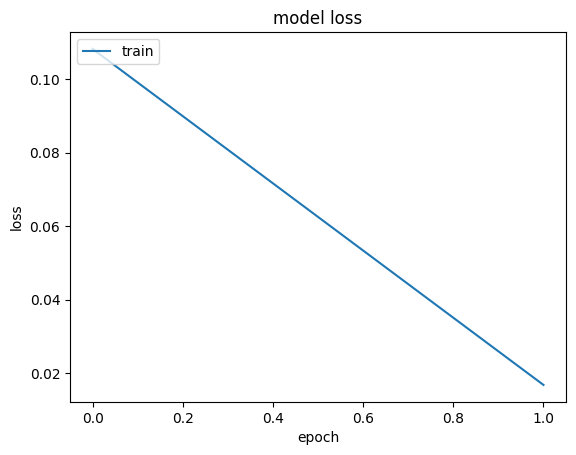

In [94]:
# Skip the first 10 epochs (index 0 to 9) and start plotting from the 11th epoch (index 10)
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# Adjusted the legend to include both 'train' and 'val' for clarity
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [95]:
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(test_data),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
valid_preds = bert_model.predict(inputs_valid)
valid_preds = np.argmax(valid_preds, axis=1)

97/97 [==============================] - 41s 388ms/step


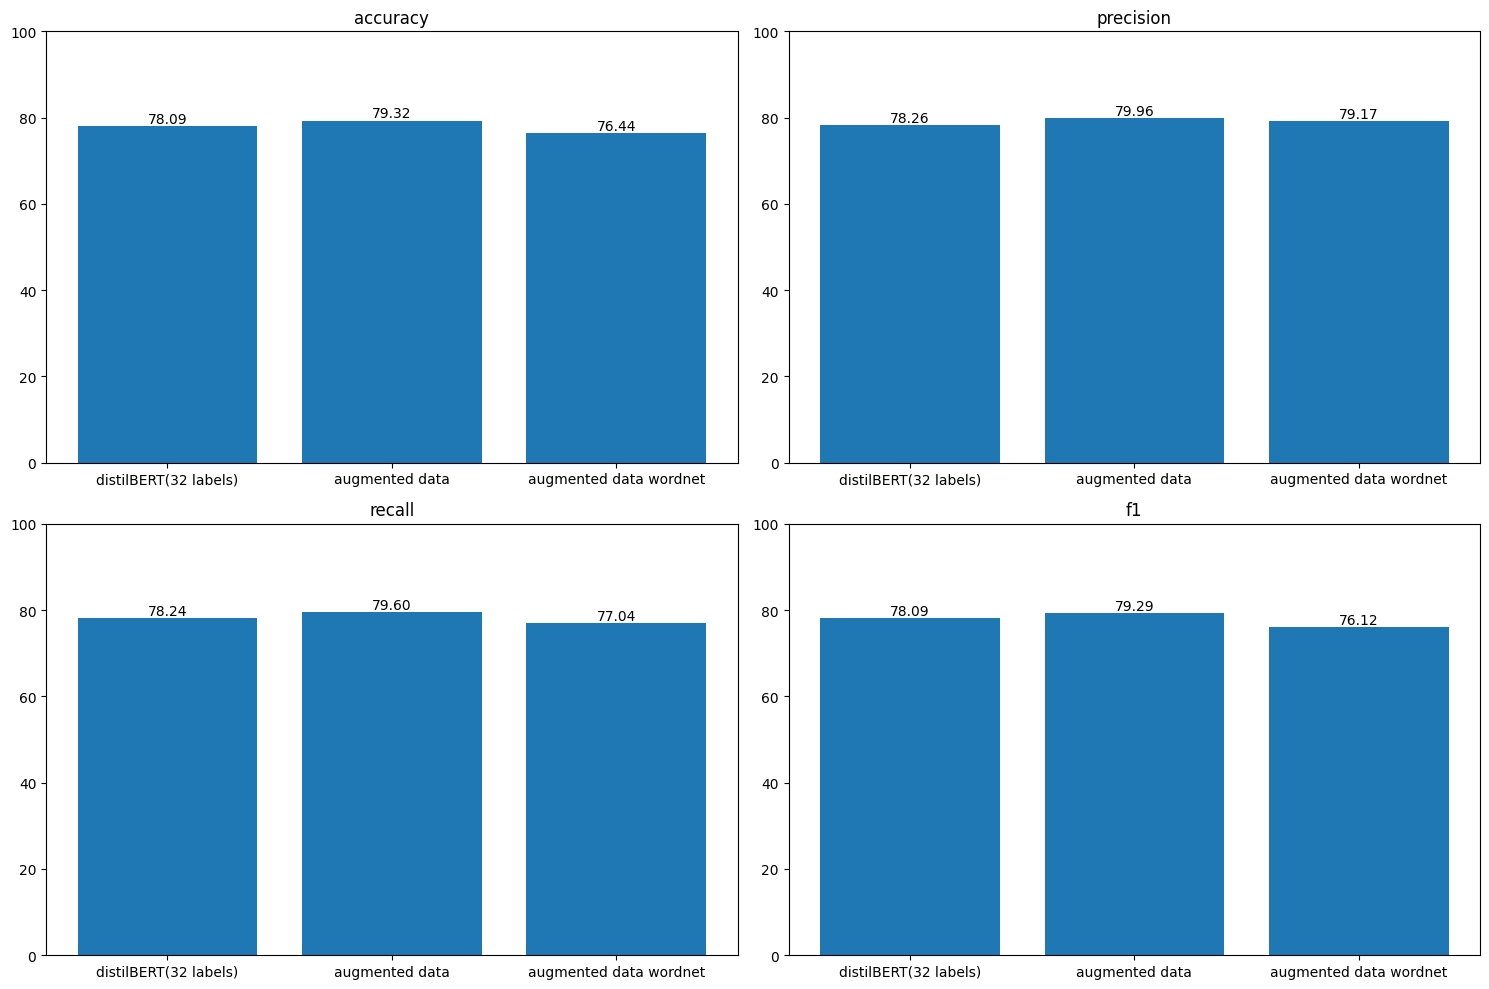

In [96]:
# get the final metrics
metrics_val.run(test_labels, valid_preds, "augmented data wordnet")
metrics_val.plot()
tf.keras.backend.clear_session()

---

# c. Zero-Shot Learning with LLM
#### For the Zero-Shot setup we found different LLM models from Huggingface which we tried to see which one gave us the best accuracy testing them with the validation data. Finally it was "facebook/bart-large-mnli" the one it gave us the best results

In [97]:
from transformers import pipeline

model_name = "facebook/bart-large-mnli"  # Adjust model name as needed

df_val_sampled = df_val.sample(n=299, random_state=42)
sampled_list1 = (df_val_sampled['text']).tolist()

# Load zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model=model_name)

# Define the candidate labels
candidate_labels = ['positive', 'negative']

# Store the predictions for each item in a list
predictions = []

# Iterate over each text sample in test_data
for text_sample in sampled_list1:
    # Use the classifier pipeline to predict the label
    result = classifier(text_sample, candidate_labels)

    # Get the label with the highest score
    if result['scores'][0] >= result['scores'][1]:
        predicted_label = result['labels'][0]
    else:
        predicted_label = result['labels'][1]

    # Append the predicted label to the predictions list
    predictions.append(predicted_label)

# Print the predictions
print(predictions)

['positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'ne

In [98]:
zero_predictions = [1 if prediction == 'positive' else 0 for prediction in predictions]

# Update the "label" column with values from sampled_list2
df_val_sampled['label'] = zero_predictions

# Display the updated DataFrame
print(df_val_sampled.head())

                                                   text  label  text_length  \
1116      @avaAmyV182 Glad you found us-- stick around!      1            7   
1395  just got home from shooting with jennhoffman. ...      0           21   
422   sand from my bag on my redbull can  ergh i don...      0           16   
413   @elbiddulph Ouch!  You may be my mom, but even...      0           23   
451           sickkkk from the pump party last night  !      0            8   

                                             clean_text clean_emotions  \
1116               glad you found us - - stick around !                  
1395  just got home from shooting with jennhoffman ....                  
422   sand from my bag on my redbull can ergh i dont...                  
413   ouch ! you may be my mom , but even i know tha...                  
451               sick from the pump party last night !                  

     hashtag                                       text_emotion  
1116          

#### Now we train our Roberta model once again adding the data obtained with Zero-Shot to the 32 labeled

In [99]:
# Add new_rows to df_train_32
augmented_zero_df = pd.concat([df_train_32, df_val_sampled], ignore_index=True)

# Display the augmented DataFrame
print(augmented_zero_df.shape)

(331, 7)


In [100]:
augmented_zero_df_data = augmented_zero_df['clean_text']
augmented_zero_df_label = augmented_zero_df['label']

In [101]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(augmented_zero_df_label).reshape(-1, 1)).toarray()

In [102]:
X_train = np.array(augmented_zero_df_data)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# Wrap the batches generator with tqdm
batches_with_progress = tqdm_generator(batches, steps_per_epoch)

bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# Now, pass the wrapped generator to fit
bert_model.fit(batches_with_progress, epochs=2, steps_per_epoch=steps_per_epoch)




Epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 1/2





Epoch:   2%|▏         | 1/41 [00:31<20:46, 31.15s/it]

 1/41 [..............................] - ETA: 21:15 - loss: 2.2912 - recall: 0.6250 - precision: 0.6250




Epoch:   7%|▋         | 3/41 [00:32<05:19,  8.40s/it]

 2/41 [>.............................] - ETA: 29s - loss: 2.3420 - recall: 0.6875 - precision: 0.6875  




Epoch:  10%|▉         | 4/41 [00:32<03:32,  5.75s/it]

 3/41 [=>............................] - ETA: 28s - loss: 2.0305 - recall: 0.7083 - precision: 0.7083




Epoch:  12%|█▏        | 5/41 [00:33<02:27,  4.09s/it]

 4/41 [=>............................] - ETA: 28s - loss: 1.6164 - recall: 0.7188 - precision: 0.7188




Epoch:  15%|█▍        | 6/41 [00:34<01:46,  3.03s/it]

 5/41 [==>...........................] - ETA: 27s - loss: 1.4798 - recall: 0.7500 - precision: 0.7500




Epoch:  17%|█▋        | 7/41 [00:35<01:18,  2.32s/it]

 6/41 [===>..........................] - ETA: 26s - loss: 1.2889 - recall: 0.7500 - precision: 0.7500




Epoch:  20%|█▉        | 8/41 [00:35<01:00,  1.84s/it]

 7/41 [====>.........................] - ETA: 25s - loss: 1.1496 - recall: 0.7679 - precision: 0.7679




Epoch:  22%|██▏       | 9/41 [00:36<00:48,  1.50s/it]

 8/41 [====>.........................] - ETA: 24s - loss: 1.0356 - recall: 0.7969 - precision: 0.7969




Epoch:  24%|██▍       | 10/41 [00:37<00:39,  1.27s/it]

 9/41 [=====>........................] - ETA: 24s - loss: 0.9379 - recall: 0.8056 - precision: 0.8056




Epoch:  27%|██▋       | 11/41 [00:38<00:33,  1.12s/it]

10/41 [======>.......................] - ETA: 23s - loss: 0.8522 - recall: 0.8250 - precision: 0.8250




Epoch:  29%|██▉       | 12/41 [00:38<00:30,  1.04s/it]

11/41 [=======>......................] - ETA: 23s - loss: 0.8174 - recall: 0.8182 - precision: 0.8182




Epoch:  32%|███▏      | 13/41 [00:39<00:26,  1.04it/s]

12/41 [=======>......................] - ETA: 22s - loss: 0.8130 - recall: 0.8125 - precision: 0.8125




Epoch:  34%|███▍      | 14/41 [00:40<00:24,  1.10it/s]

13/41 [========>.....................] - ETA: 21s - loss: 0.7850 - recall: 0.8173 - precision: 0.8173




Epoch:  37%|███▋      | 15/41 [00:41<00:22,  1.14it/s]

14/41 [=========>....................] - ETA: 20s - loss: 0.7395 - recall: 0.8304 - precision: 0.8304




Epoch:  39%|███▉      | 16/41 [00:42<00:21,  1.17it/s]

15/41 [=========>....................] - ETA: 20s - loss: 0.7153 - recall: 0.8250 - precision: 0.8250




Epoch:  41%|████▏     | 17/41 [00:42<00:19,  1.21it/s]

16/41 [==========>...................] - ETA: 19s - loss: 0.6837 - recall: 0.8281 - precision: 0.8281




Epoch:  44%|████▍     | 18/41 [00:43<00:18,  1.22it/s]

17/41 [===========>..................] - ETA: 18s - loss: 0.6671 - recall: 0.8309 - precision: 0.8309




Epoch:  46%|████▋     | 19/41 [00:44<00:17,  1.25it/s]

18/41 [============>.................] - ETA: 17s - loss: 0.6357 - recall: 0.8403 - precision: 0.8403




Epoch:  49%|████▉     | 20/41 [00:45<00:16,  1.25it/s]

19/41 [============>.................] - ETA: 17s - loss: 0.6505 - recall: 0.8224 - precision: 0.8224




Epoch:  51%|█████     | 21/41 [00:45<00:15,  1.27it/s]

20/41 [=============>................] - ETA: 16s - loss: 0.6358 - recall: 0.8250 - precision: 0.8250




Epoch:  54%|█████▎    | 22/41 [00:46<00:14,  1.28it/s]

21/41 [==============>...............] - ETA: 15s - loss: 0.6848 - recall: 0.8155 - precision: 0.8155




Epoch:  56%|█████▌    | 23/41 [00:47<00:13,  1.30it/s]

22/41 [===============>..............] - ETA: 14s - loss: 0.6784 - recall: 0.8125 - precision: 0.8125




Epoch:  59%|█████▊    | 24/41 [00:48<00:13,  1.28it/s]

23/41 [===============>..............] - ETA: 13s - loss: 0.6849 - recall: 0.7989 - precision: 0.7989




Epoch:  61%|██████    | 25/41 [00:49<00:12,  1.28it/s]

24/41 [================>.............] - ETA: 13s - loss: 0.6610 - recall: 0.8073 - precision: 0.8073




Epoch:  63%|██████▎   | 26/41 [00:49<00:11,  1.27it/s]

25/41 [=================>............] - ETA: 12s - loss: 0.6531 - recall: 0.8100 - precision: 0.8100




Epoch:  66%|██████▌   | 27/41 [00:50<00:10,  1.29it/s]

26/41 [==================>...........] - ETA: 11s - loss: 0.6537 - recall: 0.8077 - precision: 0.8077




Epoch:  68%|██████▊   | 28/41 [00:51<00:09,  1.32it/s]

27/41 [==================>...........] - ETA: 10s - loss: 0.6597 - recall: 0.7917 - precision: 0.7917




Epoch:  71%|███████   | 29/41 [00:52<00:09,  1.31it/s]

28/41 [===================>..........] - ETA: 10s - loss: 0.6777 - recall: 0.7812 - precision: 0.7812




Epoch:  73%|███████▎  | 30/41 [00:52<00:08,  1.30it/s]

29/41 [====================>.........] - ETA: 9s - loss: 0.6799 - recall: 0.7759 - precision: 0.7759 




Epoch:  76%|███████▌  | 31/41 [00:53<00:07,  1.29it/s]

30/41 [====================>.........] - ETA: 8s - loss: 0.6680 - recall: 0.7792 - precision: 0.7792




Epoch:  78%|███████▊  | 32/41 [00:54<00:06,  1.29it/s]

31/41 [=====================>........] - ETA: 7s - loss: 0.6575 - recall: 0.7863 - precision: 0.7863




Epoch:  80%|████████  | 33/41 [00:55<00:06,  1.32it/s]

32/41 [======================>.......] - ETA: 6s - loss: 0.6441 - recall: 0.7930 - precision: 0.7930




Epoch:  83%|████████▎ | 34/41 [00:55<00:05,  1.31it/s]

33/41 [=======================>......] - ETA: 6s - loss: 0.6440 - recall: 0.7917 - precision: 0.7917




Epoch:  85%|████████▌ | 35/41 [00:56<00:04,  1.32it/s]

34/41 [=======================>......] - ETA: 5s - loss: 0.6318 - recall: 0.7941 - precision: 0.7941




Epoch:  88%|████████▊ | 36/41 [00:57<00:03,  1.33it/s]

35/41 [========================>.....] - ETA: 4s - loss: 0.6216 - recall: 0.7964 - precision: 0.7964




Epoch:  90%|█████████ | 37/41 [00:58<00:02,  1.34it/s]

36/41 [=========================>....] - ETA: 3s - loss: 0.6133 - recall: 0.7986 - precision: 0.7986




Epoch:  93%|█████████▎| 38/41 [00:58<00:02,  1.33it/s]

37/41 [==========================>...] - ETA: 3s - loss: 0.6131 - recall: 0.7939 - precision: 0.7939




Epoch:  95%|█████████▌| 39/41 [00:59<00:01,  1.31it/s]

38/41 [==========================>...] - ETA: 2s - loss: 0.6051 - recall: 0.7961 - precision: 0.7961




Epoch:  98%|█████████▊| 40/41 [01:00<00:00,  1.32it/s]

39/41 [===========================>..] - ETA: 1s - loss: 0.5953 - recall: 0.8013 - precision: 0.8013




Epoch: 100%|██████████| 41/41 [01:01<00:00,  1.31it/s]

40/41 [============================>.] - ETA: 0s - loss: 0.5926 - recall: 0.8000 - precision: 0.8000




Epoch: 42it [01:01,  1.34it/s]                        

41/41 [==============================] - 63s 768ms/step - loss: 0.5894 - recall: 0.8018 - precision: 0.8018
Epoch 2/2





Epoch: 43it [01:02,  1.32it/s]

 1/41 [..............................] - ETA: 22s - loss: 0.3759 - recall: 0.6667 - precision: 0.6667




Epoch: 44it [01:03,  1.42it/s]

 2/41 [>.............................] - ETA: 29s - loss: 0.5352 - recall: 0.7273 - precision: 0.7273




Epoch: 45it [01:04,  1.38it/s]

 3/41 [=>............................] - ETA: 29s - loss: 0.3710 - recall: 0.8421 - precision: 0.8421




Epoch: 46it [01:04,  1.34it/s]

 4/41 [=>............................] - ETA: 28s - loss: 0.2970 - recall: 0.8889 - precision: 0.8889




Epoch: 47it [01:05,  1.34it/s]

 5/41 [==>...........................] - ETA: 27s - loss: 0.2917 - recall: 0.8857 - precision: 0.8857




Epoch: 48it [01:06,  1.33it/s]

 6/41 [===>..........................] - ETA: 26s - loss: 0.2809 - recall: 0.8837 - precision: 0.8837




Epoch: 49it [01:07,  1.33it/s]

 7/41 [====>.........................] - ETA: 25s - loss: 0.3181 - recall: 0.8627 - precision: 0.8627




Epoch: 50it [01:07,  1.33it/s]

 8/41 [====>.........................] - ETA: 25s - loss: 0.3026 - recall: 0.8644 - precision: 0.8644




Epoch: 51it [01:08,  1.33it/s]

 9/41 [=====>........................] - ETA: 24s - loss: 0.2877 - recall: 0.8806 - precision: 0.8806




Epoch: 52it [01:09,  1.33it/s]

10/41 [======>.......................] - ETA: 23s - loss: 0.3033 - recall: 0.8667 - precision: 0.8667




Epoch: 53it [01:10,  1.34it/s]

11/41 [=======>......................] - ETA: 22s - loss: 0.3235 - recall: 0.8554 - precision: 0.8554




Epoch: 54it [01:10,  1.36it/s]

12/41 [=======>......................] - ETA: 21s - loss: 0.3098 - recall: 0.8681 - precision: 0.8681




Epoch: 55it [01:11,  1.38it/s]

13/41 [========>.....................] - ETA: 20s - loss: 0.3028 - recall: 0.8586 - precision: 0.8586




Epoch: 56it [01:12,  1.37it/s]

14/41 [=========>....................] - ETA: 20s - loss: 0.2841 - recall: 0.8692 - precision: 0.8692




Epoch: 57it [01:13,  1.35it/s]

15/41 [=========>....................] - ETA: 19s - loss: 0.2689 - recall: 0.8783 - precision: 0.8783




Epoch: 58it [01:13,  1.36it/s]

16/41 [==========>...................] - ETA: 18s - loss: 0.2633 - recall: 0.8862 - precision: 0.8862




Epoch: 59it [01:14,  1.37it/s]

17/41 [===========>..................] - ETA: 17s - loss: 0.2646 - recall: 0.8779 - precision: 0.8779




Epoch: 60it [01:15,  1.36it/s]

18/41 [============>.................] - ETA: 17s - loss: 0.2509 - recall: 0.8849 - precision: 0.8849




Epoch: 61it [01:15,  1.35it/s]

19/41 [============>.................] - ETA: 16s - loss: 0.2547 - recall: 0.8844 - precision: 0.8844




Epoch: 62it [01:16,  1.35it/s]

20/41 [=============>................] - ETA: 15s - loss: 0.2488 - recall: 0.8903 - precision: 0.8903




Epoch: 63it [01:17,  1.35it/s]

21/41 [==============>...............] - ETA: 14s - loss: 0.2378 - recall: 0.8957 - precision: 0.8957




Epoch: 64it [01:18,  1.36it/s]

22/41 [===============>..............] - ETA: 14s - loss: 0.2424 - recall: 0.8947 - precision: 0.8947




Epoch: 65it [01:18,  1.33it/s]

23/41 [===============>..............] - ETA: 13s - loss: 0.2353 - recall: 0.8994 - precision: 0.8994




Epoch: 66it [01:19,  1.33it/s]

24/41 [================>.............] - ETA: 12s - loss: 0.2303 - recall: 0.9037 - precision: 0.9037




Epoch: 67it [01:20,  1.33it/s]

25/41 [=================>............] - ETA: 11s - loss: 0.2318 - recall: 0.9026 - precision: 0.9026




Epoch: 68it [01:21,  1.31it/s]

26/41 [==================>...........] - ETA: 11s - loss: 0.2270 - recall: 0.9064 - precision: 0.9064




Epoch: 69it [01:22,  1.29it/s]

27/41 [==================>...........] - ETA: 10s - loss: 0.2206 - recall: 0.9100 - precision: 0.9100




Epoch: 70it [01:22,  1.30it/s]

28/41 [===================>..........] - ETA: 9s - loss: 0.2197 - recall: 0.9087 - precision: 0.9087 




Epoch: 71it [01:23,  1.30it/s]

29/41 [====================>.........] - ETA: 9s - loss: 0.2345 - recall: 0.9031 - precision: 0.9031




Epoch: 72it [01:24,  1.31it/s]

30/41 [====================>.........] - ETA: 8s - loss: 0.2297 - recall: 0.9064 - precision: 0.9064




Epoch: 73it [01:25,  1.31it/s]

31/41 [=====================>........] - ETA: 7s - loss: 0.2255 - recall: 0.9053 - precision: 0.9053




Epoch: 74it [01:25,  1.32it/s]

32/41 [======================>.......] - ETA: 6s - loss: 0.2387 - recall: 0.9044 - precision: 0.9044




Epoch: 75it [01:26,  1.33it/s]

33/41 [=======================>......] - ETA: 6s - loss: 0.2330 - recall: 0.9073 - precision: 0.9073




Epoch: 76it [01:27,  1.33it/s]

34/41 [=======================>......] - ETA: 5s - loss: 0.2476 - recall: 0.9026 - precision: 0.9026




Epoch: 77it [01:28,  1.34it/s]

35/41 [========================>.....] - ETA: 4s - loss: 0.2639 - recall: 0.9018 - precision: 0.9018




Epoch: 78it [01:28,  1.32it/s]

36/41 [=========================>....] - ETA: 3s - loss: 0.2674 - recall: 0.9011 - precision: 0.9011




Epoch: 79it [01:29,  1.33it/s]

37/41 [==========================>...] - ETA: 3s - loss: 0.2601 - recall: 0.9038 - precision: 0.9038




Epoch: 80it [01:30,  1.34it/s]

38/41 [==========================>...] - ETA: 2s - loss: 0.2716 - recall: 0.8997 - precision: 0.8997




Epoch: 81it [01:31,  1.32it/s]

39/41 [===========================>..] - ETA: 1s - loss: 0.2670 - recall: 0.9023 - precision: 0.9023




Epoch: 82it [01:31,  1.32it/s]

40/41 [============================>.] - ETA: 0s - loss: 0.2605 - recall: 0.9048 - precision: 0.9048




Epoch: 83it [01:32,  1.32it/s]

41/41 [==============================] - 31s 752ms/step - loss: 0.2604 - recall: 0.9040 - precision: 0.9040


In [103]:
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(validation_data),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
valid_preds = bert_model.predict(inputs_valid)
valid_preds = np.argmax(valid_preds, axis=1)

47/47 [==============================] - 21s 386ms/step


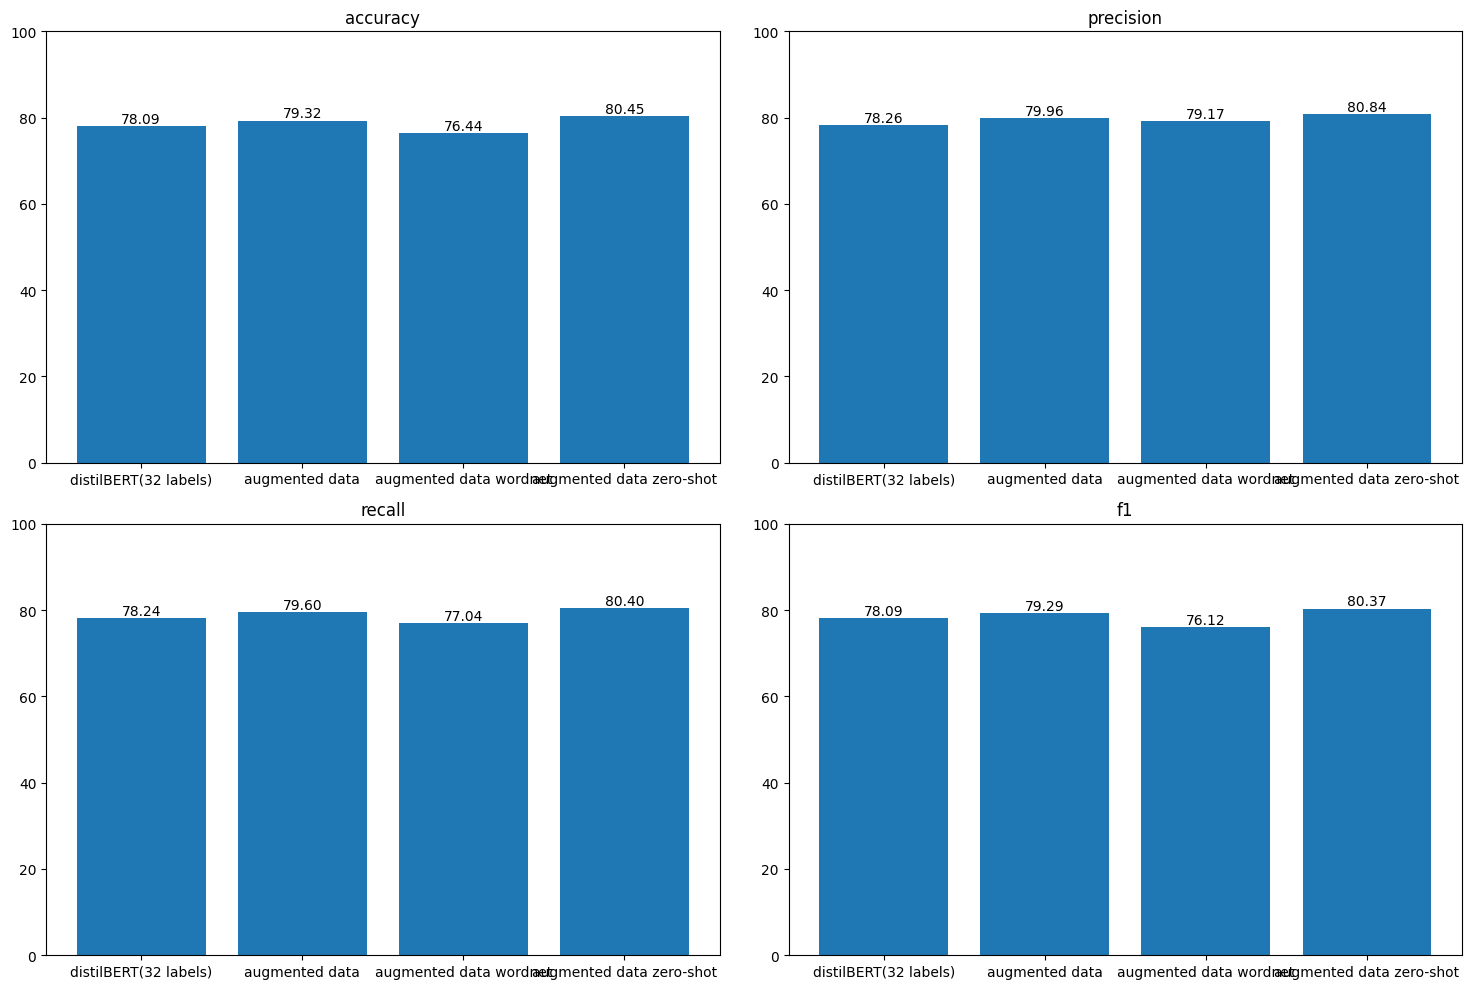

In [104]:
# get the final metrics
metrics_val.run(validation_labels, valid_preds, "augmented data zero-shot")
metrics_val.plot()
tf.keras.backend.clear_session()

#### We get a very big increase in the performance of our model, probably because of the size of the data, since we were training our model with only 32 samples and now we are adding 300 more samples, even though they are not 100% accurate, is still gives a lot more information for the model to work better

---

# d. Data Generation with LLM

In [105]:
# Output path to keep the generated answers:
path_output = []

prompts = []

initial_prompt = """
Title: Twitter Sentiment Analysis Data Generation

Description: In this project, the goal is to classify the sentiment of tweets as either positive (1) or negative (0).
We have a dataset called TSATC (Twitter Sentiment Analysis Training Corpus). Each tweet is labeled with either a 1 for positive sentiment or a 0 for negative sentiment.

Task: We aim to enhance our dataset by generating new labeled data points using a Large Language Model (LLM).
By leveraging the capabilities of LLMs, we seek to create additional labeled examples to improve the performance of our sentiment analysis model.

Prompt:
Given the context provided above, you will be asked to generate new tweets with sentiment labels (1 for positive sentiment, 0 for negative sentiment).
You can use the existing tweets as inspiration to generate new ones, ensuring that the generated tweets reflect similar sentiment patterns.
The generated tweets should maintain relevance to real-world Twitter content and adhere to the sentiment labeling scheme.

Additional Instructions:
- Ensure that the generated tweets are coherent, grammatically correct, and resemble natural Twitter language.
- Aim for diversity in the generated tweets to cover a wide range of sentiment expressions.
- Pay attention to the sentiment labels assigned to each generated tweet, maintaining consistency with the labeling scheme.

Data Format:
- Each generated tweet should be accompanied by its corresponding sentiment label (1 for positive, 0 for negative) and the context.
- Output format: Tweet_: [Tweet text] Sentiment_: [1 or 0] Context_: [context]

Example Output:
Tweet_: "Just finished watching the latest episode of my favorite TV show! Absolutely loved it!" Sentiment_: 1 Context_: "Normal"
Tweet_: "Stuck in traffic again! This commute is unbearable." Sentiment_: 0 Context_: "Normal"

The next ("PROMPT") will follow this structure:
"Please generate {{number}} {{sentiment}} tweets with the following context {{context}}. Return your answers in the following format:
Tweet_: [Tweet text] Sentiment_: [1 or 0] Context_: [context]"

Where Number is equal to the number of tweets to generate, Sentiment will be positive or negative.
And Context will be one of the following options [Normal, Sarcasm, Irony] where you adapt the generated tweets to the given context.
"""

following_prompts = """
Please generate {{number}} {{sentiment}} tweets with the following context {{context}}. Only return your answers in the following format:
Tweet_: [Tweet text] Sentiment_: [1 or 0] Context_: [context]
"""

following_prompts = Template(following_prompts)
sentiment_list = ["positive","negative"]
context_list = ['Normal','Normal','Sarcasm','Irony'] # Two times 'Normal' to have more of these

In [106]:
print(initial_prompt)


Title: Twitter Sentiment Analysis Data Generation

Description: In this project, the goal is to classify the sentiment of tweets as either positive (1) or negative (0).
We have a dataset called TSATC (Twitter Sentiment Analysis Training Corpus). Each tweet is labeled with either a 1 for positive sentiment or a 0 for negative sentiment.

Task: We aim to enhance our dataset by generating new labeled data points using a Large Language Model (LLM).
By leveraging the capabilities of LLMs, we seek to create additional labeled examples to improve the performance of our sentiment analysis model.

Prompt:
Given the context provided above, you will be asked to generate new tweets with sentiment labels (1 for positive sentiment, 0 for negative sentiment).
You can use the existing tweets as inspiration to generate new ones, ensuring that the generated tweets reflect similar sentiment patterns.
The generated tweets should maintain relevance to real-world Twitter content and adhere to the sentiment

In [107]:
print(following_prompts.render(number=50, sentiment="positive", context="Normal"))


Please generate 50 positive tweets with the following context Normal. Only return your answers in the following format:
Tweet_: [Tweet text] Sentiment_: [1 or 0] Context_: [context]


In [108]:
#client = OpenAI(api_key=tatiana_key)

In [109]:
# As only 50 tweets are asked in each prompt, we multiply the number of demands by 3.
all_prompts = [initial_prompt] + 3*[following_prompts.render(number=50,sentiment="negative", context=con) for con in context_list] + 3*[following_prompts.render(number=50,sentiment="positive", context=con) for con in context_list]
all_prompts = [[{"role": "system", "content": prompt}] for prompt in all_prompts]

In [110]:
"""gpt_tweets = [client.chat.completions.create(messages=msg, model='gpt-3.5-turbo').choices[0].message.content for msg in tqdm(all_prompts)]"""

"gpt_tweets = [client.chat.completions.create(messages=msg, model='gpt-3.5-turbo').choices[0].message.content for msg in tqdm(all_prompts)]"

In [111]:
"""print(len(gpt_tweets))
gpt_tweets[1]"""

'print(len(gpt_tweets))\ngpt_tweets[1]'

Save the generated tweets in a csv file to reduce the number of GPT requests made.

In [112]:
"""
# Initialize an empty DataFrame
df = pd.DataFrame(columns=['Tweet', 'Sentiment', 'Context'])

# Iterate through each element in gpt_tweets starting from index 1
for tweet_info_set in gpt_tweets[1:]:
    # Split the element by newline character to separate the lines
    tweet_info_lines = tweet_info_set.split('\n')

    # Initialize variables to store tweet, sentiment, and context
    tweet = []
    sentiment = []
    context = []

    # Iterate through each line in the tweet_info_lines
    for twt in tweet_info_lines:
        # Extract tweet, sentiment, and context from each line
        if "Tweet_:" in twt or "Tweet:" in twt:
          tweet_ = twt.split("Tweet_:")[1] if "Tweet_:" in twt else twt.split("Tweet:")[1]
          tweet_ = tweet_.split("Sentiment:")[0] if "Sentiment:" in tweet_ else tweet_.split("Sentiment_:")[0]
          tweet.append(tweet_)

        if "Sentiment_:" in twt or "Sentiment:" in twt:
          sentiment_ = twt.split("Sentiment_:")[1].split() if "Sentiment_:" in twt else twt.split("Sentiment:")[1]
          sentiment_ = sentiment_[0] if sentiment_[0] in ["1","0"] else sentiment_[1]
          sentiment.append(sentiment_)

        if "Context_:" in twt or "Context:" in twt:
          context_ = twt.split("Context_:")[1] if "Context_:" in twt else twt.split("Context:")[1]
          context.append(context_)

    # Check they all have the same length
    if len(tweet) == len(sentiment) == len(context):
        # Create a DataFrame from the extracted tweet, sentiment, and context
        df = pd.concat([df, pd.DataFrame({'Tweet': tweet, 'Sentiment': sentiment, 'Context': context})], ignore_index=True)
    else:
      print("An error has occured the data is not correct!")

# Display the DataFrame
df.head()
"""

'\n# Initialize an empty DataFrame\ndf = pd.DataFrame(columns=[\'Tweet\', \'Sentiment\', \'Context\'])\n\n# Iterate through each element in gpt_tweets starting from index 1\nfor tweet_info_set in gpt_tweets[1:]:\n    # Split the element by newline character to separate the lines\n    tweet_info_lines = tweet_info_set.split(\'\n\')\n\n    # Initialize variables to store tweet, sentiment, and context\n    tweet = []\n    sentiment = []\n    context = []\n\n    # Iterate through each line in the tweet_info_lines\n    for twt in tweet_info_lines:\n        # Extract tweet, sentiment, and context from each line\n        if "Tweet_:" in twt or "Tweet:" in twt:\n          tweet_ = twt.split("Tweet_:")[1] if "Tweet_:" in twt else twt.split("Tweet:")[1]\n          tweet_ = tweet_.split("Sentiment:")[0] if "Sentiment:" in tweet_ else tweet_.split("Sentiment_:")[0]\n          tweet.append(tweet_)\n\n        if "Sentiment_:" in twt or "Sentiment:" in twt:\n          sentiment_ = twt.split("Sentimen

In [113]:
"""# Save the tweets into a csv format:
from google.colab import drive
drive.mount('/content/drive')

# To reduce the number of requestes made to GPT we will save the generated tweets and skip the generating process for the future useages.
df.to_csv('/content/drive/My Drive/gpt_tweets.csv', index=False)"""

"# Save the tweets into a csv format:\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n# To reduce the number of requestes made to GPT we will save the generated tweets and skip the generating process for the future useages.\ndf.to_csv('/content/drive/My Drive/gpt_tweets.csv', index=False)"

In [114]:
# Load csv file containing the generated tweets
df = pd.read_csv("/content/gpt_tweets.csv")

df['Context'] = df['Context'].str.strip()

df.rename(columns={'Tweet': 'text', 'Sentiment': 'label'}, inplace=True)

In [115]:
# Inspect Data
print(df.shape)
df.isna().sum()

(1135, 3)


text       0
label      0
Context    0
dtype: int64

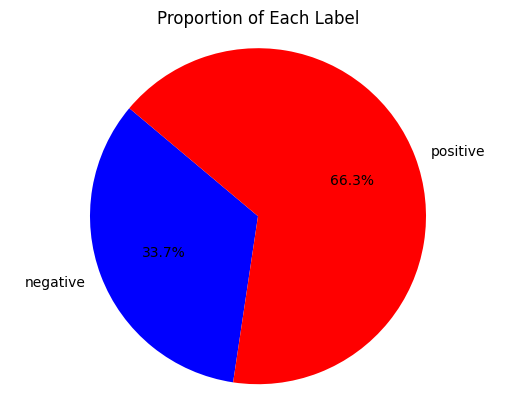

In [116]:
# Check Positive vs Negative Ratio:
label_counts = Counter(df['label'])
labels = {0: 'negative', 1: 'positive'}

# Data to plot
_labels = [labels.get(lab) for lab in label_counts.keys()]
sizes = label_counts.values()
colors = ['blue', 'red']

# Plotting the pie chart
plt.pie(sizes, labels=_labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Proportion of Each Label')
plt.show()

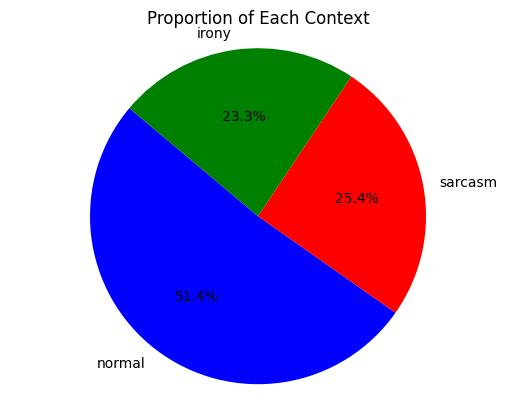

In [117]:
# Check Context Ratio:
label_counts = Counter(df['Context'])
labels = {'Normal': 'normal', 'Sarcasm': 'sarcasm', 'Irony':'irony'}

# Data to plot
_labels = [labels.get(lab) for lab in label_counts.keys()]
sizes = label_counts.values()
colors = ['blue', 'red', 'green']

# Plotting the pie chart
plt.pie(sizes, labels=_labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Proportion of Each Context')
plt.show()

In [118]:
# 5 examples of each tweet category possible, (positive vs negative), (Normal, Irony, Sarcasm)
unique_contexts = df['Context'].unique()

# Iterate over each unique context
for context in unique_contexts:
    print(f"Context: {context}")
    # Filter the DataFrame for the current context
    context_df = df[df['Context'] == context]
    # Filter positive tweets
    positive_tweets = context_df[context_df['label'] == 1]['text'].head(5)
    print("Positive Tweets:")
    for tweet in positive_tweets:
        print(tweet)
    # Filter negative tweets
    negative_tweets = context_df[context_df['label'] == 0]['text'].head(5)
    print("Negative Tweets:")
    for tweet in negative_tweets:
        print(tweet)
    print()

Context: Normal
Positive Tweets:
 Love starting my day with a cup of coffee and some good music! 
 Grateful for the sunny weather today, it's such a mood booster! 
 Just finished a great workout and feeling energized for the day ahead. 
 Spending time with loved ones always puts a smile on my face. 
 Excited to dive into a new book I've been waiting to read! 
Negative Tweets:
 Normal is overrated. 
 Can't stand being average, but that's what normal is all about. 
 Normal is just code for boring. 
 The idea of being normal makes me cringe. 
 Trying to fit in with the norm is exhausting. 

Context: Sarcasm
Positive Tweets:
 I just love when people take up two parking spots. So considerate. 
 I always look forward to getting stuck in traffic. It's the highlight of my day. 
 Ah, nothing like waking up to a pile of dirty dishes in the sink. Pure bliss. 
 Can't get enough of spam emails. They really brighten up my inbox. 
 Oh, I absolutely adore it when my phone dies right in the middle of a

In [119]:
df['text_length'] = 0
df = clean_text(df)

train_data_generated = df["text"]
train_labels_generated = df["label"]

In [120]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(train_labels_generated).reshape(-1, 1)).toarray()

In [121]:
X_train = np.array(train_data_generated)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# Wrap the batches generator with tqdm
batches_with_progress = tqdm_generator(batches, steps_per_epoch)

bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# Now, pass the wrapped generator to fit
bert_model.fit(batches_with_progress, epochs=2, steps_per_epoch=steps_per_epoch)





Epoch:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 1/2






Epoch:   1%|          | 1/141 [00:33<1:17:06, 33.04s/it]

  1/141 [..............................] - ETA: 1:18:20 - loss: 0.1395 - recall: 0.8750 - precision: 0.8750





Epoch:   2%|▏         | 3/141 [00:33<20:19,  8.84s/it]  

  2/141 [..............................] - ETA: 1:48 - loss: 0.1811 - recall: 0.8125 - precision: 0.8125   





Epoch:   3%|▎         | 4/141 [00:34<13:48,  6.05s/it]

  3/141 [..............................] - ETA: 1:45 - loss: 0.2183 - recall: 0.8333 - precision: 0.8333





Epoch:   4%|▎         | 5/141 [00:35<09:44,  4.30s/it]

  4/141 [..............................] - ETA: 1:45 - loss: 0.3088 - recall: 0.8438 - precision: 0.8438





Epoch:   4%|▍         | 6/141 [00:36<07:07,  3.17s/it]

  5/141 [>.............................] - ETA: 1:43 - loss: 0.2908 - recall: 0.8500 - precision: 0.8500





Epoch:   5%|▍         | 7/141 [00:36<05:21,  2.40s/it]

  6/141 [>.............................] - ETA: 1:42 - loss: 0.2792 - recall: 0.8542 - precision: 0.8542





Epoch:   6%|▌         | 8/141 [00:37<04:12,  1.90s/it]

  7/141 [>.............................] - ETA: 1:41 - loss: 0.2698 - recall: 0.8571 - precision: 0.8571





Epoch:   6%|▋         | 9/141 [00:38<03:23,  1.54s/it]

  8/141 [>.............................] - ETA: 1:40 - loss: 0.3088 - recall: 0.8281 - precision: 0.8281





Epoch:   7%|▋         | 10/141 [00:39<02:50,  1.30s/it]

  9/141 [>.............................] - ETA: 1:40 - loss: 0.3684 - recall: 0.8194 - precision: 0.8194





Epoch:   8%|▊         | 11/141 [00:39<02:28,  1.15s/it]

 10/141 [=>............................] - ETA: 1:40 - loss: 0.3397 - recall: 0.8375 - precision: 0.8375





Epoch:   9%|▊         | 12/141 [00:40<02:13,  1.03s/it]

 11/141 [=>............................] - ETA: 1:39 - loss: 0.3129 - recall: 0.8523 - precision: 0.8523





Epoch:   9%|▉         | 13/141 [00:41<02:01,  1.05it/s]

 12/141 [=>............................] - ETA: 1:38 - loss: 0.2912 - recall: 0.8646 - precision: 0.8646





Epoch:  10%|▉         | 14/141 [00:42<01:54,  1.11it/s]

 13/141 [=>............................] - ETA: 1:37 - loss: 0.3454 - recall: 0.8558 - precision: 0.8558





Epoch:  11%|█         | 15/141 [00:42<01:48,  1.16it/s]

 14/141 [=>............................] - ETA: 1:37 - loss: 0.3322 - recall: 0.8571 - precision: 0.8571





Epoch:  11%|█▏        | 16/141 [00:43<01:45,  1.19it/s]

 15/141 [==>...........................] - ETA: 1:36 - loss: 0.3277 - recall: 0.8583 - precision: 0.8583





Epoch:  12%|█▏        | 17/141 [00:44<01:42,  1.21it/s]

 16/141 [==>...........................] - ETA: 1:35 - loss: 0.3500 - recall: 0.8516 - precision: 0.8516





Epoch:  13%|█▎        | 18/141 [00:45<01:38,  1.25it/s]

 17/141 [==>...........................] - ETA: 1:34 - loss: 0.3655 - recall: 0.8456 - precision: 0.8456





Epoch:  13%|█▎        | 19/141 [00:46<01:35,  1.28it/s]

 18/141 [==>...........................] - ETA: 1:34 - loss: 0.3552 - recall: 0.8542 - precision: 0.8542





Epoch:  14%|█▍        | 20/141 [00:46<01:33,  1.29it/s]

 19/141 [===>..........................] - ETA: 1:33 - loss: 0.4095 - recall: 0.8421 - precision: 0.8421





Epoch:  15%|█▍        | 21/141 [00:47<01:30,  1.32it/s]

 20/141 [===>..........................] - ETA: 1:32 - loss: 0.4033 - recall: 0.8500 - precision: 0.8500





Epoch:  16%|█▌        | 22/141 [00:48<01:30,  1.31it/s]

 21/141 [===>..........................] - ETA: 1:31 - loss: 0.4023 - recall: 0.8452 - precision: 0.8452





Epoch:  16%|█▋        | 23/141 [00:49<01:30,  1.30it/s]

 22/141 [===>..........................] - ETA: 1:30 - loss: 0.4244 - recall: 0.8352 - precision: 0.8352





Epoch:  17%|█▋        | 24/141 [00:49<01:29,  1.31it/s]

 23/141 [===>..........................] - ETA: 1:30 - loss: 0.4199 - recall: 0.8370 - precision: 0.8370





Epoch:  18%|█▊        | 25/141 [00:50<01:28,  1.32it/s]

 24/141 [====>.........................] - ETA: 1:29 - loss: 0.4139 - recall: 0.8438 - precision: 0.8438





Epoch:  18%|█▊        | 26/141 [00:51<01:27,  1.32it/s]

 25/141 [====>.........................] - ETA: 1:28 - loss: 0.4184 - recall: 0.8400 - precision: 0.8400





Epoch:  19%|█▉        | 27/141 [00:52<01:27,  1.30it/s]

 26/141 [====>.........................] - ETA: 1:27 - loss: 0.4221 - recall: 0.8365 - precision: 0.8365





Epoch:  20%|█▉        | 28/141 [00:52<01:26,  1.31it/s]

 27/141 [====>.........................] - ETA: 1:27 - loss: 0.4311 - recall: 0.8287 - precision: 0.8287





Epoch:  21%|██        | 29/141 [00:53<01:25,  1.31it/s]

 28/141 [====>.........................] - ETA: 1:26 - loss: 0.4292 - recall: 0.8259 - precision: 0.8259





Epoch:  21%|██▏       | 30/141 [00:54<01:23,  1.32it/s]

 29/141 [=====>........................] - ETA: 1:25 - loss: 0.4199 - recall: 0.8319 - precision: 0.8319





Epoch:  22%|██▏       | 31/141 [00:55<01:23,  1.32it/s]

 30/141 [=====>........................] - ETA: 1:24 - loss: 0.4284 - recall: 0.8292 - precision: 0.8292





Epoch:  23%|██▎       | 32/141 [00:55<01:23,  1.31it/s]

 31/141 [=====>........................] - ETA: 1:23 - loss: 0.4198 - recall: 0.8347 - precision: 0.8347





Epoch:  23%|██▎       | 33/141 [00:56<01:22,  1.30it/s]

 32/141 [=====>........................] - ETA: 1:22 - loss: 0.4147 - recall: 0.8359 - precision: 0.8359





Epoch:  24%|██▍       | 34/141 [00:57<01:19,  1.34it/s]

 33/141 [======>.......................] - ETA: 1:22 - loss: 0.4201 - recall: 0.8258 - precision: 0.8258





Epoch:  25%|██▍       | 35/141 [00:58<01:18,  1.35it/s]

 34/141 [======>.......................] - ETA: 1:21 - loss: 0.4133 - recall: 0.8309 - precision: 0.8309





Epoch:  26%|██▌       | 36/141 [00:58<01:18,  1.34it/s]

 35/141 [======>.......................] - ETA: 1:20 - loss: 0.4187 - recall: 0.8286 - precision: 0.8286





Epoch:  26%|██▌       | 37/141 [00:59<01:18,  1.33it/s]

 36/141 [======>.......................] - ETA: 1:19 - loss: 0.4153 - recall: 0.8299 - precision: 0.8299





Epoch:  27%|██▋       | 38/141 [01:00<01:17,  1.33it/s]

 37/141 [======>.......................] - ETA: 1:19 - loss: 0.4139 - recall: 0.8311 - precision: 0.8311





Epoch:  28%|██▊       | 39/141 [01:01<01:16,  1.33it/s]

 38/141 [=======>......................] - ETA: 1:18 - loss: 0.4155 - recall: 0.8289 - precision: 0.8289





Epoch:  28%|██▊       | 40/141 [01:01<01:17,  1.30it/s]

 39/141 [=======>......................] - ETA: 1:17 - loss: 0.4082 - recall: 0.8333 - precision: 0.8333





Epoch:  29%|██▉       | 41/141 [01:02<01:18,  1.28it/s]

 40/141 [=======>......................] - ETA: 1:17 - loss: 0.4150 - recall: 0.8281 - precision: 0.8281





Epoch:  30%|██▉       | 42/141 [01:03<01:18,  1.26it/s]

 41/141 [=======>......................] - ETA: 1:16 - loss: 0.4116 - recall: 0.8293 - precision: 0.8293





Epoch:  30%|███       | 43/141 [01:04<01:17,  1.27it/s]

 42/141 [=======>......................] - ETA: 1:15 - loss: 0.4037 - recall: 0.8333 - precision: 0.8333





Epoch:  31%|███       | 44/141 [01:05<01:16,  1.27it/s]

 43/141 [========>.....................] - ETA: 1:14 - loss: 0.3961 - recall: 0.8372 - precision: 0.8372





Epoch:  32%|███▏      | 45/141 [01:05<01:15,  1.28it/s]

 44/141 [========>.....................] - ETA: 1:14 - loss: 0.3922 - recall: 0.8381 - precision: 0.8381





Epoch:  33%|███▎      | 46/141 [01:06<01:14,  1.28it/s]

 45/141 [========>.....................] - ETA: 1:13 - loss: 0.3957 - recall: 0.8389 - precision: 0.8389





Epoch:  33%|███▎      | 47/141 [01:07<01:13,  1.28it/s]

 46/141 [========>.....................] - ETA: 1:12 - loss: 0.3949 - recall: 0.8397 - precision: 0.8397





Epoch:  34%|███▍      | 48/141 [01:08<01:12,  1.28it/s]

 47/141 [=========>....................] - ETA: 1:12 - loss: 0.3910 - recall: 0.8431 - precision: 0.8431





Epoch:  35%|███▍      | 49/141 [01:09<01:11,  1.29it/s]

 48/141 [=========>....................] - ETA: 1:11 - loss: 0.3902 - recall: 0.8411 - precision: 0.8411





Epoch:  35%|███▌      | 50/141 [01:09<01:10,  1.29it/s]

 49/141 [=========>....................] - ETA: 1:10 - loss: 0.3846 - recall: 0.8444 - precision: 0.8444





Epoch:  36%|███▌      | 51/141 [01:10<01:09,  1.30it/s]

 50/141 [=========>....................] - ETA: 1:09 - loss: 0.3857 - recall: 0.8450 - precision: 0.8450





Epoch:  37%|███▋      | 52/141 [01:11<01:08,  1.30it/s]

 51/141 [=========>....................] - ETA: 1:09 - loss: 0.3950 - recall: 0.8431 - precision: 0.8431





Epoch:  38%|███▊      | 53/141 [01:12<01:09,  1.27it/s]

 52/141 [==========>...................] - ETA: 1:08 - loss: 0.3915 - recall: 0.8438 - precision: 0.8438





Epoch:  38%|███▊      | 54/141 [01:12<01:08,  1.27it/s]

 53/141 [==========>...................] - ETA: 1:07 - loss: 0.3869 - recall: 0.8467 - precision: 0.8467





Epoch:  39%|███▉      | 55/141 [01:13<01:08,  1.26it/s]

 54/141 [==========>...................] - ETA: 1:06 - loss: 0.3925 - recall: 0.8472 - precision: 0.8472





Epoch:  40%|███▉      | 56/141 [01:14<01:07,  1.25it/s]

 55/141 [==========>...................] - ETA: 1:06 - loss: 0.3919 - recall: 0.8477 - precision: 0.8477





Epoch:  40%|████      | 57/141 [01:15<01:06,  1.27it/s]

 56/141 [==========>...................] - ETA: 1:05 - loss: 0.4004 - recall: 0.8438 - precision: 0.8438





Epoch:  41%|████      | 58/141 [01:16<01:04,  1.29it/s]

 57/141 [===========>..................] - ETA: 1:04 - loss: 0.3991 - recall: 0.8421 - precision: 0.8421





Epoch:  42%|████▏     | 59/141 [01:16<01:03,  1.29it/s]

 58/141 [===========>..................] - ETA: 1:03 - loss: 0.4031 - recall: 0.8405 - precision: 0.8405





Epoch:  43%|████▎     | 60/141 [01:17<01:02,  1.29it/s]

 59/141 [===========>..................] - ETA: 1:03 - loss: 0.4078 - recall: 0.8411 - precision: 0.8411





Epoch:  43%|████▎     | 61/141 [01:18<01:01,  1.29it/s]

 60/141 [===========>..................] - ETA: 1:02 - loss: 0.4036 - recall: 0.8438 - precision: 0.8438





Epoch:  44%|████▍     | 62/141 [01:19<01:00,  1.31it/s]

 61/141 [===========>..................] - ETA: 1:01 - loss: 0.3990 - recall: 0.8463 - precision: 0.8463





Epoch:  45%|████▍     | 63/141 [01:19<00:59,  1.31it/s]

 62/141 [============>.................] - ETA: 1:00 - loss: 0.3976 - recall: 0.8448 - precision: 0.8448





Epoch:  45%|████▌     | 64/141 [01:20<00:58,  1.32it/s]

 63/141 [============>.................] - ETA: 59s - loss: 0.3937 - recall: 0.8472 - precision: 0.8472 





Epoch:  46%|████▌     | 65/141 [01:21<00:57,  1.32it/s]

 64/141 [============>.................] - ETA: 59s - loss: 0.3949 - recall: 0.8438 - precision: 0.8438





Epoch:  47%|████▋     | 66/141 [01:22<00:57,  1.30it/s]

 65/141 [============>.................] - ETA: 58s - loss: 0.3923 - recall: 0.8442 - precision: 0.8442





Epoch:  48%|████▊     | 67/141 [01:22<00:56,  1.31it/s]

 66/141 [=============>................] - ETA: 57s - loss: 0.3935 - recall: 0.8447 - precision: 0.8447





Epoch:  48%|████▊     | 68/141 [01:23<00:55,  1.31it/s]

 67/141 [=============>................] - ETA: 56s - loss: 0.3927 - recall: 0.8433 - precision: 0.8433





Epoch:  49%|████▉     | 69/141 [01:24<00:55,  1.30it/s]

 68/141 [=============>................] - ETA: 56s - loss: 0.3911 - recall: 0.8438 - precision: 0.8438





Epoch:  50%|████▉     | 70/141 [01:25<00:55,  1.29it/s]

 69/141 [=============>................] - ETA: 55s - loss: 0.3876 - recall: 0.8460 - precision: 0.8460





Epoch:  50%|█████     | 71/141 [01:26<00:54,  1.28it/s]

 70/141 [=============>................] - ETA: 54s - loss: 0.3907 - recall: 0.8446 - precision: 0.8446





Epoch:  51%|█████     | 72/141 [01:26<00:55,  1.25it/s]

 71/141 [==============>...............] - ETA: 53s - loss: 0.3895 - recall: 0.8451 - precision: 0.8451





Epoch:  52%|█████▏    | 73/141 [01:27<00:53,  1.28it/s]

 72/141 [==============>...............] - ETA: 53s - loss: 0.3861 - recall: 0.8472 - precision: 0.8472





Epoch:  52%|█████▏    | 74/141 [01:28<00:51,  1.30it/s]

 73/141 [==============>...............] - ETA: 52s - loss: 0.3857 - recall: 0.8476 - precision: 0.8476





Epoch:  53%|█████▎    | 75/141 [01:29<00:50,  1.32it/s]

 74/141 [==============>...............] - ETA: 51s - loss: 0.3836 - recall: 0.8480 - precision: 0.8480





Epoch:  54%|█████▍    | 76/141 [01:29<00:49,  1.31it/s]

 75/141 [==============>...............] - ETA: 50s - loss: 0.3818 - recall: 0.8483 - precision: 0.8483





Epoch:  55%|█████▍    | 77/141 [01:30<00:49,  1.30it/s]

 76/141 [===============>..............] - ETA: 50s - loss: 0.3825 - recall: 0.8487 - precision: 0.8487





Epoch:  55%|█████▌    | 78/141 [01:31<00:49,  1.28it/s]

 77/141 [===============>..............] - ETA: 49s - loss: 0.3855 - recall: 0.8474 - precision: 0.8474





Epoch:  56%|█████▌    | 79/141 [01:32<00:48,  1.28it/s]

 78/141 [===============>..............] - ETA: 48s - loss: 0.3819 - recall: 0.8494 - precision: 0.8494





Epoch:  57%|█████▋    | 80/141 [01:33<00:47,  1.29it/s]

 79/141 [===============>..............] - ETA: 47s - loss: 0.3805 - recall: 0.8497 - precision: 0.8497





Epoch:  57%|█████▋    | 81/141 [01:33<00:46,  1.29it/s]

 80/141 [================>.............] - ETA: 46s - loss: 0.3796 - recall: 0.8500 - precision: 0.8500





Epoch:  58%|█████▊    | 82/141 [01:34<00:45,  1.30it/s]

 81/141 [================>.............] - ETA: 46s - loss: 0.3793 - recall: 0.8488 - precision: 0.8488





Epoch:  59%|█████▉    | 83/141 [01:35<00:43,  1.32it/s]

 82/141 [================>.............] - ETA: 45s - loss: 0.3784 - recall: 0.8491 - precision: 0.8491





Epoch:  60%|█████▉    | 84/141 [01:36<00:43,  1.32it/s]

 83/141 [================>.............] - ETA: 44s - loss: 0.3800 - recall: 0.8479 - precision: 0.8479





Epoch:  60%|██████    | 85/141 [01:36<00:42,  1.33it/s]

 84/141 [================>.............] - ETA: 43s - loss: 0.3808 - recall: 0.8467 - precision: 0.8467





Epoch:  61%|██████    | 86/141 [01:37<00:41,  1.32it/s]

 85/141 [=================>............] - ETA: 43s - loss: 0.3788 - recall: 0.8471 - precision: 0.8471





Epoch:  62%|██████▏   | 87/141 [01:38<00:41,  1.30it/s]

 86/141 [=================>............] - ETA: 42s - loss: 0.3759 - recall: 0.8488 - precision: 0.8488





Epoch:  62%|██████▏   | 88/141 [01:39<00:40,  1.31it/s]

 87/141 [=================>............] - ETA: 41s - loss: 0.3723 - recall: 0.8506 - precision: 0.8506





Epoch:  63%|██████▎   | 89/141 [01:39<00:39,  1.30it/s]

 88/141 [=================>............] - ETA: 40s - loss: 0.3711 - recall: 0.8509 - precision: 0.8509





Epoch:  64%|██████▍   | 90/141 [01:40<00:38,  1.31it/s]

 89/141 [=================>............] - ETA: 39s - loss: 0.3694 - recall: 0.8511 - precision: 0.8511





Epoch:  65%|██████▍   | 91/141 [01:41<00:37,  1.33it/s]

 90/141 [==================>...........] - ETA: 39s - loss: 0.3720 - recall: 0.8500 - precision: 0.8500





Epoch:  65%|██████▌   | 92/141 [01:42<00:37,  1.31it/s]

 91/141 [==================>...........] - ETA: 38s - loss: 0.3707 - recall: 0.8503 - precision: 0.8503





Epoch:  66%|██████▌   | 93/141 [01:42<00:36,  1.31it/s]

 92/141 [==================>...........] - ETA: 37s - loss: 0.3691 - recall: 0.8505 - precision: 0.8505





Epoch:  67%|██████▋   | 94/141 [01:43<00:35,  1.32it/s]

 93/141 [==================>...........] - ETA: 36s - loss: 0.3698 - recall: 0.8508 - precision: 0.8508





Epoch:  67%|██████▋   | 95/141 [01:44<00:35,  1.31it/s]

 94/141 [===================>..........] - ETA: 36s - loss: 0.3675 - recall: 0.8524 - precision: 0.8524





Epoch:  68%|██████▊   | 96/141 [01:45<00:34,  1.29it/s]

 95/141 [===================>..........] - ETA: 35s - loss: 0.3720 - recall: 0.8513 - precision: 0.8513





Epoch:  69%|██████▉   | 97/141 [01:46<00:34,  1.29it/s]

 96/141 [===================>..........] - ETA: 34s - loss: 0.3686 - recall: 0.8529 - precision: 0.8529





Epoch:  70%|██████▉   | 98/141 [01:46<00:33,  1.30it/s]

 97/141 [===================>..........] - ETA: 33s - loss: 0.3658 - recall: 0.8544 - precision: 0.8544





Epoch:  70%|███████   | 99/141 [01:47<00:32,  1.30it/s]

 98/141 [===================>..........] - ETA: 33s - loss: 0.3629 - recall: 0.8559 - precision: 0.8559





Epoch:  71%|███████   | 100/141 [01:48<00:31,  1.29it/s]

 99/141 [====================>.........] - ETA: 32s - loss: 0.3609 - recall: 0.8561 - precision: 0.8561





Epoch:  72%|███████▏  | 101/141 [01:49<00:30,  1.31it/s]

100/141 [====================>.........] - ETA: 31s - loss: 0.3609 - recall: 0.8550 - precision: 0.8550





Epoch:  72%|███████▏  | 102/141 [01:49<00:29,  1.31it/s]

101/141 [====================>.........] - ETA: 30s - loss: 0.3587 - recall: 0.8564 - precision: 0.8564





Epoch:  73%|███████▎  | 103/141 [01:50<00:29,  1.29it/s]

102/141 [====================>.........] - ETA: 29s - loss: 0.3577 - recall: 0.8566 - precision: 0.8566





Epoch:  74%|███████▍  | 104/141 [01:51<00:28,  1.30it/s]

103/141 [====================>.........] - ETA: 29s - loss: 0.3544 - recall: 0.8580 - precision: 0.8580





Epoch:  74%|███████▍  | 105/141 [01:52<00:28,  1.28it/s]

104/141 [=====================>........] - ETA: 28s - loss: 0.3525 - recall: 0.8582 - precision: 0.8582





Epoch:  75%|███████▌  | 106/141 [01:52<00:27,  1.29it/s]

105/141 [=====================>........] - ETA: 27s - loss: 0.3514 - recall: 0.8583 - precision: 0.8583





Epoch:  76%|███████▌  | 107/141 [01:53<00:26,  1.30it/s]

106/141 [=====================>........] - ETA: 26s - loss: 0.3509 - recall: 0.8585 - precision: 0.8585





Epoch:  77%|███████▋  | 108/141 [01:54<00:25,  1.28it/s]

107/141 [=====================>........] - ETA: 26s - loss: 0.3478 - recall: 0.8598 - precision: 0.8598





Epoch:  77%|███████▋  | 109/141 [01:55<00:25,  1.27it/s]

108/141 [=====================>........] - ETA: 25s - loss: 0.3461 - recall: 0.8611 - precision: 0.8611





Epoch:  78%|███████▊  | 110/141 [01:56<00:24,  1.27it/s]

109/141 [======================>.......] - ETA: 24s - loss: 0.3455 - recall: 0.8612 - precision: 0.8612





Epoch:  79%|███████▊  | 111/141 [01:56<00:23,  1.27it/s]

110/141 [======================>.......] - ETA: 23s - loss: 0.3428 - recall: 0.8625 - precision: 0.8625





Epoch:  79%|███████▉  | 112/141 [01:57<00:22,  1.26it/s]

111/141 [======================>.......] - ETA: 23s - loss: 0.3480 - recall: 0.8615 - precision: 0.8615





Epoch:  80%|████████  | 113/141 [01:58<00:22,  1.27it/s]

112/141 [======================>.......] - ETA: 22s - loss: 0.3469 - recall: 0.8616 - precision: 0.8616





Epoch:  81%|████████  | 114/141 [01:59<00:20,  1.29it/s]

113/141 [=======================>......] - ETA: 21s - loss: 0.3455 - recall: 0.8617 - precision: 0.8617





Epoch:  82%|████████▏ | 115/141 [02:00<00:20,  1.29it/s]

114/141 [=======================>......] - ETA: 20s - loss: 0.3474 - recall: 0.8618 - precision: 0.8618





Epoch:  82%|████████▏ | 116/141 [02:00<00:19,  1.31it/s]

115/141 [=======================>......] - ETA: 20s - loss: 0.3457 - recall: 0.8620 - precision: 0.8620





Epoch:  83%|████████▎ | 117/141 [02:01<00:18,  1.30it/s]

116/141 [=======================>......] - ETA: 19s - loss: 0.3434 - recall: 0.8631 - precision: 0.8631





Epoch:  84%|████████▎ | 118/141 [02:02<00:17,  1.30it/s]

117/141 [=======================>......] - ETA: 18s - loss: 0.3423 - recall: 0.8632 - precision: 0.8632





Epoch:  84%|████████▍ | 119/141 [02:03<00:16,  1.32it/s]

118/141 [========================>.....] - ETA: 17s - loss: 0.3410 - recall: 0.8633 - precision: 0.8633





Epoch:  85%|████████▌ | 120/141 [02:03<00:16,  1.31it/s]

119/141 [========================>.....] - ETA: 16s - loss: 0.3389 - recall: 0.8645 - precision: 0.8645





Epoch:  86%|████████▌ | 121/141 [02:04<00:15,  1.31it/s]

120/141 [========================>.....] - ETA: 16s - loss: 0.3389 - recall: 0.8635 - precision: 0.8635





Epoch:  87%|████████▋ | 122/141 [02:05<00:14,  1.33it/s]

121/141 [========================>.....] - ETA: 15s - loss: 0.3377 - recall: 0.8647 - precision: 0.8647





Epoch:  87%|████████▋ | 123/141 [02:06<00:13,  1.34it/s]

122/141 [========================>.....] - ETA: 14s - loss: 0.3354 - recall: 0.8658 - precision: 0.8658





Epoch:  88%|████████▊ | 124/141 [02:06<00:12,  1.35it/s]

123/141 [=========================>....] - ETA: 13s - loss: 0.3352 - recall: 0.8659 - precision: 0.8659





Epoch:  89%|████████▊ | 125/141 [02:07<00:11,  1.36it/s]

124/141 [=========================>....] - ETA: 13s - loss: 0.3343 - recall: 0.8649 - precision: 0.8649





Epoch:  89%|████████▉ | 126/141 [02:08<00:11,  1.35it/s]

125/141 [=========================>....] - ETA: 12s - loss: 0.3338 - recall: 0.8640 - precision: 0.8640





Epoch:  90%|█████████ | 127/141 [02:08<00:10,  1.34it/s]

126/141 [=========================>....] - ETA: 11s - loss: 0.3332 - recall: 0.8641 - precision: 0.8641





Epoch:  91%|█████████ | 128/141 [02:09<00:09,  1.33it/s]

127/141 [==========================>...] - ETA: 10s - loss: 0.3313 - recall: 0.8652 - precision: 0.8652





Epoch:  91%|█████████▏| 129/141 [02:10<00:08,  1.34it/s]

128/141 [==========================>...] - ETA: 9s - loss: 0.3291 - recall: 0.8662 - precision: 0.8662 





Epoch:  92%|█████████▏| 130/141 [02:11<00:08,  1.35it/s]

129/141 [==========================>...] - ETA: 9s - loss: 0.3267 - recall: 0.8672 - precision: 0.8672





Epoch:  93%|█████████▎| 131/141 [02:12<00:07,  1.33it/s]

130/141 [==========================>...] - ETA: 8s - loss: 0.3258 - recall: 0.8673 - precision: 0.8673





Epoch:  94%|█████████▎| 132/141 [02:12<00:06,  1.34it/s]

131/141 [==========================>...] - ETA: 7s - loss: 0.3265 - recall: 0.8664 - precision: 0.8664





Epoch:  94%|█████████▍| 133/141 [02:13<00:06,  1.32it/s]

132/141 [===========================>..] - ETA: 6s - loss: 0.3242 - recall: 0.8674 - precision: 0.8674





Epoch:  95%|█████████▌| 134/141 [02:14<00:05,  1.32it/s]

133/141 [===========================>..] - ETA: 6s - loss: 0.3223 - recall: 0.8684 - precision: 0.8684





Epoch:  96%|█████████▌| 135/141 [02:15<00:04,  1.32it/s]

134/141 [===========================>..] - ETA: 5s - loss: 0.3260 - recall: 0.8675 - precision: 0.8675





Epoch:  96%|█████████▋| 136/141 [02:15<00:03,  1.30it/s]

135/141 [===========================>..] - ETA: 4s - loss: 0.3238 - recall: 0.8685 - precision: 0.8685





Epoch:  97%|█████████▋| 137/141 [02:16<00:03,  1.31it/s]

136/141 [===========================>..] - ETA: 3s - loss: 0.3236 - recall: 0.8686 - precision: 0.8686





Epoch:  98%|█████████▊| 138/141 [02:17<00:02,  1.31it/s]

137/141 [============================>.] - ETA: 3s - loss: 0.3213 - recall: 0.8695 - precision: 0.8695





Epoch:  99%|█████████▊| 139/141 [02:18<00:01,  1.32it/s]

138/141 [============================>.] - ETA: 2s - loss: 0.3196 - recall: 0.8705 - precision: 0.8705





Epoch:  99%|█████████▉| 140/141 [02:18<00:00,  1.33it/s]

139/141 [============================>.] - ETA: 1s - loss: 0.3179 - recall: 0.8714 - precision: 0.8714





Epoch: 100%|██████████| 141/141 [02:19<00:00,  1.34it/s]

140/141 [============================>.] - ETA: 0s - loss: 0.3159 - recall: 0.8723 - precision: 0.8723





Epoch: 142it [02:20,  1.33it/s]                         

141/141 [==============================] - 141s 767ms/step - loss: 0.3142 - recall: 0.8732 - precision: 0.8732
Epoch 2/2






Epoch: 143it [02:21,  1.32it/s]

  1/141 [..............................] - ETA: 1:43 - loss: 0.2906 - recall: 0.8571 - precision: 0.8571





Epoch: 144it [02:21,  1.33it/s]

  2/141 [..............................] - ETA: 1:45 - loss: 0.1534 - recall: 0.9333 - precision: 0.9333





Epoch: 145it [02:22,  1.32it/s]

  3/141 [..............................] - ETA: 1:43 - loss: 0.1243 - recall: 0.9565 - precision: 0.9565





Epoch: 146it [02:23,  1.34it/s]

  4/141 [..............................] - ETA: 1:42 - loss: 0.0934 - recall: 0.9677 - precision: 0.9677





Epoch: 147it [02:24,  1.34it/s]

  5/141 [>.............................] - ETA: 1:41 - loss: 0.0795 - recall: 0.9744 - precision: 0.9744





Epoch: 148it [02:24,  1.35it/s]

  6/141 [>.............................] - ETA: 1:40 - loss: 0.0798 - recall: 0.9787 - precision: 0.9787





Epoch: 149it [02:25,  1.35it/s]

  7/141 [>.............................] - ETA: 1:39 - loss: 0.0793 - recall: 0.9818 - precision: 0.9818





Epoch: 150it [02:26,  1.35it/s]

  8/141 [>.............................] - ETA: 1:38 - loss: 0.1035 - recall: 0.9683 - precision: 0.9683





Epoch: 151it [02:27,  1.35it/s]

  9/141 [>.............................] - ETA: 1:38 - loss: 0.1056 - recall: 0.9718 - precision: 0.9718





Epoch: 152it [02:27,  1.34it/s]

 10/141 [=>............................] - ETA: 1:37 - loss: 0.0979 - recall: 0.9747 - precision: 0.9747





Epoch: 153it [02:28,  1.33it/s]

 11/141 [=>............................] - ETA: 1:36 - loss: 0.0916 - recall: 0.9770 - precision: 0.9770





Epoch: 154it [02:29,  1.34it/s]

 12/141 [=>............................] - ETA: 1:35 - loss: 0.0904 - recall: 0.9789 - precision: 0.9789





Epoch: 155it [02:30,  1.35it/s]

 13/141 [=>............................] - ETA: 1:34 - loss: 0.1235 - recall: 0.9612 - precision: 0.9612





Epoch: 156it [02:30,  1.38it/s]

 14/141 [=>............................] - ETA: 1:33 - loss: 0.1149 - recall: 0.9640 - precision: 0.9640





Epoch: 157it [02:31,  1.38it/s]

 15/141 [==>...........................] - ETA: 1:33 - loss: 0.1116 - recall: 0.9664 - precision: 0.9664





Epoch: 158it [02:32,  1.36it/s]

 16/141 [==>...........................] - ETA: 1:32 - loss: 0.1104 - recall: 0.9685 - precision: 0.9685





Epoch: 159it [02:32,  1.36it/s]

 17/141 [==>...........................] - ETA: 1:31 - loss: 0.1103 - recall: 0.9704 - precision: 0.9704





Epoch: 160it [02:33,  1.34it/s]

 18/141 [==>...........................] - ETA: 1:31 - loss: 0.1071 - recall: 0.9720 - precision: 0.9720





Epoch: 161it [02:34,  1.34it/s]

 19/141 [===>..........................] - ETA: 1:30 - loss: 0.1110 - recall: 0.9669 - precision: 0.9669





Epoch: 162it [02:35,  1.33it/s]

 20/141 [===>..........................] - ETA: 1:29 - loss: 0.1098 - recall: 0.9686 - precision: 0.9686





Epoch: 163it [02:35,  1.33it/s]

 21/141 [===>..........................] - ETA: 1:28 - loss: 0.1051 - recall: 0.9701 - precision: 0.9701





Epoch: 164it [02:36,  1.35it/s]

 22/141 [===>..........................] - ETA: 1:27 - loss: 0.1086 - recall: 0.9657 - precision: 0.9657





Epoch: 165it [02:37,  1.38it/s]

 23/141 [===>..........................] - ETA: 1:27 - loss: 0.1044 - recall: 0.9672 - precision: 0.9672





Epoch: 166it [02:38,  1.38it/s]

 24/141 [====>.........................] - ETA: 1:26 - loss: 0.1061 - recall: 0.9634 - precision: 0.9634





Epoch: 167it [02:38,  1.36it/s]

 25/141 [====>.........................] - ETA: 1:25 - loss: 0.1128 - recall: 0.9598 - precision: 0.9598





Epoch: 168it [02:39,  1.36it/s]

 26/141 [====>.........................] - ETA: 1:24 - loss: 0.1260 - recall: 0.9517 - precision: 0.9517





Epoch: 169it [02:40,  1.37it/s]

 27/141 [====>.........................] - ETA: 1:24 - loss: 0.1276 - recall: 0.9488 - precision: 0.9488





Epoch: 170it [02:41,  1.34it/s]

 28/141 [====>.........................] - ETA: 1:23 - loss: 0.1230 - recall: 0.9507 - precision: 0.9507





Epoch: 171it [02:41,  1.32it/s]

 29/141 [=====>........................] - ETA: 1:23 - loss: 0.1245 - recall: 0.9481 - precision: 0.9481





Epoch: 172it [02:42,  1.33it/s]

 30/141 [=====>........................] - ETA: 1:22 - loss: 0.1284 - recall: 0.9456 - precision: 0.9456





Epoch: 173it [02:43,  1.34it/s]

 31/141 [=====>........................] - ETA: 1:21 - loss: 0.1299 - recall: 0.9433 - precision: 0.9433





Epoch: 174it [02:44,  1.31it/s]

 32/141 [=====>........................] - ETA: 1:21 - loss: 0.1310 - recall: 0.9412 - precision: 0.9412





Epoch: 175it [02:44,  1.31it/s]

 33/141 [======>.......................] - ETA: 1:20 - loss: 0.1290 - recall: 0.9430 - precision: 0.9430





Epoch: 176it [02:45,  1.32it/s]

 34/141 [======>.......................] - ETA: 1:19 - loss: 0.1316 - recall: 0.9410 - precision: 0.9410





Epoch: 177it [02:46,  1.33it/s]

 35/141 [======>.......................] - ETA: 1:18 - loss: 0.1278 - recall: 0.9427 - precision: 0.9427





Epoch: 178it [02:47,  1.33it/s]

 36/141 [======>.......................] - ETA: 1:18 - loss: 0.1244 - recall: 0.9443 - precision: 0.9443





Epoch: 179it [02:47,  1.32it/s]

 37/141 [======>.......................] - ETA: 1:17 - loss: 0.1243 - recall: 0.9424 - precision: 0.9424





Epoch: 180it [02:48,  1.32it/s]

 38/141 [=======>......................] - ETA: 1:16 - loss: 0.1211 - recall: 0.9439 - precision: 0.9439





Epoch: 181it [02:49,  1.33it/s]

 39/141 [=======>......................] - ETA: 1:16 - loss: 0.1461 - recall: 0.9389 - precision: 0.9389





Epoch: 182it [02:50,  1.28it/s]

 40/141 [=======>......................] - ETA: 1:15 - loss: 0.1486 - recall: 0.9373 - precision: 0.9373





Epoch: 183it [02:51,  1.30it/s]

 41/141 [=======>......................] - ETA: 1:14 - loss: 0.1481 - recall: 0.9358 - precision: 0.9358





Epoch: 184it [02:51,  1.30it/s]

 42/141 [=======>......................] - ETA: 1:14 - loss: 0.1506 - recall: 0.9343 - precision: 0.9343





Epoch: 185it [02:52,  1.30it/s]

 43/141 [========>.....................] - ETA: 1:13 - loss: 0.1475 - recall: 0.9359 - precision: 0.9359





Epoch: 186it [02:53,  1.33it/s]

 44/141 [========>.....................] - ETA: 1:12 - loss: 0.1442 - recall: 0.9373 - precision: 0.9373





Epoch: 187it [02:54,  1.31it/s]

 45/141 [========>.....................] - ETA: 1:11 - loss: 0.1454 - recall: 0.9359 - precision: 0.9359





Epoch: 188it [02:54,  1.30it/s]

 46/141 [========>.....................] - ETA: 1:11 - loss: 0.1462 - recall: 0.9346 - precision: 0.9346





Epoch: 189it [02:55,  1.23it/s]

 47/141 [=========>....................] - ETA: 1:10 - loss: 0.1450 - recall: 0.9333 - precision: 0.9333





Epoch: 190it [02:56,  1.24it/s]

 48/141 [=========>....................] - ETA: 1:10 - loss: 0.1466 - recall: 0.9321 - precision: 0.9321





Epoch: 191it [02:57,  1.27it/s]

 49/141 [=========>....................] - ETA: 1:09 - loss: 0.1442 - recall: 0.9335 - precision: 0.9335





Epoch: 192it [02:58,  1.28it/s]

 50/141 [=========>....................] - ETA: 1:08 - loss: 0.1414 - recall: 0.9348 - precision: 0.9348





Epoch: 193it [02:58,  1.29it/s]

 51/141 [=========>....................] - ETA: 1:07 - loss: 0.1405 - recall: 0.9361 - precision: 0.9361





Epoch: 194it [02:59,  1.30it/s]

 52/141 [==========>...................] - ETA: 1:07 - loss: 0.1450 - recall: 0.9349 - precision: 0.9349





Epoch: 195it [03:00,  1.30it/s]

 53/141 [==========>...................] - ETA: 1:06 - loss: 0.1444 - recall: 0.9362 - precision: 0.9362





Epoch: 196it [03:01,  1.29it/s]

 54/141 [==========>...................] - ETA: 1:05 - loss: 0.1419 - recall: 0.9374 - precision: 0.9374





Epoch: 197it [03:01,  1.30it/s]

 55/141 [==========>...................] - ETA: 1:05 - loss: 0.1421 - recall: 0.9385 - precision: 0.9385





Epoch: 198it [03:02,  1.26it/s]

 56/141 [==========>...................] - ETA: 1:04 - loss: 0.1407 - recall: 0.9396 - precision: 0.9396





Epoch: 199it [03:03,  1.25it/s]

 57/141 [===========>..................] - ETA: 1:03 - loss: 0.1398 - recall: 0.9407 - precision: 0.9407





Epoch: 200it [03:04,  1.27it/s]

 58/141 [===========>..................] - ETA: 1:02 - loss: 0.1404 - recall: 0.9395 - precision: 0.9395





Epoch: 201it [03:05,  1.28it/s]

 59/141 [===========>..................] - ETA: 1:02 - loss: 0.1399 - recall: 0.9384 - precision: 0.9384





Epoch: 202it [03:05,  1.29it/s]

 60/141 [===========>..................] - ETA: 1:01 - loss: 0.1383 - recall: 0.9395 - precision: 0.9395





Epoch: 203it [03:06,  1.30it/s]

 61/141 [===========>..................] - ETA: 1:00 - loss: 0.1400 - recall: 0.9384 - precision: 0.9384





Epoch: 204it [03:07,  1.31it/s]

 62/141 [============>.................] - ETA: 59s - loss: 0.1400 - recall: 0.9374 - precision: 0.9374 





Epoch: 205it [03:08,  1.33it/s]

 63/141 [============>.................] - ETA: 59s - loss: 0.1405 - recall: 0.9364 - precision: 0.9364





Epoch: 206it [03:08,  1.29it/s]

 64/141 [============>.................] - ETA: 58s - loss: 0.1481 - recall: 0.9335 - precision: 0.9335





Epoch: 207it [03:09,  1.31it/s]

 65/141 [============>.................] - ETA: 57s - loss: 0.1479 - recall: 0.9326 - precision: 0.9326





Epoch: 208it [03:10,  1.32it/s]

 66/141 [=============>................] - ETA: 56s - loss: 0.1471 - recall: 0.9336 - precision: 0.9336





Epoch: 209it [03:11,  1.33it/s]

 67/141 [=============>................] - ETA: 56s - loss: 0.1450 - recall: 0.9346 - precision: 0.9346





Epoch: 210it [03:11,  1.32it/s]

 68/141 [=============>................] - ETA: 55s - loss: 0.1430 - recall: 0.9355 - precision: 0.9355





Epoch: 211it [03:12,  1.33it/s]

 69/141 [=============>................] - ETA: 54s - loss: 0.1427 - recall: 0.9347 - precision: 0.9347





Epoch: 212it [03:13,  1.33it/s]

 70/141 [=============>................] - ETA: 53s - loss: 0.1452 - recall: 0.9338 - precision: 0.9338





Epoch: 213it [03:14,  1.33it/s]

 71/141 [==============>...............] - ETA: 53s - loss: 0.1436 - recall: 0.9347 - precision: 0.9347





Epoch: 214it [03:14,  1.32it/s]

 72/141 [==============>...............] - ETA: 52s - loss: 0.1419 - recall: 0.9357 - precision: 0.9357





Epoch: 215it [03:15,  1.33it/s]

 73/141 [==============>...............] - ETA: 51s - loss: 0.1470 - recall: 0.9348 - precision: 0.9348





Epoch: 216it [03:16,  1.35it/s]

 74/141 [==============>...............] - ETA: 50s - loss: 0.1456 - recall: 0.9357 - precision: 0.9357





Epoch: 217it [03:17,  1.35it/s]

 75/141 [==============>...............] - ETA: 49s - loss: 0.1488 - recall: 0.9332 - precision: 0.9332





Epoch: 218it [03:17,  1.34it/s]

 76/141 [===============>..............] - ETA: 49s - loss: 0.1486 - recall: 0.9341 - precision: 0.9341





Epoch: 219it [03:18,  1.32it/s]

 77/141 [===============>..............] - ETA: 48s - loss: 0.1484 - recall: 0.9350 - precision: 0.9350





Epoch: 220it [03:19,  1.32it/s]

 78/141 [===============>..............] - ETA: 47s - loss: 0.1469 - recall: 0.9358 - precision: 0.9358





Epoch: 221it [03:20,  1.28it/s]

 79/141 [===============>..............] - ETA: 47s - loss: 0.1489 - recall: 0.9350 - precision: 0.9350





Epoch: 222it [03:21,  1.28it/s]

 80/141 [================>.............] - ETA: 46s - loss: 0.1552 - recall: 0.9311 - precision: 0.9311





Epoch: 223it [03:21,  1.28it/s]

 81/141 [================>.............] - ETA: 45s - loss: 0.1537 - recall: 0.9320 - precision: 0.9320





Epoch: 224it [03:22,  1.29it/s]

 82/141 [================>.............] - ETA: 44s - loss: 0.1520 - recall: 0.9328 - precision: 0.9328





Epoch: 225it [03:23,  1.30it/s]

 83/141 [================>.............] - ETA: 44s - loss: 0.1518 - recall: 0.9336 - precision: 0.9336





Epoch: 226it [03:24,  1.30it/s]

 84/141 [================>.............] - ETA: 43s - loss: 0.1500 - recall: 0.9344 - precision: 0.9344





Epoch: 227it [03:24,  1.31it/s]

 85/141 [=================>............] - ETA: 42s - loss: 0.1497 - recall: 0.9352 - precision: 0.9352





Epoch: 228it [03:25,  1.29it/s]

 86/141 [=================>............] - ETA: 41s - loss: 0.1483 - recall: 0.9360 - precision: 0.9360





Epoch: 229it [03:26,  1.33it/s]

 87/141 [=================>............] - ETA: 40s - loss: 0.1478 - recall: 0.9367 - precision: 0.9367





Epoch: 230it [03:27,  1.32it/s]

 88/141 [=================>............] - ETA: 40s - loss: 0.1464 - recall: 0.9374 - precision: 0.9374





Epoch: 231it [03:27,  1.34it/s]

 89/141 [=================>............] - ETA: 39s - loss: 0.1451 - recall: 0.9381 - precision: 0.9381





Epoch: 232it [03:28,  1.33it/s]

 90/141 [==================>...........] - ETA: 38s - loss: 0.1458 - recall: 0.9374 - precision: 0.9374





Epoch: 233it [03:29,  1.31it/s]

 91/141 [==================>...........] - ETA: 38s - loss: 0.1444 - recall: 0.9381 - precision: 0.9381





Epoch: 234it [03:30,  1.25it/s]

 92/141 [==================>...........] - ETA: 37s - loss: 0.1439 - recall: 0.9388 - precision: 0.9388





Epoch: 235it [03:31,  1.25it/s]

 93/141 [==================>...........] - ETA: 36s - loss: 0.1452 - recall: 0.9381 - precision: 0.9381





Epoch: 236it [03:31,  1.27it/s]

 94/141 [===================>..........] - ETA: 35s - loss: 0.1447 - recall: 0.9374 - precision: 0.9374





Epoch: 237it [03:32,  1.27it/s]

 95/141 [===================>..........] - ETA: 34s - loss: 0.1467 - recall: 0.9354 - precision: 0.9354





Epoch: 238it [03:33,  1.30it/s]

 96/141 [===================>..........] - ETA: 34s - loss: 0.1453 - recall: 0.9361 - precision: 0.9361





Epoch: 239it [03:34,  1.29it/s]

 97/141 [===================>..........] - ETA: 33s - loss: 0.1441 - recall: 0.9368 - precision: 0.9368





Epoch: 240it [03:34,  1.30it/s]

 98/141 [===================>..........] - ETA: 32s - loss: 0.1430 - recall: 0.9374 - precision: 0.9374





Epoch: 241it [03:35,  1.29it/s]

 99/141 [====================>.........] - ETA: 31s - loss: 0.1438 - recall: 0.9368 - precision: 0.9368





Epoch: 242it [03:36,  1.30it/s]

100/141 [====================>.........] - ETA: 31s - loss: 0.1424 - recall: 0.9374 - precision: 0.9374





Epoch: 243it [03:37,  1.26it/s]

101/141 [====================>.........] - ETA: 30s - loss: 0.1456 - recall: 0.9356 - precision: 0.9356





Epoch: 244it [03:38,  1.25it/s]

102/141 [====================>.........] - ETA: 29s - loss: 0.1445 - recall: 0.9362 - precision: 0.9362





Epoch: 245it [03:38,  1.27it/s]

103/141 [====================>.........] - ETA: 28s - loss: 0.1444 - recall: 0.9356 - precision: 0.9356





Epoch: 246it [03:39,  1.28it/s]

104/141 [=====================>........] - ETA: 28s - loss: 0.1442 - recall: 0.9350 - precision: 0.9350





Epoch: 247it [03:40,  1.30it/s]

105/141 [=====================>........] - ETA: 27s - loss: 0.1435 - recall: 0.9356 - precision: 0.9356





Epoch: 248it [03:41,  1.31it/s]

106/141 [=====================>........] - ETA: 26s - loss: 0.1428 - recall: 0.9362 - precision: 0.9362





Epoch: 249it [03:41,  1.31it/s]

107/141 [=====================>........] - ETA: 25s - loss: 0.1417 - recall: 0.9368 - precision: 0.9368





Epoch: 250it [03:42,  1.31it/s]

108/141 [=====================>........] - ETA: 25s - loss: 0.1409 - recall: 0.9374 - precision: 0.9374





Epoch: 251it [03:43,  1.32it/s]

109/141 [======================>.......] - ETA: 24s - loss: 0.1396 - recall: 0.9380 - precision: 0.9380





Epoch: 252it [03:44,  1.33it/s]

110/141 [======================>.......] - ETA: 23s - loss: 0.1389 - recall: 0.9386 - precision: 0.9386





Epoch: 253it [03:44,  1.32it/s]

111/141 [======================>.......] - ETA: 22s - loss: 0.1411 - recall: 0.9369 - precision: 0.9369





Epoch: 254it [03:45,  1.30it/s]

112/141 [======================>.......] - ETA: 22s - loss: 0.1402 - recall: 0.9374 - precision: 0.9374





Epoch: 255it [03:46,  1.32it/s]

113/141 [=======================>......] - ETA: 21s - loss: 0.1393 - recall: 0.9380 - precision: 0.9380





Epoch: 256it [03:47,  1.32it/s]

114/141 [=======================>......] - ETA: 20s - loss: 0.1384 - recall: 0.9385 - precision: 0.9385





Epoch: 257it [03:47,  1.33it/s]

115/141 [=======================>......] - ETA: 19s - loss: 0.1377 - recall: 0.9391 - precision: 0.9391





Epoch: 258it [03:48,  1.32it/s]

116/141 [=======================>......] - ETA: 19s - loss: 0.1389 - recall: 0.9385 - precision: 0.9385





Epoch: 259it [03:49,  1.28it/s]

117/141 [=======================>......] - ETA: 18s - loss: 0.1383 - recall: 0.9390 - precision: 0.9390





Epoch: 260it [03:50,  1.24it/s]

118/141 [========================>.....] - ETA: 17s - loss: 0.1372 - recall: 0.9396 - precision: 0.9396





Epoch: 261it [03:51,  1.26it/s]

119/141 [========================>.....] - ETA: 16s - loss: 0.1362 - recall: 0.9401 - precision: 0.9401





Epoch: 262it [03:51,  1.26it/s]

120/141 [========================>.....] - ETA: 16s - loss: 0.1353 - recall: 0.9406 - precision: 0.9406





Epoch: 263it [03:52,  1.29it/s]

121/141 [========================>.....] - ETA: 15s - loss: 0.1349 - recall: 0.9411 - precision: 0.9411





Epoch: 264it [03:53,  1.29it/s]

122/141 [========================>.....] - ETA: 14s - loss: 0.1339 - recall: 0.9415 - precision: 0.9415





Epoch: 265it [03:54,  1.29it/s]

123/141 [=========================>....] - ETA: 13s - loss: 0.1349 - recall: 0.9410 - precision: 0.9410





Epoch: 266it [03:54,  1.30it/s]

124/141 [=========================>....] - ETA: 12s - loss: 0.1344 - recall: 0.9415 - precision: 0.9415





Epoch: 267it [03:55,  1.30it/s]

125/141 [=========================>....] - ETA: 12s - loss: 0.1353 - recall: 0.9409 - precision: 0.9409





Epoch: 268it [03:56,  1.30it/s]

126/141 [=========================>....] - ETA: 11s - loss: 0.1342 - recall: 0.9414 - precision: 0.9414





Epoch: 269it [03:57,  1.31it/s]

127/141 [==========================>...] - ETA: 10s - loss: 0.1333 - recall: 0.9419 - precision: 0.9419





Epoch: 270it [03:58,  1.30it/s]

128/141 [==========================>...] - ETA: 9s - loss: 0.1325 - recall: 0.9423 - precision: 0.9423 





Epoch: 271it [03:58,  1.29it/s]

129/141 [==========================>...] - ETA: 9s - loss: 0.1315 - recall: 0.9428 - precision: 0.9428





Epoch: 272it [03:59,  1.30it/s]

130/141 [==========================>...] - ETA: 8s - loss: 0.1334 - recall: 0.9413 - precision: 0.9413





Epoch: 273it [04:00,  1.30it/s]

131/141 [==========================>...] - ETA: 7s - loss: 0.1334 - recall: 0.9408 - precision: 0.9408





Epoch: 274it [04:01,  1.31it/s]

132/141 [===========================>..] - ETA: 6s - loss: 0.1324 - recall: 0.9412 - precision: 0.9412





Epoch: 275it [04:01,  1.31it/s]

133/141 [===========================>..] - ETA: 6s - loss: 0.1333 - recall: 0.9407 - precision: 0.9407





Epoch: 276it [04:02,  1.32it/s]

134/141 [===========================>..] - ETA: 5s - loss: 0.1323 - recall: 0.9412 - precision: 0.9412





Epoch: 277it [04:03,  1.26it/s]

135/141 [===========================>..] - ETA: 4s - loss: 0.1332 - recall: 0.9407 - precision: 0.9407





Epoch: 278it [04:04,  1.22it/s]

136/141 [===========================>..] - ETA: 3s - loss: 0.1326 - recall: 0.9411 - precision: 0.9411





Epoch: 279it [04:05,  1.23it/s]

137/141 [============================>.] - ETA: 3s - loss: 0.1330 - recall: 0.9406 - precision: 0.9406





Epoch: 280it [04:05,  1.26it/s]

138/141 [============================>.] - ETA: 2s - loss: 0.1327 - recall: 0.9411 - precision: 0.9411





Epoch: 281it [04:06,  1.27it/s]

139/141 [============================>.] - ETA: 1s - loss: 0.1351 - recall: 0.9406 - precision: 0.9406





Epoch: 282it [04:07,  1.28it/s]

140/141 [============================>.] - ETA: 0s - loss: 0.1342 - recall: 0.9410 - precision: 0.9410





Epoch: 283it [04:08,  1.29it/s]

141/141 [==============================] - 108s 765ms/step - loss: 0.1335 - recall: 0.9414 - precision: 0.9414


In [122]:
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(test_data_clean),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
valid_preds = bert_model.predict(inputs_valid)
valid_preds = np.argmax(valid_preds, axis=1)

97/97 [==============================] - 40s 384ms/step


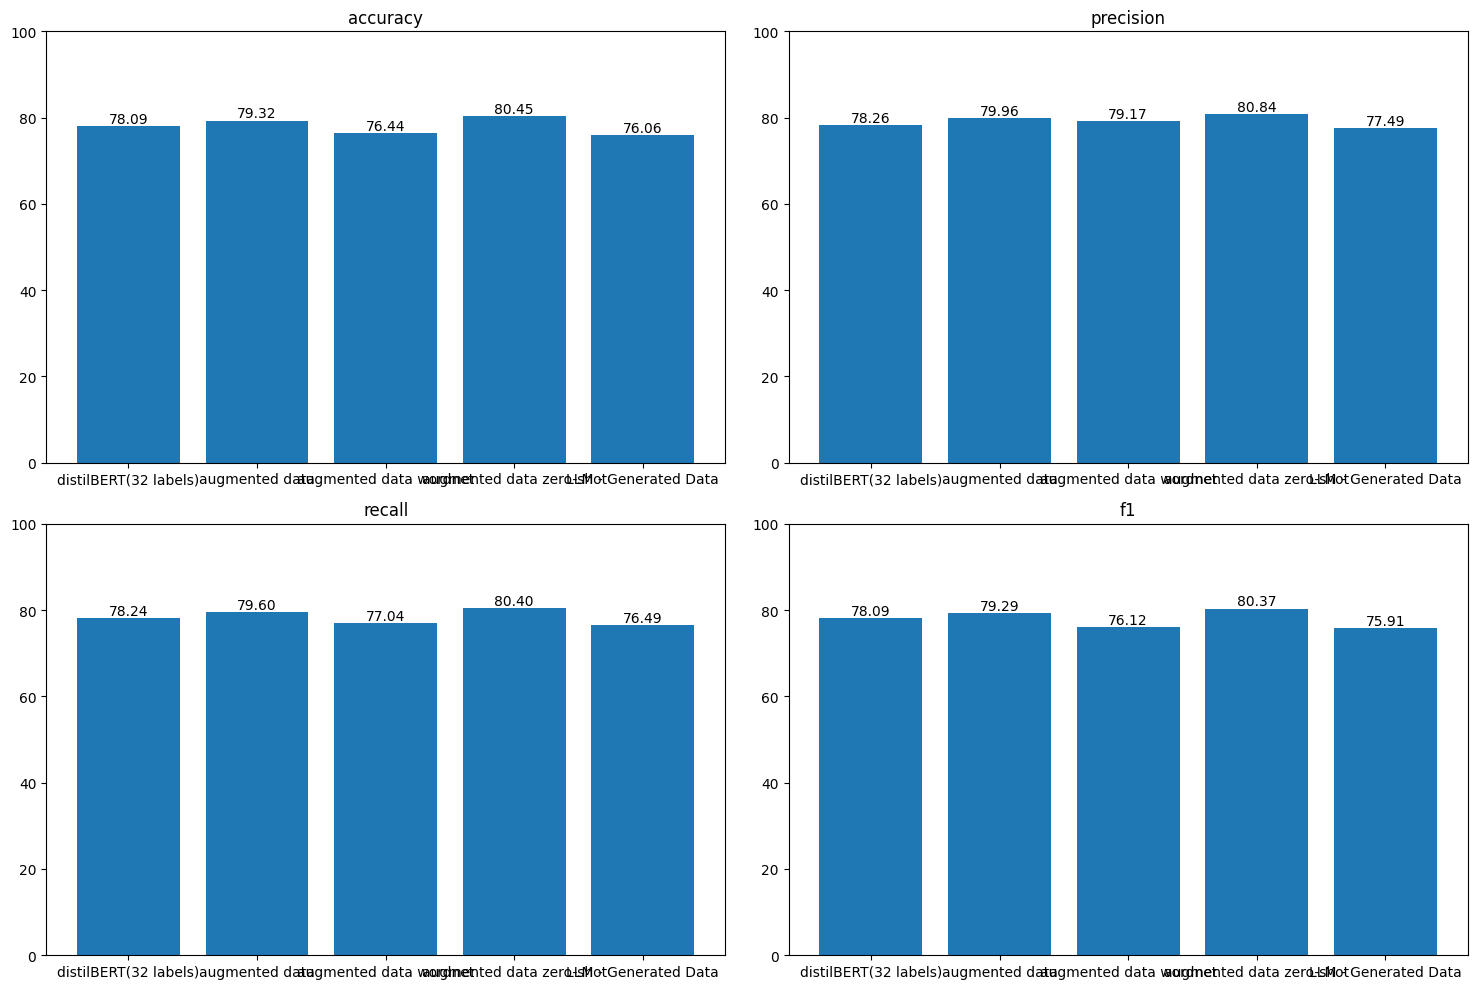

In [123]:
# get the final metrics
metrics_val.run(test_labels, valid_preds, "LLM - Generated Data")
metrics_val.plot()
tf.keras.backend.clear_session()

# e. Optimal Technique Application

---

# Part 3: State of the Art Comparison
## a. Full Dataset Training

In [124]:
metrics_tech = Metrics()

In [125]:
# Define observation shares
observation_shares = [0.01, 0.10, 0.25, 0.5, 0.75, 1]

# List to store validation predictions for all models
all_valid_preds = []

# List to store histories for all models
all_histories = []

for share in observation_shares:
    # Calculate the number of observations
    obs_count = int(len(df_train) * share)

    # Sample from the DataFrame
    df_train_sampled = df_train.sample(n=obs_count)

    # Extract features and labels
    train_data_sampled = df_train_sampled['clean_text']
    train_labels_sampled = df_train_sampled['label']

    # One-hot encode the labels
    enc = OneHotEncoder(handle_unknown='ignore')
    y_train_sampled = enc.fit_transform(np.array(train_labels_sampled).reshape(-1, 1)).toarray()

    # Get validation data
    # validation_data = df_validation['clean_text']
    # validation_labels = df_validation['label']

    # Convert validation labels to one-hot encoding
    y_valid = enc.transform(np.array(validation_labels).reshape(-1, 1)).toarray()

    # Define steps per epoch
    steps_per_epoch = int(len(X_train)/batch_size)

    # Generate batches for training data
    train_batches = get_batches(train_data_sampled, y_train_sampled, tokenizer, batch_size, max_length)

    # Generate batches for validation data
    valid_batches = get_batches(validation_data, y_valid, tokenizer, batch_size, max_length)

    # Compile the model
    bert_model.compile(
        optimizer=Adam(2e-5),
        metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()],
        loss=tf.keras.losses.CategoricalCrossentropy()
    )

    # Train the model and record the history
    history = bert_model.fit(
        train_batches,
        epochs=5,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_batches,
        validation_steps=len(validation_data) // batch_size,
        callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
    )

    # Append the history to the list
    all_histories.append(history)

    # Get the inputs tokenized from the validation set
    inputs = tokenizer.batch_encode_plus(list(test_data),
                                         add_special_tokens=True,
                                         max_length=max_length,
                                         padding='max_length',
                                         return_attention_mask=True,
                                         return_token_type_ids=True,
                                         truncation=True)

    # Extract input_ids and attention mask
    inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
                    np.asarray(inputs['attention_mask'], dtype='int32')]

    # Get predictions for the validation set
    valid_preds = bert_model.predict(inputs_valid)
    valid_preds = np.argmax(valid_preds, axis=1)

    # Append predictions to the list
    all_valid_preds.append(valid_preds)
    metrics_val.run(test_labels, valid_preds, f"share_{int(share * 100)}%")
    tf.keras.backend.clear_session()

Epoch 1/5


141/141 [==============================] - 168s 973ms/step - loss: 0.0692 - recall: 0.9770 - precision: 0.9770 - val_loss: 1.5601 - val_recall: 0.7888 - val_precision: 0.7888
Epoch 2/5
141/141 [==============================] - 134s 948ms/step - loss: 2.2974e-04 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.7580 - val_recall: 0.7887 - val_precision: 0.7887
Epoch 3/5
97/97 [==============================] - 42s 396ms/step
Epoch 1/5


141/141 [==============================] - 179s 1s/step - loss: 0.5369 - recall: 0.7933 - precision: 0.7933 - val_loss: 0.4203 - val_recall: 0.8356 - val_precision: 0.8356
Epoch 2/5
141/141 [==============================] - 152s 1s/step - loss: 0.1731 - recall: 0.9378 - precision: 0.9378 - val_loss: 0.7098 - val_recall: 0.8142 - val_precision: 0.8142
Epoch 3/5
97/97 [==============================] - 43s 404ms/step
Epoch 1/5


141/141 [==============================] - 171s 997ms/step - loss: 0.4719 - recall: 0.7961 - precision: 0.7961 - val_loss: 0.4159 - val_recall: 0.8215 - val_precision: 0.8215
Epoch 2/5
141/141 [==============================] - 138s 977ms/step - loss: 0.3302 - recall: 0.8655 - precision: 0.8655 - val_loss: 0.4285 - val_recall: 0.8390 - val_precision: 0.8390
Epoch 3/5
97/97 [==============================] - 41s 387ms/step
Epoch 1/5


141/141 [==============================] - 174s 995ms/step - loss: 0.4091 - recall: 0.8360 - precision: 0.8360 - val_loss: 0.3733 - val_recall: 0.8443 - val_precision: 0.8443
Epoch 2/5
141/141 [==============================] - 135s 957ms/step - loss: 0.4208 - recall: 0.8342 - precision: 0.8342 - val_loss: 0.3726 - val_recall: 0.8397 - val_precision: 0.8397
Epoch 3/5
141/141 [==============================] - 133s 943ms/step - loss: 0.3573 - recall: 0.8580 - precision: 0.8580 - val_loss: 0.3948 - val_recall: 0.8518 - val_precision: 0.8518
Epoch 4/5
97/97 [==============================] - 39s 373ms/step
Epoch 1/5


141/141 [==============================] - 167s 972ms/step - loss: 0.3462 - recall: 0.8546 - precision: 0.8546 - val_loss: 0.3856 - val_recall: 0.8316 - val_precision: 0.8316
Epoch 2/5
141/141 [==============================] - 131s 933ms/step - loss: 0.3443 - recall: 0.8582 - precision: 0.8582 - val_loss: 0.3919 - val_recall: 0.8290 - val_precision: 0.8290
Epoch 3/5
97/97 [==============================] - 40s 380ms/step
Epoch 1/5


141/141 [==============================] - 173s 989ms/step - loss: 0.3362 - recall: 0.8768 - precision: 0.8768 - val_loss: 0.3760 - val_recall: 0.8469 - val_precision: 0.8469
Epoch 2/5
141/141 [==============================] - 132s 936ms/step - loss: 0.3287 - recall: 0.8723 - precision: 0.8723 - val_loss: 0.3705 - val_recall: 0.8491 - val_precision: 0.8491
Epoch 3/5
141/141 [==============================] - 133s 942ms/step - loss: 0.3176 - recall: 0.8768 - precision: 0.8768 - val_loss: 0.4198 - val_recall: 0.8283 - val_precision: 0.8283
Epoch 4/5
97/97 [==============================] - 39s 369ms/step


## b. Learning Curve

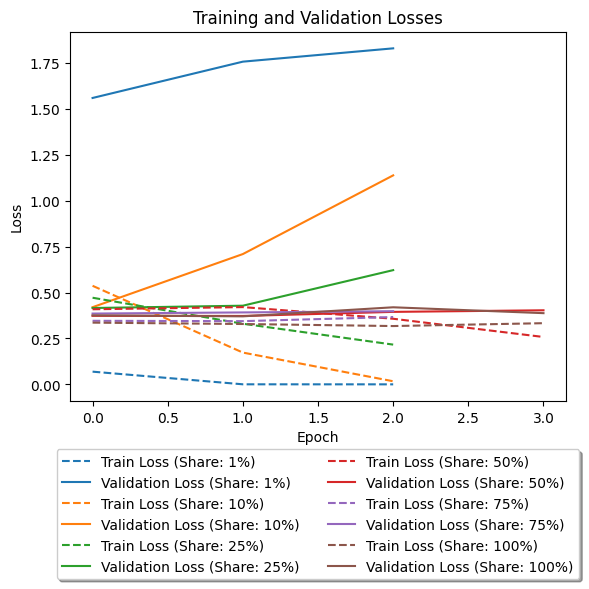

In [132]:
# Define a colormap with enough distinct colors
colors = plt.cm.tab10.colors

# Create figure and axis objects
fig, ax = plt.subplots()

# Plot losses for all histories
for i, history in enumerate(all_histories):
    # Extract training and validation losses
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot training and validation losses with appropriate color
    color_index = i % len(colors)
    ax.plot(train_loss, label=f'Train Loss (Share: {int(observation_shares[i] * 100)}%)', linestyle='--', color=colors[color_index])
    ax.plot(val_loss, label=f'Validation Loss (Share: {int(observation_shares[i] * 100)}%)', color=colors[color_index])

# Set title and labels
ax.set_title('Training and Validation Losses')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), shadow=True, ncol=2)  # Moving legend to the bottom

# Show plot
plt.show()

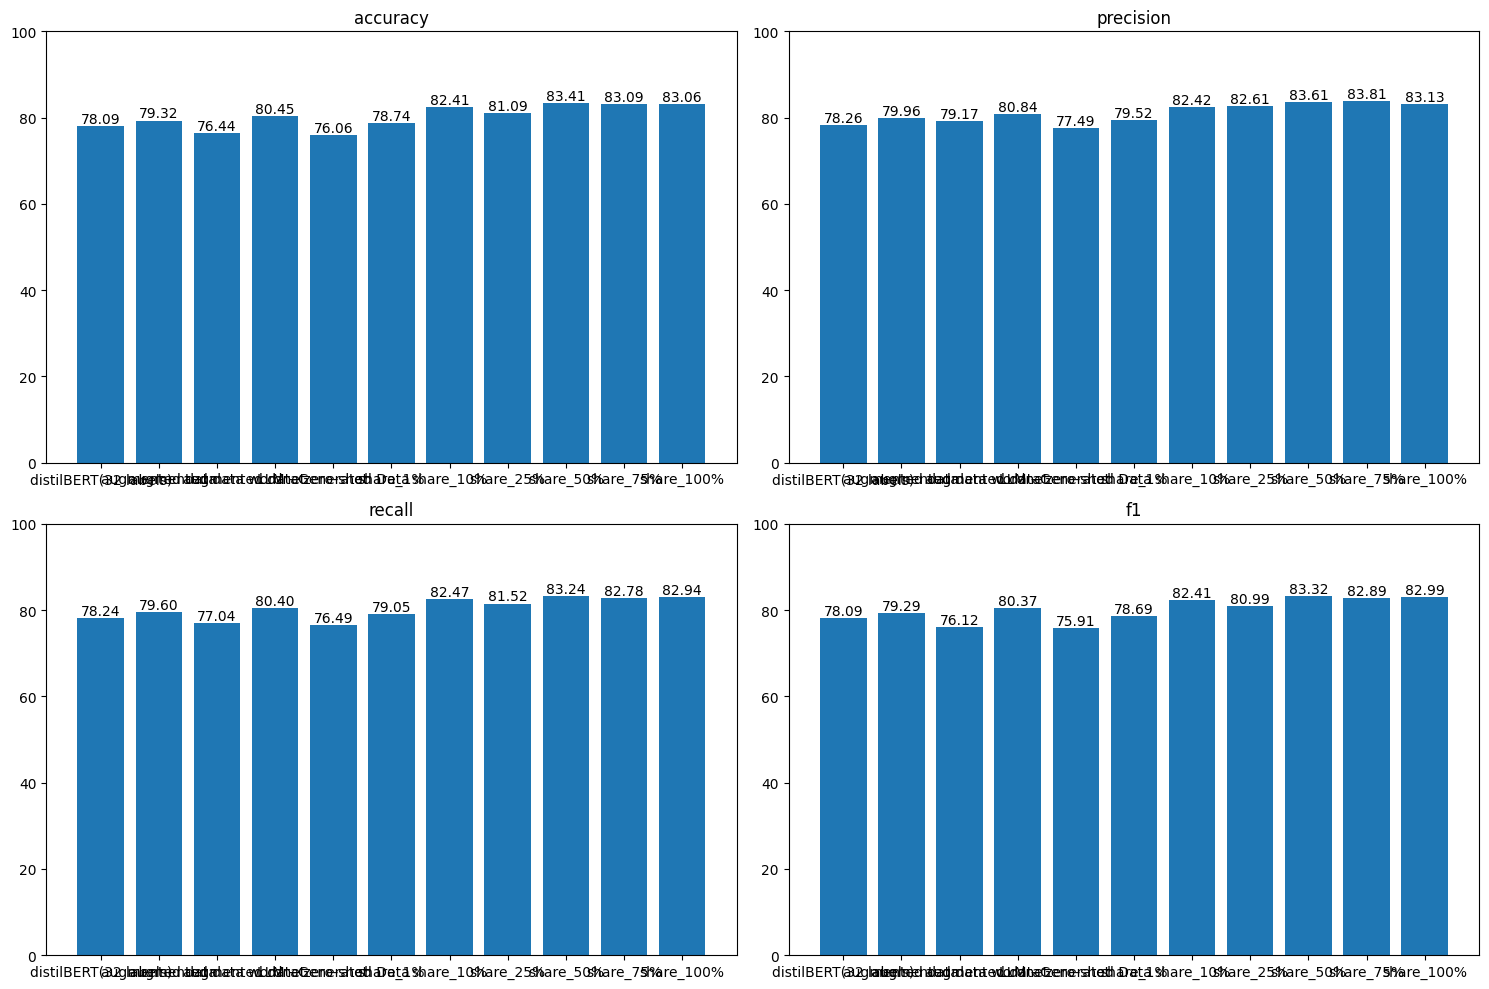

In [134]:
metrics_val.plot()

## c. Technique Comparison
## Pre-train the (freezed) model with the different techniques explored before

In [128]:
# Apply the different techniques and compare their perfromance
# 1. 32 label, 2. Synonyms, 3. Zero Shot, 4. LLM Tweets
techniques_names = ["32 Labels","Augmented Synonyms","Zero Shot","Generated Tweets"]
techniques = [[train_data_32,train_labels_32], [augmented_df_data,augmented_df_label], [augmented_zero_df_data, augmented_zero_df_label],[train_data_generated,train_labels_generated]]

Model : 32 Labels
Fit Freezed layer...
Epoch 1/2
4/4 [==============================] - 14s 169ms/step - loss: 0.0797 - recall: 0.9688 - precision: 0.9688
Epoch 2/2
97/97 [==============================] - 39s 365ms/step
Fit unfreezd layer...
Epoch 1/2


749/749 [==============================] - 639s 813ms/step - loss: 0.2922 - recall_1: 0.8853 - precision_1: 0.8853
Epoch 2/2
97/97 [==============================] - 39s 369ms/step
Model : 32 Labels
Fit Freezed layer...
Epoch 1/2
84/84 [==============================] - 27s 164ms/step - loss: 0.0485 - recall: 0.9851 - precision: 0.9851
Epoch 2/2
97/97 [==============================] - 38s 363ms/step
Fit unfreezd layer...
Epoch 1/2


749/749 [==============================] - 590s 742ms/step - loss: 0.0958 - recall_1: 0.9700 - precision_1: 0.9700
Epoch 2/2
97/97 [==============================] - 44s 413ms/step
Model : 32 Labels
Fit Freezed layer...
Epoch 1/2
41/41 [==============================] - 22s 188ms/step - loss: 0.8345 - recall: 0.8323 - precision: 0.8323
Epoch 2/2
97/97 [==============================] - 43s 408ms/step
Fit unfreezd layer...
Epoch 1/2


749/749 [==============================] - 593s 749ms/step - loss: 0.0524 - recall_1: 0.9840 - precision_1: 0.9840
Epoch 2/2
97/97 [==============================] - 37s 353ms/step
Model : 32 Labels
Fit Freezed layer...
Epoch 1/2
141/141 [==============================] - 36s 162ms/step - loss: 0.4941 - recall: 0.8715 - precision: 0.8715
Epoch 2/2
97/97 [==============================] - 37s 350ms/step
Fit unfreezd layer...
Epoch 1/2


749/749 [==============================] - 576s 722ms/step - loss: 0.0398 - recall_1: 0.9875 - precision_1: 0.9875
Epoch 2/2
97/97 [==============================] - 45s 430ms/step


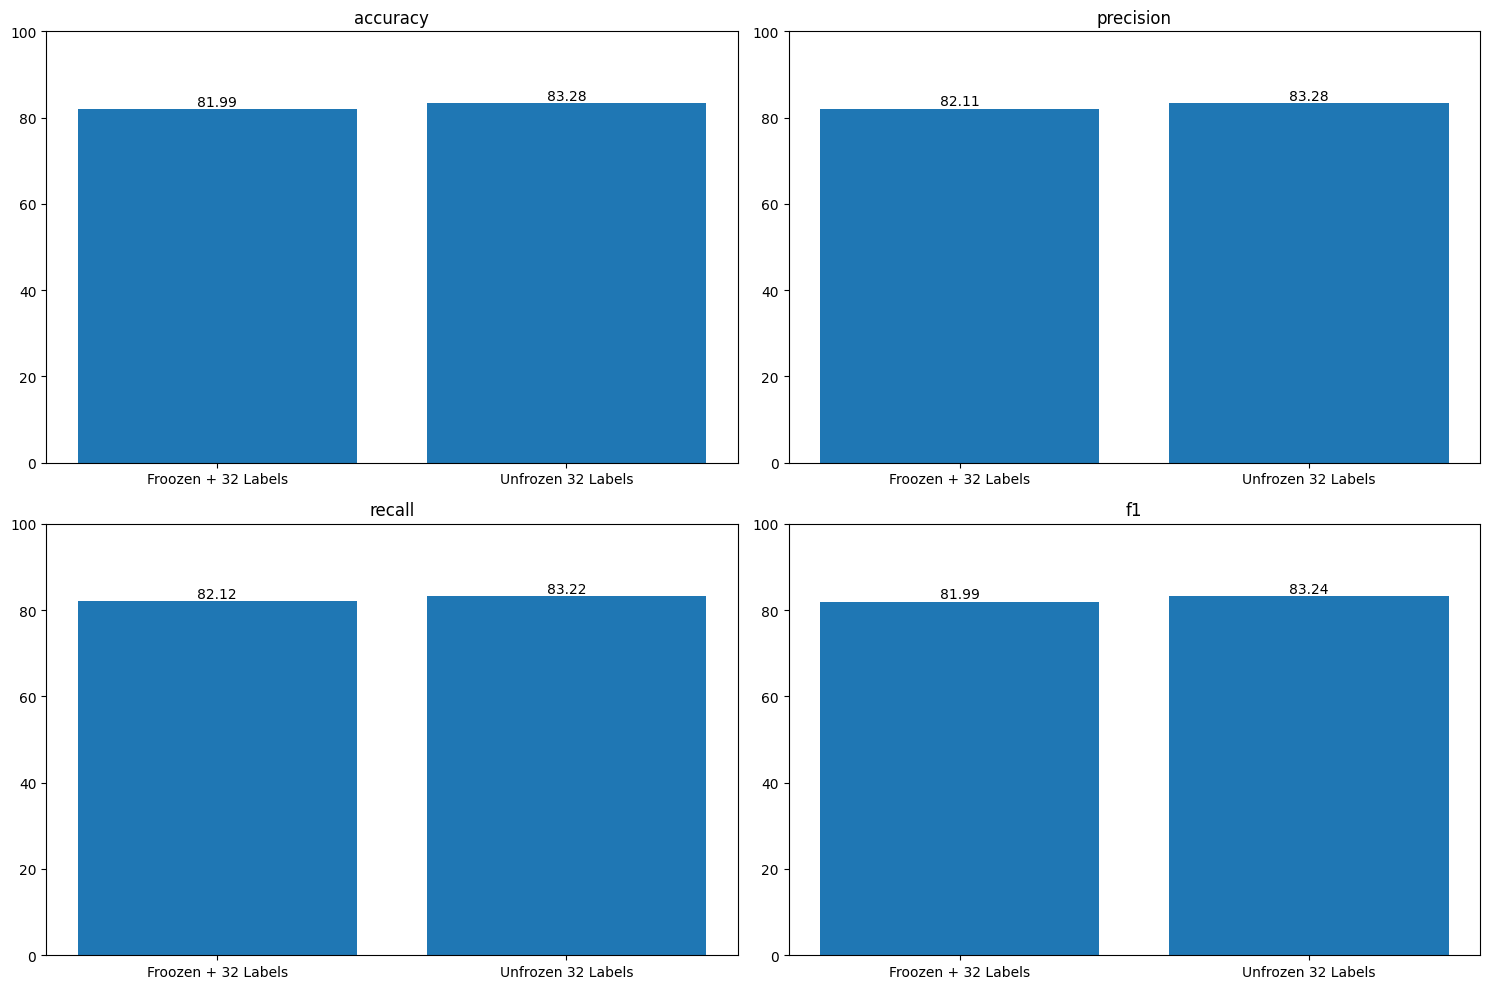

In [129]:
histories = []

for train_tec,y_tec in techniques:
    i = 0
    print("Model :",techniques_names[i])
    bert_model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)
    # To freeze BERT parameters (look at the trainable parameters below)
    bert_model.layers[2].trainable = False

    X_train = np.array(train_tec)

    enc = OneHotEncoder(handle_unknown='ignore')
    y_train = enc.fit_transform(np.array(y_tec).reshape(-1, 1)).toarray()

    steps_per_epoch = int(len(X_train)/batch_size)

    batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

    bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

    print("Fit Freezed layer...")
    bert_model.fit(batches, epochs=2, steps_per_epoch=steps_per_epoch)

    # Test the model
    inputs = tokenizer.batch_encode_plus(list(test_data_clean),
                                        add_special_tokens=True, max_length=max_length,
                                        padding='max_length',  return_attention_mask=True,
                                        return_token_type_ids=True, truncation=True)

    # Extract input_ids and attention mask
    inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
                  np.asarray(inputs['attention_mask'], dtype='int32')]

    test_preds = bert_model.predict(inputs_test)
    test_preds = np.argmax(test_preds, axis=1)

    # get the final metrics
    metrics_tech.run(test_labels, test_preds, f"Froozen + {techniques_names[i]}")

    print("Fit unfreezd layer...")
    bert_model.layers[2].trainable = True

    steps_per_epoch = int(len(train_data)/batch_size)
    X_train = np.array(train_data_clean)

    enc = OneHotEncoder(handle_unknown='ignore')
    y_train = enc.fit_transform(np.array(train_labels).reshape(-1, 1)).toarray()

    # Train on the whole NN
    batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

    bert_model.compile(optimizer=Adam(2e-5),
                      metrics=[tf.keras.metrics.Recall(),
                      tf.keras.metrics.Precision()],
                      loss=tf.keras.losses.CategoricalCrossentropy())

    hitory = bert_model.fit(batches, epochs=2, steps_per_epoch=steps_per_epoch)
    histories.append(history)

    # Get the inputs tokenized from the test set
    inputs = tokenizer.batch_encode_plus(list(test_data_clean),
                                        add_special_tokens=True, max_length=max_length,
                                        padding='max_length',  return_attention_mask=True,
                                        return_token_type_ids=True, truncation=True)

    # Extract input_ids and attention mask
    inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
                  np.asarray(inputs['attention_mask'], dtype='int32')]
    test_preds = bert_model.predict(inputs_test)
    test_preds = np.argmax(test_preds, axis=1)

    # get the final metrics
    metrics_tech.run(test_labels, test_preds, f"Unfrozen {techniques_names[i]}")
    tf.keras.backend.clear_session()
    i = i+1

metrics_tech.plot()

In [130]:
# Order the histories by the validation loss
histories = sorted(histories, key=lambda x: x[0].history['val_loss'][-1])

df_histories = pd.DataFrame(histories, columns=['history','loss','val_loss'])

# Print the results in order:
results = df_histories
results = results.sort_values(by='val_loss', ascending=True)

means = results['loss']
dev = results['val_loss']
for mean, stdev, param in zip(means, dev, techniques_names):
    print(f"Model {techniques_names[i]} %f (%f) with: %r" % (mean, stdev, param))

TypeError: 'History' object is not subscriptable

## d. Methodology Analysis

# Part 4: Model Distillation
## a. Model Distillation

In [ ]:
import time
class Distiller(tf.keras.Model):

    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(self,optimizer,metrics,student_loss_fn,distillation_loss_fn,alpha=0.1,temperature=3,):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False):

        teacher_pred = self.teacher(x, training=False)
        student_loss = self.student_loss_fn(y, y_pred)

        distillation_loss = self.distillation_loss_fn(
            tf.nn.softmax(teacher_pred / self.temperature, axis=1),
            tf.nn.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2)

        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        return loss

    def call(self, x):
        return self.student(x)


In [ ]:
# Create the teacher
teacher = tf.keras.models.clone_model(bert_model)

# Create the student model on "distilbert/distilroberta-base"
checkpoint_distil="distilbert/distilroberta-base"
tokenizer_distil = AutoTokenizer.from_pretrained(checkpoint_distil)
model_distil = TFAutoModel.from_pretrained(checkpoint_distil)

## Input
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Embedding layers
embedding_layer = model_distil(input_ids_in, attention_mask=input_masks_in)[0][:, 0, :]
output_layer = tf.keras.layers.Dropout(rate)(embedding_layer)
output = tf.keras.layers.Dense(num_labels, kernel_initializer="glorot_uniform", activation='softmax')(output_layer)

# One dense layer to process the last layer
output = tf.keras.layers.Dense(num_labels,
                               kernel_initializer="glorot_uniform",
                               activation='softmax')(output_layer)


model_distil = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)

model_distil.summary()
student = model_distil

teacher.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

student.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

In [ ]:
teacher.fit(batches_with_progress, epochs=2, steps_per_epoch=steps_per_epoch)
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(test_data_clean),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
start = time.clock()
valid_preds = teacher.predict(inputs_valid)
end = time.clock()
teacher_time = end-start
valid_preds = np.argmax(valid_preds, axis=1)

In [ ]:
# get the final metrics
metrics_dis= Metrics()
metrics_dis.run(test_labels, valid_preds, "Teacher")
metrics_dis.plot()

In [ ]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=Adam(2e-5),
    metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()],
    student_loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
distiller.fit(batches_with_progress, epochs=2, steps_per_epoch=steps_per_epoch)

In [ ]:
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(test_data_clean),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
start = time.clock()
valid_preds = distiller.predict(inputs_valid)
end = time.clock()
student_time = end-start
valid_preds = np.argmax(valid_preds, axis=1)

In [ ]:
# get the final metrics
metrics_dis.run(test_labels, valid_preds, "Student")
metrics_dis.plot()

## b. Performance and Speed Comparison

In [ ]:
print(teacher_time)
print(student_time)

In [ ]:
teacher.summary()

In [ ]:
student.summary()

## c. Analysis and Improvements

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels, valid_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()